# This file

This notebook is used to collect experimental data on shortcut usage for agents in the shortcut environment

In [2]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *
from plotting_utils import *
from read_experiments import *

from tqdm import tqdm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from pathlib import Path
import shutil

set_rc()

chks1 = np.arange(0, 150, 10) #0-1e6
chks2 = np.arange(160, 300, 20) #1e6-2e6
chks3 = np.arange(300, 600, 40) #2e6-4e6
chks4 = np.arange(620, 930, 60) #4e6-6e6
chk_sched = np.concatenate([chks1, chks2, chks3, chks4])

# WS/NS Data collection

In [30]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.8, 1.0]
trials = range(10)
# chks = np.arange(40, 470, 40)
chks = np.arange(40, 930, 40)

folder = Path('data/shortcut/wc1.5_policy')

for p, t in tqdm(itertools.product(probs, trials), total=len(probs)*len(trials)):
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': [], 'ns': []}
    
    for chk in chks:
        if p in [0.1, 0.4]:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}longer'
        else:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}'
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'].append(res['ws'][0])
        all_res['ns'].append(res['ns'][0])
    
    pickle.dump(all_res, open(folder/key, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [7:14:38<00:00, 434.65s/it]


## Merge continued save checkpoints to checkpoint folder

In [138]:
checkpts = Path('../saved_checkpoints/shortcut_wc2/')
folders = [f.name for f in checkpts.iterdir()]
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
for p, t in itertools.product(probs, trials):
    if p in [0.1, 0.4]:
        exp_name = f'shortcut_wc1.5p{p}longer_t{t}'
    else:
        exp_name = f'shortcut_wc1.5p{p}_t{t}'
    cont_name = f'shortcut_wc1.5p{p}_cont_t{t}'
    
    
    if cont_name in folders:
        print(exp_name, cont_name)
        cont_folder = checkpts/cont_name
        exp_folder = checkpts/exp_name
        for file in cont_folder.iterdir():
            fname = file.name
            shutil.copy(cont_folder/fname, exp_folder/fname)

shortcut_wc1.5p0.0_t0 shortcut_wc1.5p0.0_cont_t0
shortcut_wc1.5p0.0_t1 shortcut_wc1.5p0.0_cont_t1
shortcut_wc1.5p0.0_t2 shortcut_wc1.5p0.0_cont_t2
shortcut_wc1.5p0.0_t3 shortcut_wc1.5p0.0_cont_t3
shortcut_wc1.5p0.0_t4 shortcut_wc1.5p0.0_cont_t4
shortcut_wc1.5p0.0_t5 shortcut_wc1.5p0.0_cont_t5
shortcut_wc1.5p0.0_t6 shortcut_wc1.5p0.0_cont_t6
shortcut_wc1.5p0.0_t7 shortcut_wc1.5p0.0_cont_t7
shortcut_wc1.5p0.0_t8 shortcut_wc1.5p0.0_cont_t8
shortcut_wc1.5p0.0_t9 shortcut_wc1.5p0.0_cont_t9
shortcut_wc1.5p0.1longer_t0 shortcut_wc1.5p0.1_cont_t0
shortcut_wc1.5p0.1longer_t2 shortcut_wc1.5p0.1_cont_t2
shortcut_wc1.5p0.1longer_t3 shortcut_wc1.5p0.1_cont_t3
shortcut_wc1.5p0.1longer_t4 shortcut_wc1.5p0.1_cont_t4
shortcut_wc1.5p0.2_t0 shortcut_wc1.5p0.2_cont_t0
shortcut_wc1.5p0.2_t1 shortcut_wc1.5p0.2_cont_t1
shortcut_wc1.5p0.2_t2 shortcut_wc1.5p0.2_cont_t2
shortcut_wc1.5p0.2_t3 shortcut_wc1.5p0.2_cont_t3
shortcut_wc1.5p0.2_t4 shortcut_wc1.5p0.2_cont_t4
shortcut_wc1.5p0.2_t5 shortcut_wc1.5p0.2_cont

In [ ]:
'''Run to generate csvs for run files'''

probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
fig, ax = pplt.subplots()
for p in probs:
    exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}_cont'
    average_runs(exp_name, 'length', ax=ax)

## Perform shortcut tests only on agents after successful training

### First generate csvs so we can merge run with their continuations

### Check which trials actually had enough checkpoints to perform full  test

In [148]:
def get_first_last_performing_chks(p=0.4, t=0, verbose=False):
    '''Specific function for getting first and last checkpoints to test
    starting from first performing
    
    If return False, it means either not enough chks available or 
        never reached the required performance to start
    '''
    chks_up = int(round(5950000/(64*100), -1)) #how many more chks to get to 6e6 steps
    
    # Get first checkpoint where performance is sufficient
    if p in [0.1, 0.4]:
        df = combine_cont_df(exp_format='shortcut_wc1.5p{p}longer_t{t}',
                             formatter={'p': p, 't': t})
    else:
        df = combine_cont_df(formatter={'p': p, 't': t})
    x, y = get_run_df_metric(df, ignore_first=1000)
    first_chk = get_first_shortcut_performance(x, y)
    
    if p in [0.1, 0.4]:
        exp_name = f'shortcut_wc1.5p{p}longer_t{t}'
    else:
        exp_name = f'shortcut_wc1.5p{p}_t{t}'
    
    folder = Path(f'../saved_checkpoints/shortcut_wc2/{exp_name}')
    fnames = [f.name for f in folder.iterdir()]
    
    if verbose:
        print(f'{p}_{t}', first_chk, first_chk+chks_up, f'{first_chk+chks_up}.pt' in fnames)
    
    if first_chk is False or f'{first_chk+chks_up}.pt' not in fnames:
        return False
    else:
        return first_chk, first_chk+chks_up



In [139]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
chks_up = int(round(5950000/(64*100), -1)) #how many more chks to get to 6e6 steps
for p, t in itertools.product(probs, range(10)):
    
    if p in [0.1, 0.4]:
        df = combine_cont_df(exp_format='shortcut_wc1.5p{p}longer_t{t}',
                             formatter={'p': p, 't': t})
    else:
        df = combine_cont_df(formatter={'p': p, 't': t})
    x, y = get_run_df_metric(df, ignore_first=1000)
    
    first_chk = get_first_shortcut_performance(x, y)
    
    if p in [0.1, 0.4]:
        exp_name = f'shortcut_wc1.5p{p}longer_t{t}'
    else:
        exp_name = f'shortcut_wc1.5p{p}_t{t}'
    
    folder = Path(f'../saved_checkpoints/shortcut_wc2/{exp_name}')
    fnames = [f.name for f in folder.iterdir()]
    print(f'{p}_{t}', first_chk, first_chk+chks_up, f'{first_chk+chks_up}.pt' in fnames)
    


0.0_0 450 1380 True
0.0_1 False 930 True
0.0_2 490 1420 True
0.0_3 210 1140 True
0.0_4 500 1430 True
0.0_5 570 1500 True
0.0_6 670 1600 True
0.0_7 400 1330 True
0.0_8 710 1640 True
0.0_9 230 1160 True
0.1_0 470 1400 True
0.1_1 590 1520 True
0.1_2 560 1490 True
0.1_3 470 1400 True
0.1_4 470 1400 True
0.1_5 120 1050 True
0.1_6 310 1240 True
0.1_7 300 1230 True
0.1_8 1350 2280 False
0.1_9 150 1080 True
0.2_0 270 1200 True
0.2_1 560 1490 True
0.2_2 490 1420 True
0.2_3 920 1850 True
0.2_4 400 1330 True
0.2_5 60 990 True
0.2_6 240 1170 True
0.2_7 230 1160 True
0.2_8 80 1010 True
0.2_9 610 1540 True
0.3_0 410 1340 True
0.3_1 770 1700 True
0.3_2 610 1540 True
0.3_3 880 1810 True
0.3_4 100 1030 True
0.3_5 False 930 True
0.3_6 960 1890 False
0.3_7 110 1040 True
0.3_8 270 1200 True
0.3_9 False 930 True
0.4_0 470 1400 True
0.4_1 70 1000 True
0.4_2 130 1060 True
0.4_3 80 1010 True
0.4_4 80 1010 True
0.4_5 60 990 True
0.4_6 130 1060 True
0.4_7 50 980 True
0.4_8 70 1000 True
0.4_9 490 1420 True
0.5_0

### WS/NS Data collection

In [174]:
folder = Path('data/shortcut/wc1.5_policy')

probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)

for p, t in tqdm(itertools.product(probs, trials), total=len(probs)*len(trials)):    
    chks = get_first_last_performing_chks(p, t, False)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched
    
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    
    for chk in chks:
        if p in [0.1, 0.4]:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}longer'
        else:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}'
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))

    
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 80/80 [9:02:55<00:00, 407.19s/it]


### WS/NS Copied

In [71]:
folder = Path('data/shortcut/wc1.5_copied')

probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)

for p, t in tqdm(itertools.product(probs, trials), total=len(probs)*len(trials)):
    chks = get_first_last_performing_chks(p, t, False)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched
    
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    
    for chk in chks:
        if p in [0.1, 0.4]:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}longer'
        else:
            exp_name = f'shortcut_wc2/shortcut_wc1.5p{p}'
        res = shortcut_test(exp_name, t, chk, with_fa=True)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))

    
    

100%|█████████████████████████████████████████████████████████████████████████████████████| 80/80 [4:41:34<00:00, 211.18s/it]


## Combine into summary dict

## Continued experiments

In [125]:
p = 0.2
xs = []
ys = []
for t in range(10):
    df = combine_cont_df(formatter={'p': p, 't': t})
    x, y = get_run_df_metric(df, ignore_first=1000)
    first = get_first_shortcut_performance(x, y, ret_chk=False)
    x, y = x[first:], y[first:]
    
    xs.append(np.array(x))
    ys.append(np.array(y))

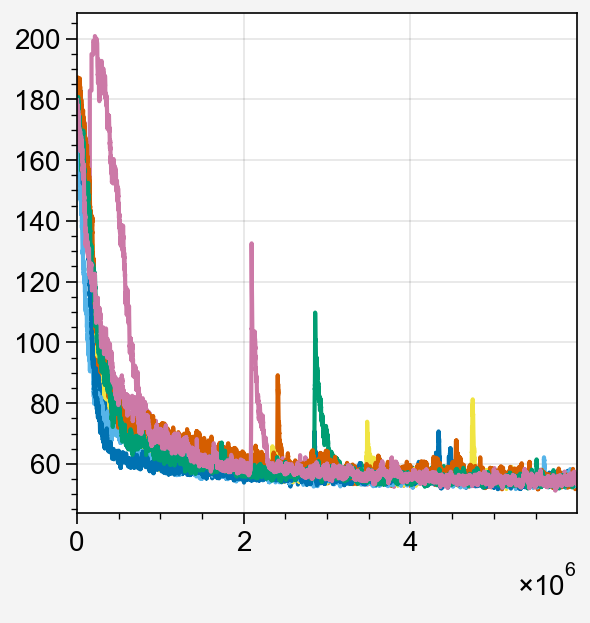

In [126]:
fig, ax = pplt.subplots()
for t in range(10):
    ax.plot(xs[t]-xs[t][0], ys[t])

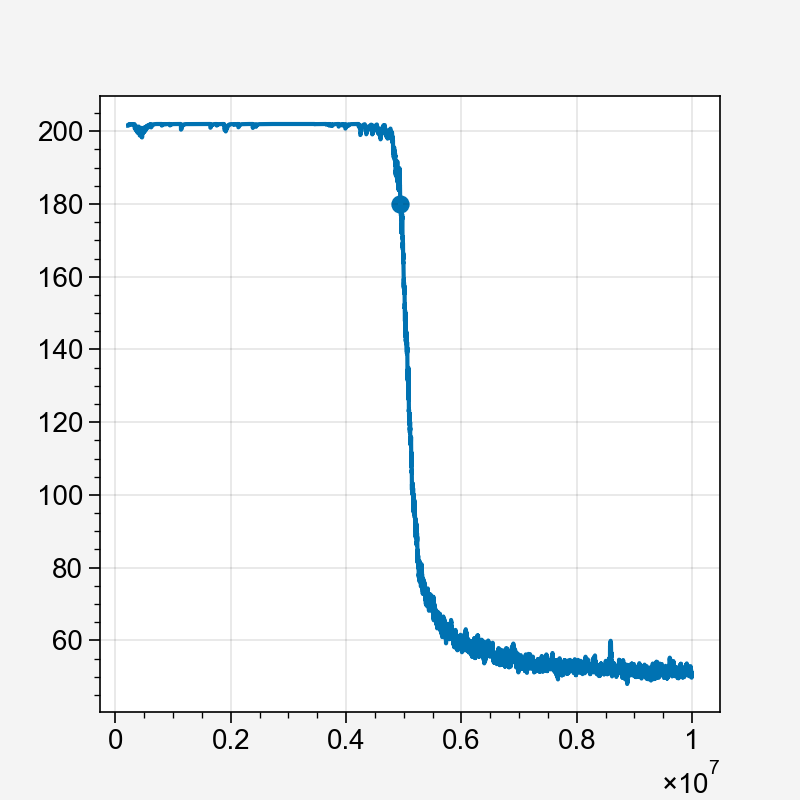

In [143]:
p = 0.4
t = 0

df = combine_cont_df(exp_format='shortcut_wc1.5p{p}longer_t{t}', formatter={'p': p, 't': t})
x, y = get_run_df_metric(df, ignore_first=1000)
first = get_first_shortcut_performance(x, y, ret_chk=False)

plt.plot(x, y)
plt.scatter([x[first]], [y[first]])

## Performance Plots

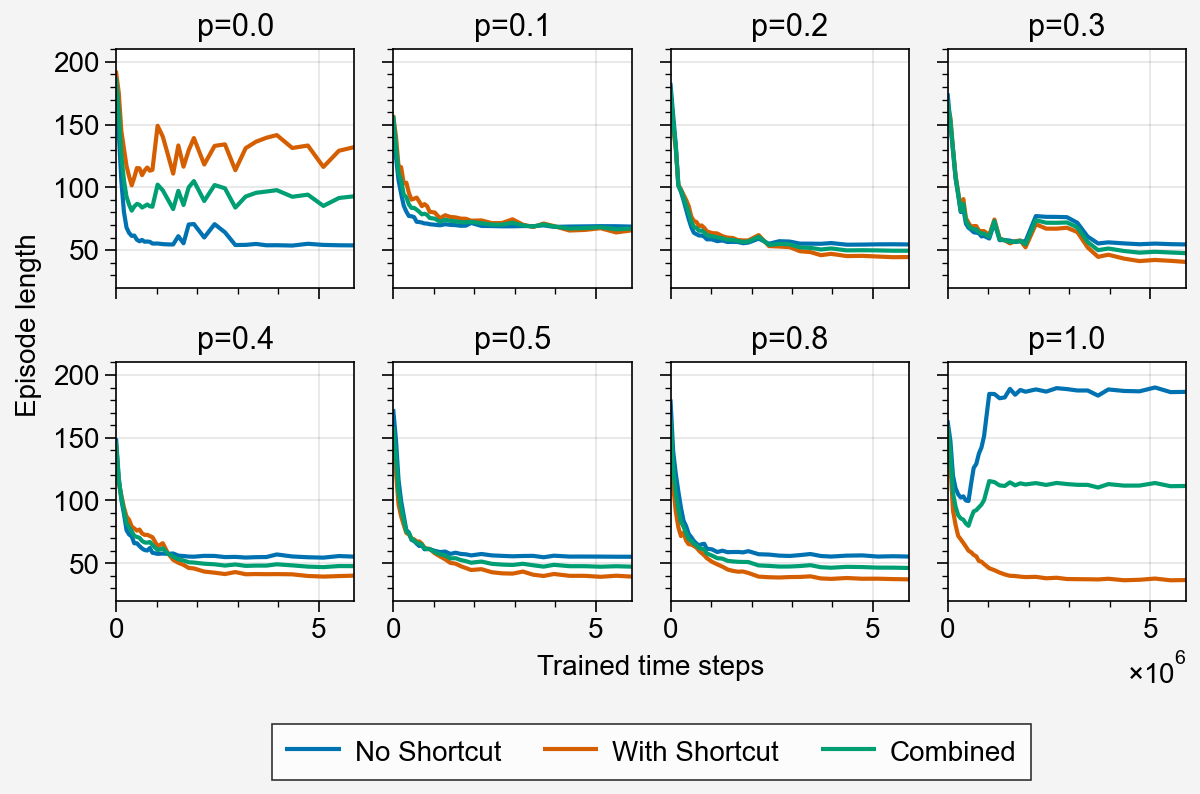

In [186]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in probs], ylim=[20, 210])

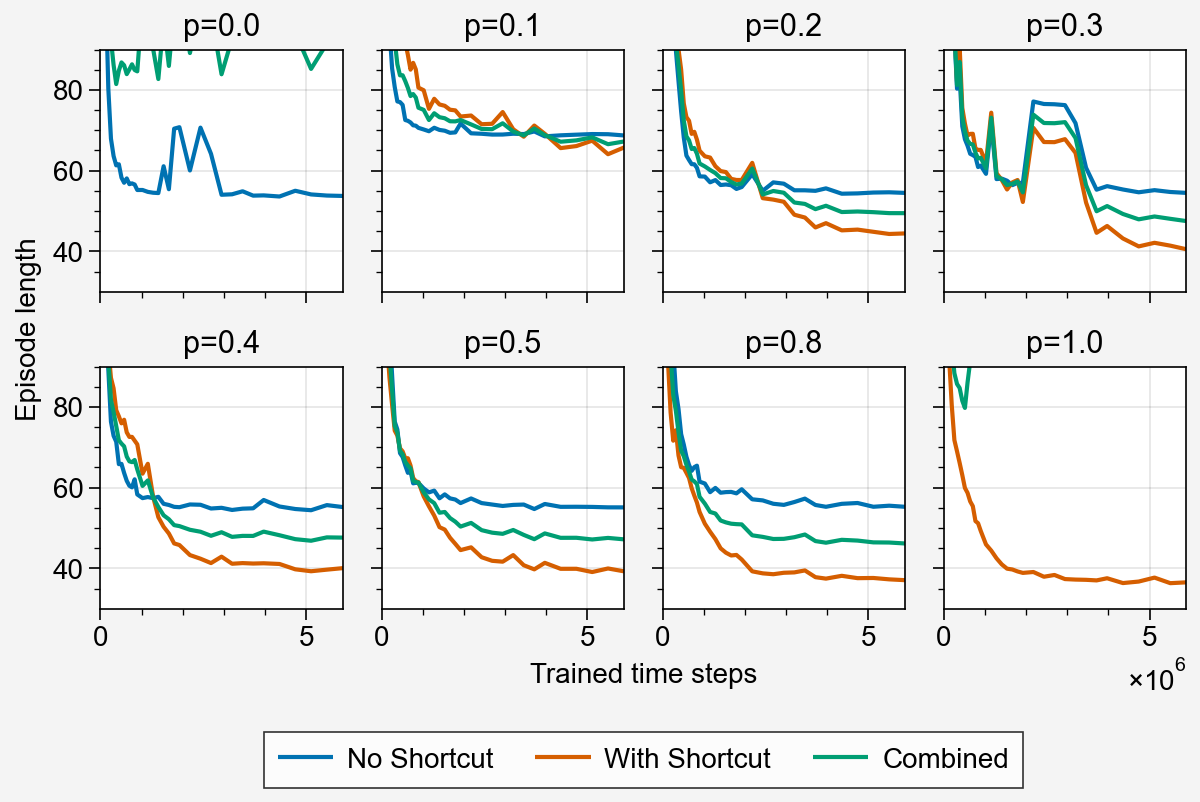

In [108]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in probs], ylim=[30, 90])

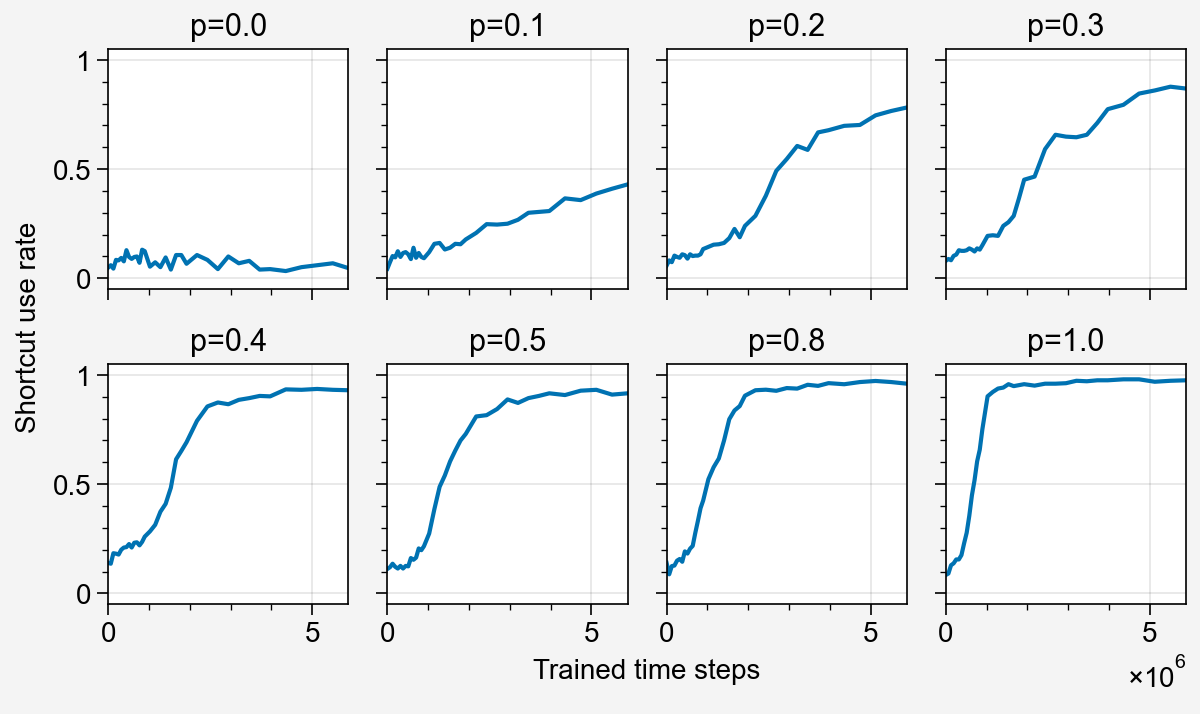

In [189]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['surs'], axis=0), label='Shortcut use rate'))

ax.format(xlabel='Trained time steps', ylabel='Shortcut use rate',
          title=[f'p={p}' for p in probs], ylim=[-0.05, 1.05])

## Shifted learning curves

In [227]:
'''Generate shifted learning curves'''

summ = {}

for p in probs:
    xs = []
    ys = []
    for t in range(10):
        if p in [0.1, 0.4]:
            df = combine_cont_df(exp_format='shortcut_wc1.5p{p}longer_t{t}',
                                 formatter={'p': p, 't': t})
        else:
            df = combine_cont_df(formatter={'p': p, 't': t})
        x, y = get_run_df_metric(df, ignore_first=1000)
        first = get_first_shortcut_performance(x, y, ret_chk=False)

        if not first:
            continue

        xs.append(x[first:]-x[first])
        ys.append(y[first:])
        
    xmin = int(np.min([min(x) for x in xs]))
    xmax = int(np.min([max(x) for x in xs]))
    x_grid = np.linspace(xmin, xmax, 500)
    inters = [scipy.interpolate.interp1d(xs[i], ys[i]) for i in range(len(xs))]
    y_grid = [inters[i](x_grid) for i in range(len(xs))]
    
    summ[p] = {
        'xs': xs,
        'ys': ys,
        'x_grid': x_grid,
        'y_grid': y_grid
    }
    
pickle.dump(summ, open('data/shortcut/wc1.5_policy/learning_curves', 'wb'))
    
    

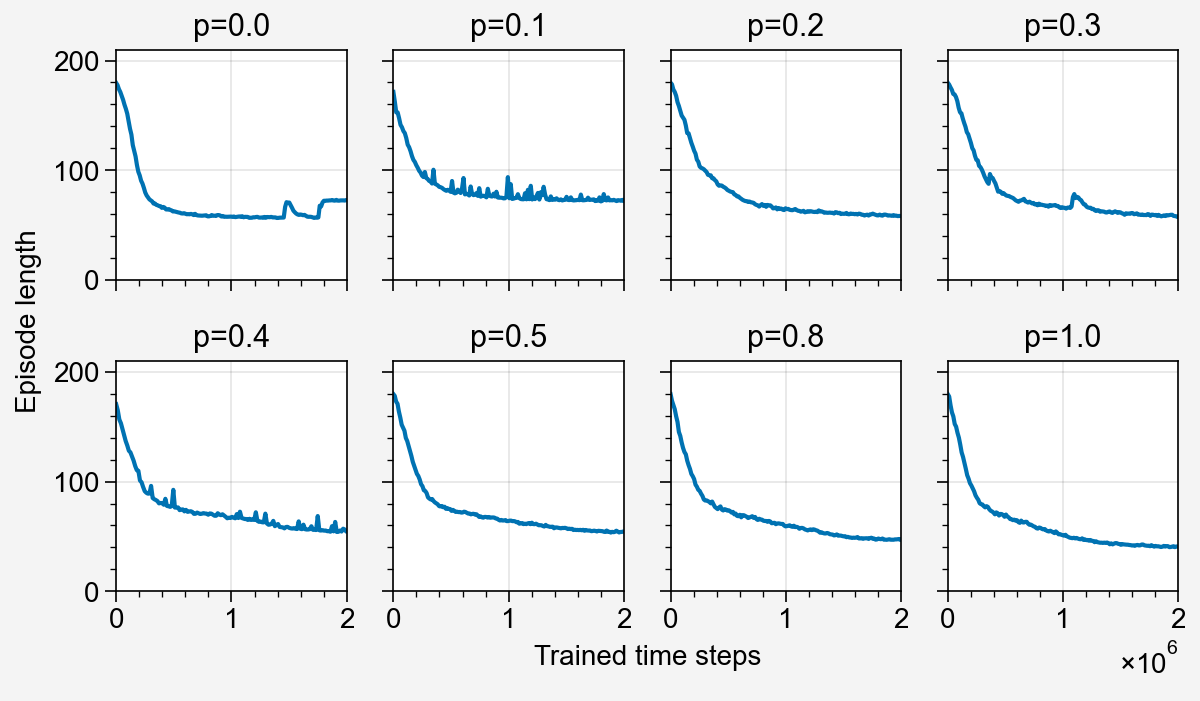

In [230]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'learning_curves', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

for i, p in enumerate(probs):
    x = summary[p]['x_grid']
    y = np.mean(summary[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, y))

ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in probs], ylim=[0, 210])

ax[:, :-1].format(xlim=[0, 2])
ax[:, -1].format(xlim=[0, 2e6])

## Plum

In [232]:
'''Generate shifted learning curves - SC w/Plum scheduling'''

summ = {}

for p in [0.1, 0.4]:
    xs = []
    ys = []
    for t in range(3):
        df = combine_cont_df(exp_format='scwplum_schedule1p{p}_t{t}',
                             formatter={'p': p, 't': t}, subdir='scwplum')
        x, y = get_run_df_metric(df, ignore_first=1000)
        first = get_first_shortcut_performance(x, y, ret_chk=False)

        if not first:
            continue

        xs.append(x[first:]-x[first])
        ys.append(y[first:])
        
    xmin = int(np.min([min(x) for x in xs]))
    xmax = int(np.min([max(x) for x in xs]))
    x_grid = np.linspace(xmin, xmax, 500)
    inters = [scipy.interpolate.interp1d(xs[i], ys[i]) for i in range(len(xs))]
    y_grid = [inters[i](x_grid) for i in range(len(xs))]
    
    summ[p] = {
        'xs': xs,
        'ys': ys,
        'x_grid': x_grid,
        'y_grid': y_grid
    }
    
pickle.dump(summ, open('data/shortcut/scwplum/learning_curves', 'wb'))
    

In [239]:
'''Generate shifted learning curves - Plum2sc Transfers'''

tasks = [1, 1.5, 2, 2.5]

summ = {}

for task, p in itertools.product(tasks, [0.1, 0.4]):
    key = f'{task}_{p}'
    
    xs = []
    ys = []
    for t in range(3):
        df = combine_cont_df(exp_format='plumtosc_sharedn_plumsched1_task{task}p{p}_t{t}',
                             formatter={'p': p, 't': t, 'task': task}, subdir='plumtosc')
        x, y = get_run_df_metric(df, ignore_first=1000)
        first = get_first_shortcut_performance(x, y, ret_chk=False)

        if not first:
            continue

        xs.append(x[first:]-x[first])
        ys.append(y[first:])
        
    xmin = int(np.min([min(x) for x in xs]))
    xmax = int(np.min([max(x) for x in xs]))
    x_grid = np.linspace(xmin, xmax, 500)
    inters = [scipy.interpolate.interp1d(xs[i], ys[i]) for i in range(len(xs))]
    y_grid = [inters[i](x_grid) for i in range(len(xs))]
    
    summ[key] = {
        'xs': xs,
        'ys': ys,
        'x_grid': x_grid,
        'y_grid': y_grid
    }
    
pickle.dump(summ, open('data/shortcut/plum2sc_policy/learning_curves', 'wb'))
    

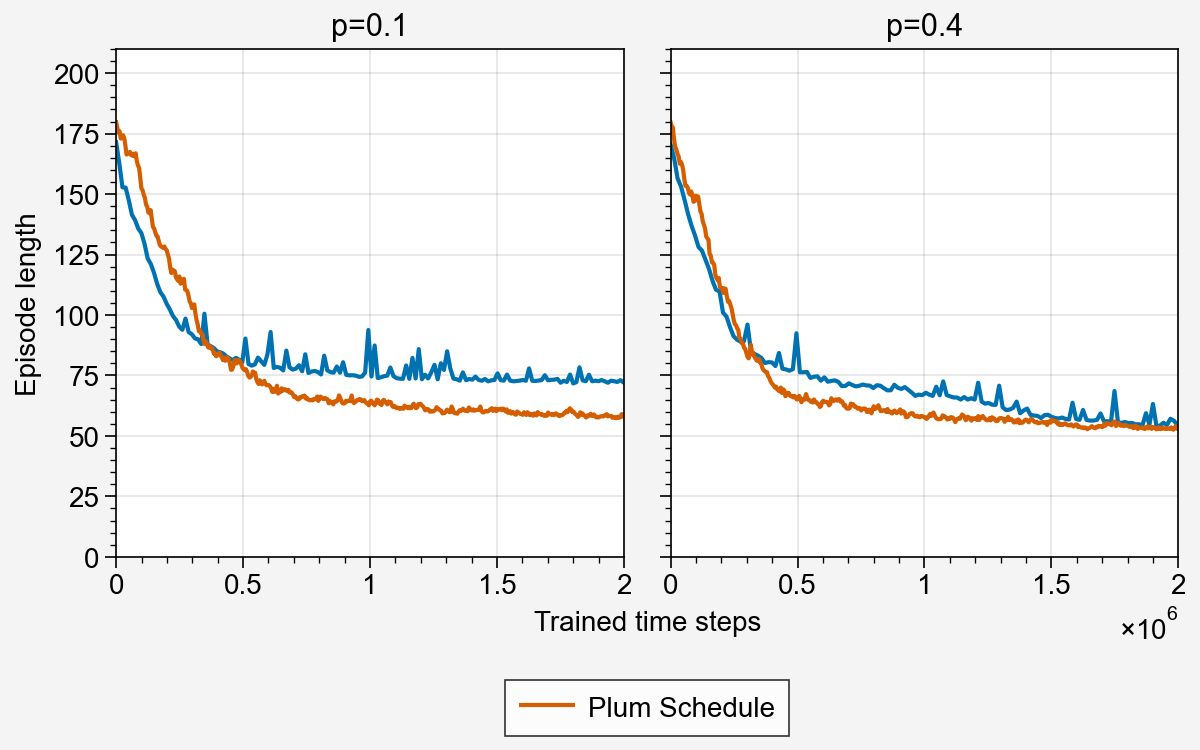

In [236]:
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')
folder2 = Path('data/shortcut/scwplum')

summary = pickle.load(open(folder/'learning_curves', 'rb'))
summary2 = pickle.load(open(folder2/'learning_curves', 'rb'))

fig, ax = pplt.subplots(ncols=2, figwidth=6)

for i, p in enumerate([0.1, 0.4]):
    x = summary[p]['x_grid']
    y = np.mean(summary[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, y, label='Control'))

    x = summary2[p]['x_grid']
    y = np.mean(summary2[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, y, label='Plum Schedule'))

ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in [0.1, 0.4]], ylim=[0, 210])

ax[:, :-1].format(xlim=[0, 2])
ax[:, -1].format(xlim=[0, 2e6])
fig.legend(lines, loc='b')

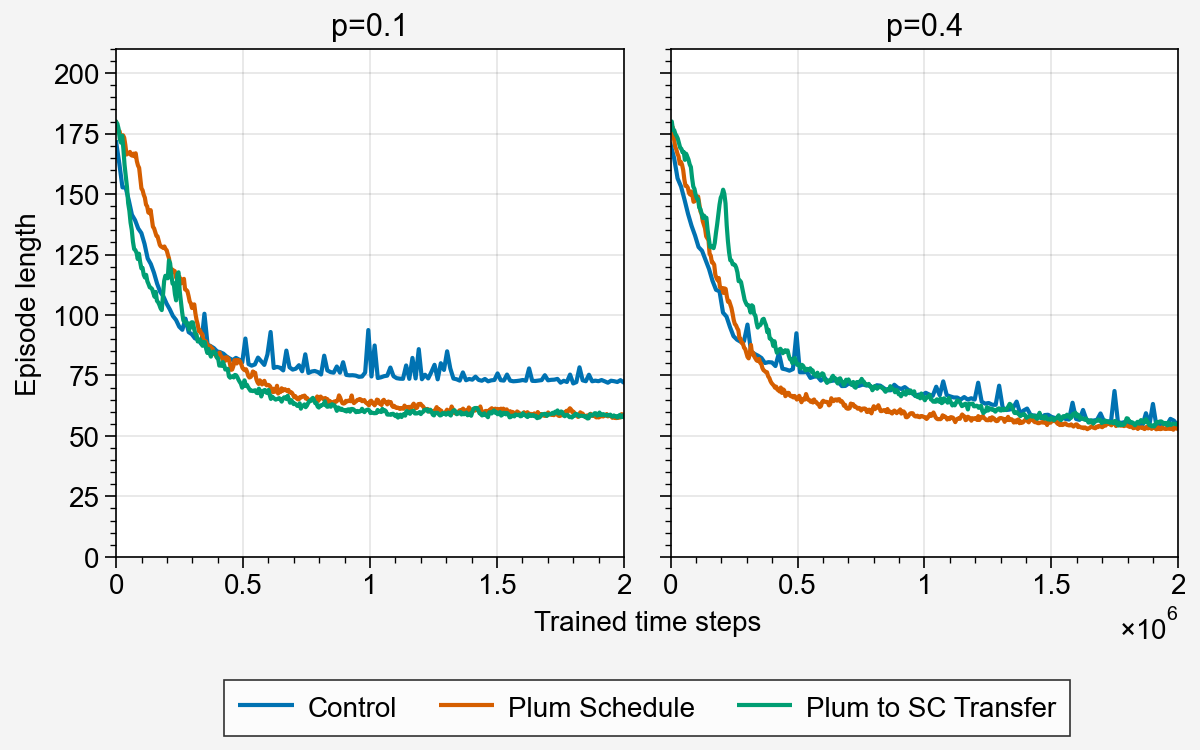

In [242]:
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')
folder2 = Path('data/shortcut/scwplum')
folder3 = Path('data/shortcut/plum2sc_policy')

summary = pickle.load(open(folder/'learning_curves', 'rb'))
summary2 = pickle.load(open(folder2/'learning_curves', 'rb'))
summary3 = pickle.load(open(folder3/'learning_curves', 'rb'))

fig, ax = pplt.subplots(ncols=2, figwidth=6)

for i, p in enumerate([0.1, 0.4]):
    lines = []
    
    x = summary[p]['x_grid']
    y = np.mean(summary[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000    
    lines.append(ax[i].plot(x_plot, y, label='Control'))

    x = summary2[p]['x_grid']
    y = np.mean(summary2[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, y, label='Plum Schedule'))
    
    x = summary3[f'1_{p}']['x_grid']
    y = np.mean(summary3[f'1_{p}']['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, y, label='Plum to SC Transfer'))

ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in [0.1, 0.4]], ylim=[0, 210])

ax[:, :-1].format(xlim=[0, 2])
ax[:, -1].format(xlim=[0, 2e6])
fig.legend(lines, loc='b')

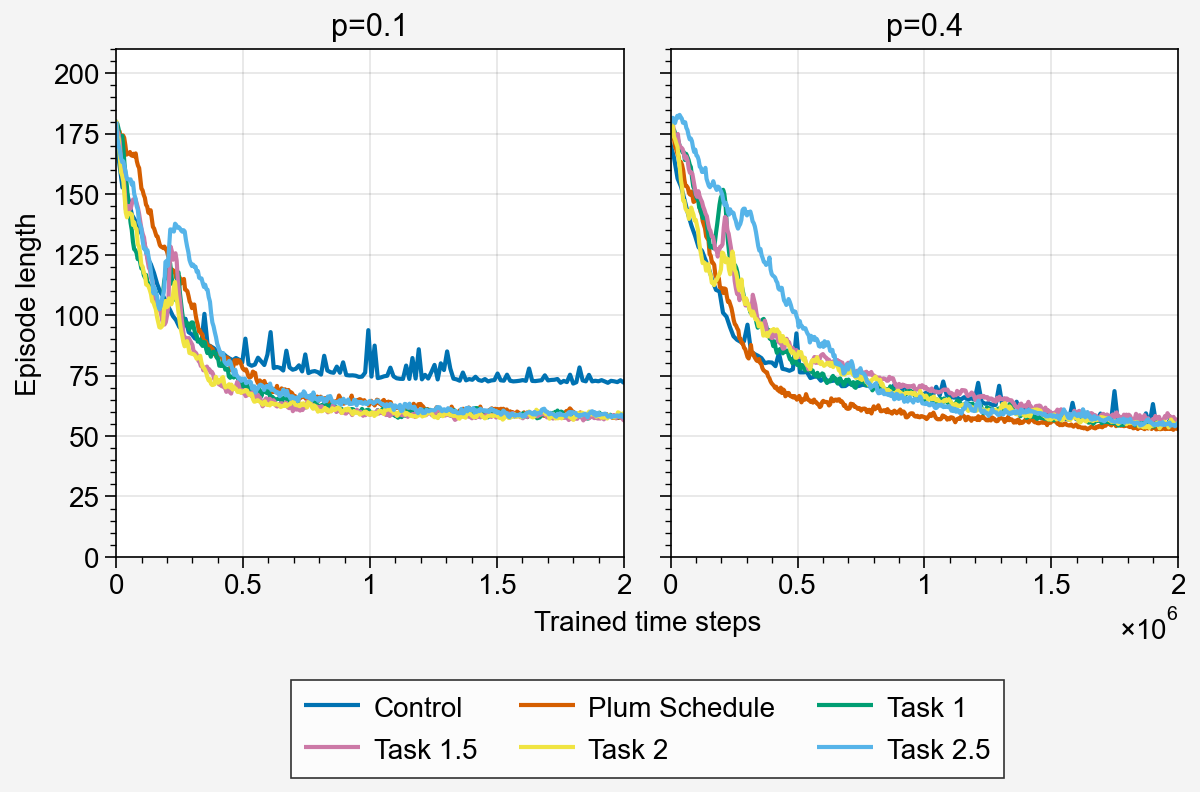

In [245]:
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')
folder2 = Path('data/shortcut/scwplum')
folder3 = Path('data/shortcut/plum2sc_policy')

summary = pickle.load(open(folder/'learning_curves', 'rb'))
summary2 = pickle.load(open(folder2/'learning_curves', 'rb'))
summary3 = pickle.load(open(folder3/'learning_curves', 'rb'))

fig, ax = pplt.subplots(ncols=2, figwidth=6)

for i, p in enumerate([0.1, 0.4]):
    lines = []
    
    x = summary[p]['x_grid']
    y = np.mean(summary[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000    
    lines.append(ax[i].plot(x_plot, y, label='Control'))

    x = summary2[p]['x_grid']
    y = np.mean(summary2[p]['y_grid'], axis=0)
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, y, label='Plum Schedule'))
    
    for task in tasks:
        x = summary3[f'{task}_{p}']['x_grid']
        y = np.mean(summary3[f'{task}_{p}']['y_grid'], axis=0)
        x_plot = x
        if i in [0]:
            x_plot = x_plot / 1000000
        lines.append(ax[i].plot(x_plot, y, label=f'Task {task}'))

ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in [0.1, 0.4]], ylim=[0, 210])

ax[:, :-1].format(xlim=[0, 2])
ax[:, -1].format(xlim=[0, 2e6])
fig.legend(lines, loc='b')

## Plum shortcut use testing

We tested a few different cloning methods and tasks, overall finding that 
* Cloning just the first two shared layers works best
* Not shuffling colors during pretraining steps works better as well

### Data collection

In [260]:
def get_first_last_performing_chks(task=1, p=0.4, t=0, verbose=False):
    '''Specific function for getting first and last checkpoints to test
    starting from first performing
    
    If return False, it means either not enough chks available or 
        never reached the required performance to start
    '''    
    # Get first checkpoint where performance is sufficient
    df = combine_cont_df(exp_format='plumtosc_sharedn_plumsched1_task{task}p{p}_t{t}',
                         formatter={'p': p, 't': t, 'task': task}, subdir='plumtosc')
    x, y = get_run_df_metric(df, ignore_first=1000)
    first_chk = get_first_shortcut_performance(x, y)
    
    exp_name = f'plumtosc_sharedn_plumsched1_task{task}p{p}_t{t}'
    
    folder = Path(f'../saved_checkpoints/plumtosc/{exp_name}')
    fnames = [f.name for f in folder.iterdir()]
    
    if verbose:
        print(f'{p}_{t}', first_chk)
    
    if first_chk is False:
        return False
    else:
        return first_chk



In [261]:
folder = Path('data/shortcut/plum2sc_policy')

probs = [0.1, 0.4]
tasks = [1, 1.5, 2, 2.5]
trials = range(3)

for task, p, t in tqdm(itertools.product(tasks, probs, trials), 
                       total=len(tasks)*len(probs)*len(trials)):    
    chks = get_first_last_performing_chks(task, p, t, False)
    if chks is False:
        continue
    
    chks = chks + chk_sched
    chk_folder = Path(f'../saved_checkpoints/plumtosc/plumtosc_sharedn_plumsched1_task{task}p{p}_t{t}')
    
    key = f'{task}_{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    
    for chk in chks:
        if not (chk_folder/f'{chk}.pt').exists():
            break
        
        exp_name = f'plumtosc/plumtosc_sharedn_plumsched1_task{task}p{p}'
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [10:55:46<00:00, 1639.44s/it]


In [262]:
def get_first_last_performing_chks(p=0.4, t=0, verbose=False):
    '''Specific function for getting first and last checkpoints to test
    starting from first performing
    
    If return False, it means either not enough chks available or 
        never reached the required performance to start
    '''    
    # Get first checkpoint where performance is sufficient
    df = combine_cont_df(exp_format='scwplum_schedule1p{p}_t{t}',
                         formatter={'p': p, 't': t}, subdir='scwplum')
    x, y = get_run_df_metric(df, ignore_first=1000)
    first_chk = get_first_shortcut_performance(x, y)
    
    exp_name = f'scwplum_schedule1p{p}_t{t}'
    
    folder = Path(f'../saved_checkpoints/scwplum/{exp_name}')
    fnames = [f.name for f in folder.iterdir()]
    
    if verbose:
        print(f'{p}_{t}', first_chk)
    
    if first_chk is False:
        return False
    else:
        return first_chk



In [263]:
folder = Path('data/shortcut/scwplum')

probs = [0.1, 0.4]
trials = range(3)

for p, t in tqdm(itertools.product(probs, trials), 
                       total=len(probs)*len(trials)):    
    chks = get_first_last_performing_chks(p, t, False)
    if chks is False:
        continue
    
    chks = chks + chk_sched
    chk_folder = Path(f'../saved_checkpoints/scwplum/scwplum_schedule1p{p}_t{t}')
    
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    
    for chk in chks:
        if not (chk_folder/f'{chk}.pt').exists():
            break
        
        exp_name = f'scwplum/scwplum_schedule1p{p}'
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 6/6 [48:44<00:00, 487.46s/it]


In [265]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)

folder = Path('data/shortcut/plum2sc_policy')

default = lambda: {
    'ns_lens': [],
    'ws_lens': [],
    'comb_lens': [],
    'surs': []
}

exps = [f.name for f in folder.iterdir()]

summary = defaultdict(default)
for task, p in itertools.product(tasks, probs):
    for t in trials:
        key = f'{task}_{p}_{t}'
        if key not in exps:
            continue

        all_res = pickle.load(open(folder/key, 'rb'))
        
        ns_lens = []
        ws_lens = []
        comb_lens = []
        surs = []
        
        for chk in all_res['ns']:
            ns_len = get_ep_lens(all_res['ns'][chk]['ep_pos'])
            ws_len = get_ep_lens(all_res['ws'][chk]['ep_pos'])
            shortcut_used = [check_shortcut_usage(p) for p in all_res['ws'][chk]['ep_pos']]
            shortcut_used = np.array(shortcut_used) & (np.array(ws_len) < 202)

            ns_lens.append(np.mean(ns_len))
            ws_lens.append(np.mean(ws_len))
            comb_lens.append(np.mean(ns_len + ws_len))
            surs.append(np.mean(shortcut_used))
        
        summ_key = f'{task}_{p}'
        summary[summ_key]['ns_lens'].append(ns_lens)
        summary[summ_key]['ws_lens'].append(ws_lens)
        summary[summ_key]['comb_lens'].append(comb_lens)
        summary[summ_key]['surs'].append(surs)
        
pickle.dump(dict(summary), open(folder/'summary', 'wb'))

In [ ]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)

folder = Path('data/shortcut/plum2sc_policy')

default = lambda: {
    'ns_lens': [],
    'ws_lens': [],
    'comb_lens': [],
    'surs': []
}

exps = [f.name for f in folder.iterdir()]

summary = defaultdict(default)
for task, p in itertools.product(tasks, probs):
    for t in trials:
        key = f'{task}_{p}_{t}'
        if key not in exps:
            continue

        all_res = pickle.load(open(folder/key, 'rb'))
        
        ns_lens = []
        ws_lens = []
        comb_lens = []
        surs = []
        
        for chk in all_res['ns']:
            ns_len = get_ep_lens(all_res['ns'][chk]['ep_pos'])
            ws_len = get_ep_lens(all_res['ws'][chk]['ep_pos'])
            shortcut_used = [check_shortcut_usage(p) for p in all_res['ws'][chk]['ep_pos']]
            shortcut_used = np.array(shortcut_used) & (np.array(ws_len) < 202)

            ns_lens.append(np.mean(ns_len))
            ws_lens.append(np.mean(ws_len))
            comb_lens.append(np.mean(ns_len + ws_len))
            surs.append(np.mean(shortcut_used))
        
        summ_key = f'{task}_{p}'
        summary[summ_key]['ns_lens'].append(ns_lens)
        summary[summ_key]['ws_lens'].append(ws_lens)
        summary[summ_key]['comb_lens'].append(comb_lens)
        summary[summ_key]['surs'].append(surs)
        
pickle.dump(dict(summary), open(folder/'summary', 'wb'))

In [266]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
trials = range(10)

folder = Path('data/shortcut/scwplum')

default = lambda: {
    'ns_lens': [],
    'ws_lens': [],
    'comb_lens': [],
    'surs': []
}

exps = [f.name for f in folder.iterdir()]

summary = defaultdict(default)
for p in tqdm(probs):
    for t in trials:
        key = f'{p}_{t}'
        if key not in exps:
            continue

        all_res = pickle.load(open(folder/key, 'rb'))
        
        ns_lens = []
        ws_lens = []
        comb_lens = []
        surs = []
        
        for chk in all_res['ns']:
            ns_len = get_ep_lens(all_res['ns'][chk]['ep_pos'])
            ws_len = get_ep_lens(all_res['ws'][chk]['ep_pos'])
            shortcut_used = [check_shortcut_usage(p) for p in all_res['ws'][chk]['ep_pos']]
            shortcut_used = np.array(shortcut_used) & (np.array(ws_len) < 202)

            ns_lens.append(np.mean(ns_len))
            ws_lens.append(np.mean(ws_len))
            comb_lens.append(np.mean(ns_len + ws_len))
            surs.append(np.mean(shortcut_used))
        
        summary[p]['ns_lens'].append(ns_lens)
        summary[p]['ws_lens'].append(ws_lens)
        summary[p]['comb_lens'].append(comb_lens)
        summary[p]['surs'].append(surs)
        
pickle.dump(dict(summary), open(folder/'summary', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:19<00:00,  2.44s/it]


### Plotting

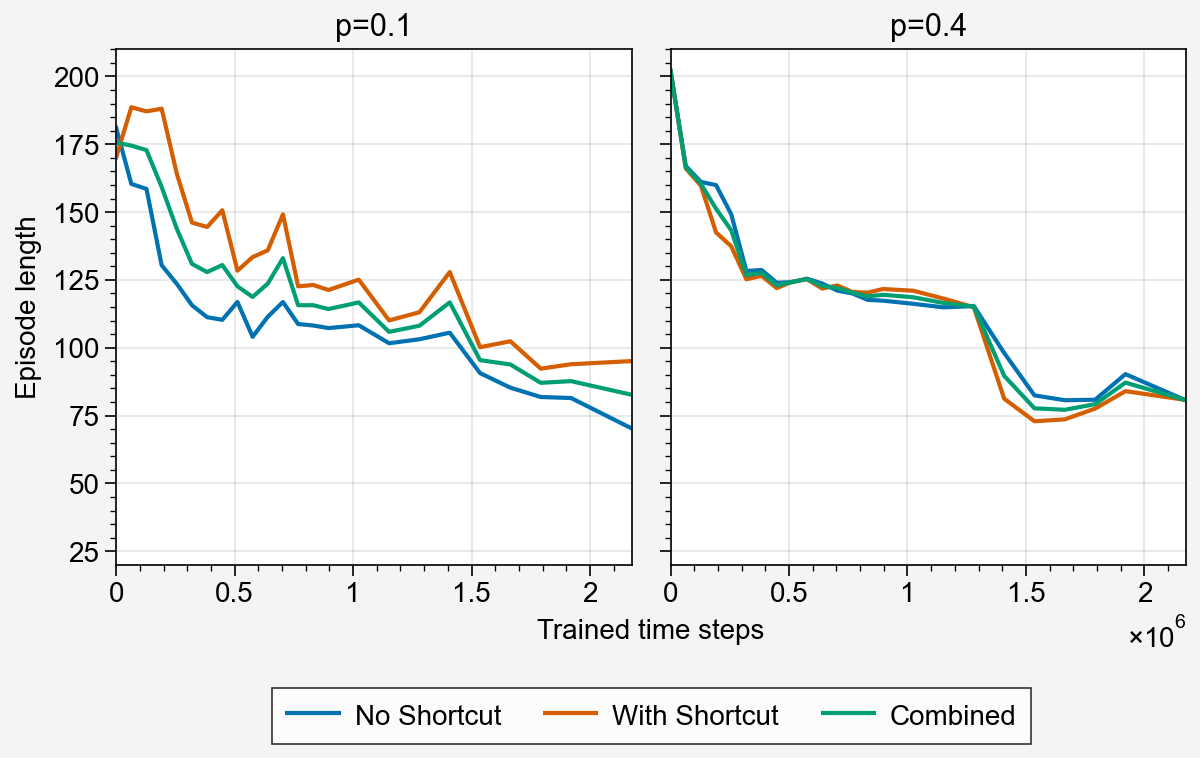

In [286]:
probs = [0.1, 0.4]
trials = range(10)
folder = Path('data/shortcut/scwplum')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=2, figwidth=6)

for i, p in enumerate(probs):
    lines = []
    
    num_chks = min([len(n) for n in summary[p]['ns_lens']])
    
    ns_lens = np.mean([n[:num_chks] for n in summary[p]['ns_lens']], axis=0)
    ws_lens = np.mean([n[:num_chks] for n in summary[p]['ws_lens']], axis=0)
    comb_lens = np.mean([ns_lens, ws_lens], axis=0)
    
    x = chk_sched[:num_chks] * 64 * 100
        
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, ns_lens, label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, ws_lens, label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, comb_lens, label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in probs], ylim=[20, 210])

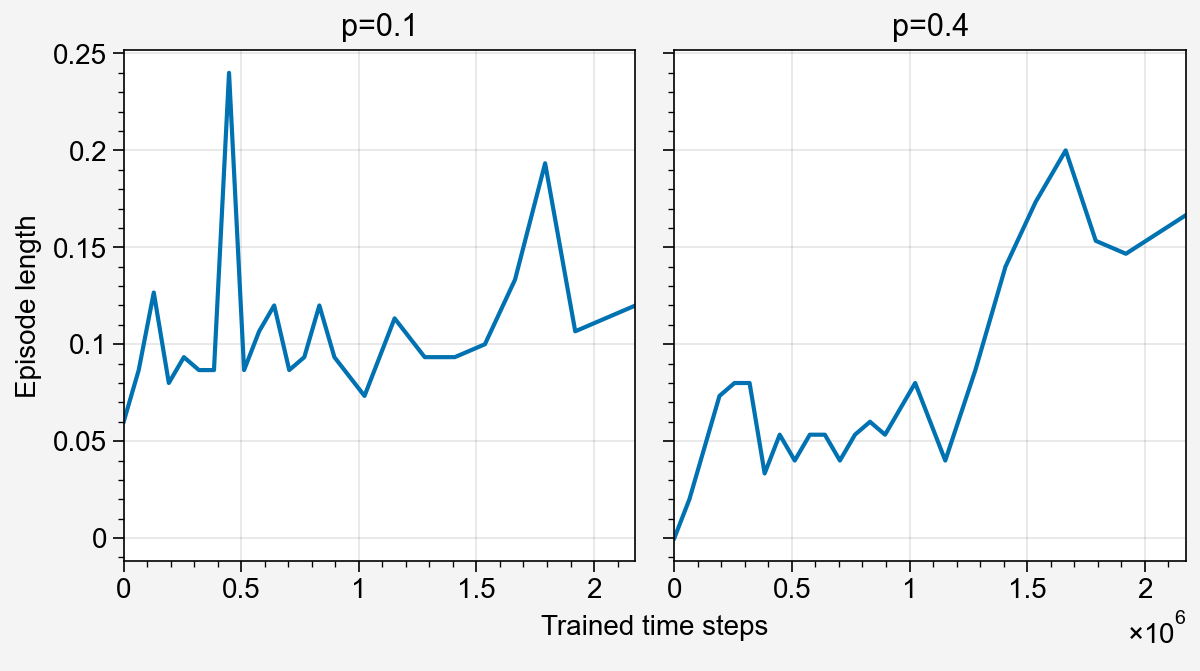

In [288]:
probs = [0.1, 0.4]
trials = range(10)
folder = Path('data/shortcut/scwplum')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=2, figwidth=6)

for i, p in enumerate(probs):
    lines = []
    
    num_chks = min([len(n) for n in summary[p]['surs']])
    surs = np.mean([n[:num_chks] for n in summary[p]['surs']], axis=0)
    
    x = chk_sched[:num_chks] * 64 * 100
        
    x_plot = x
    if i in [0]:
        x_plot = x_plot / 1000000
    lines.append(ax[i].plot(x_plot, surs))

ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in probs])

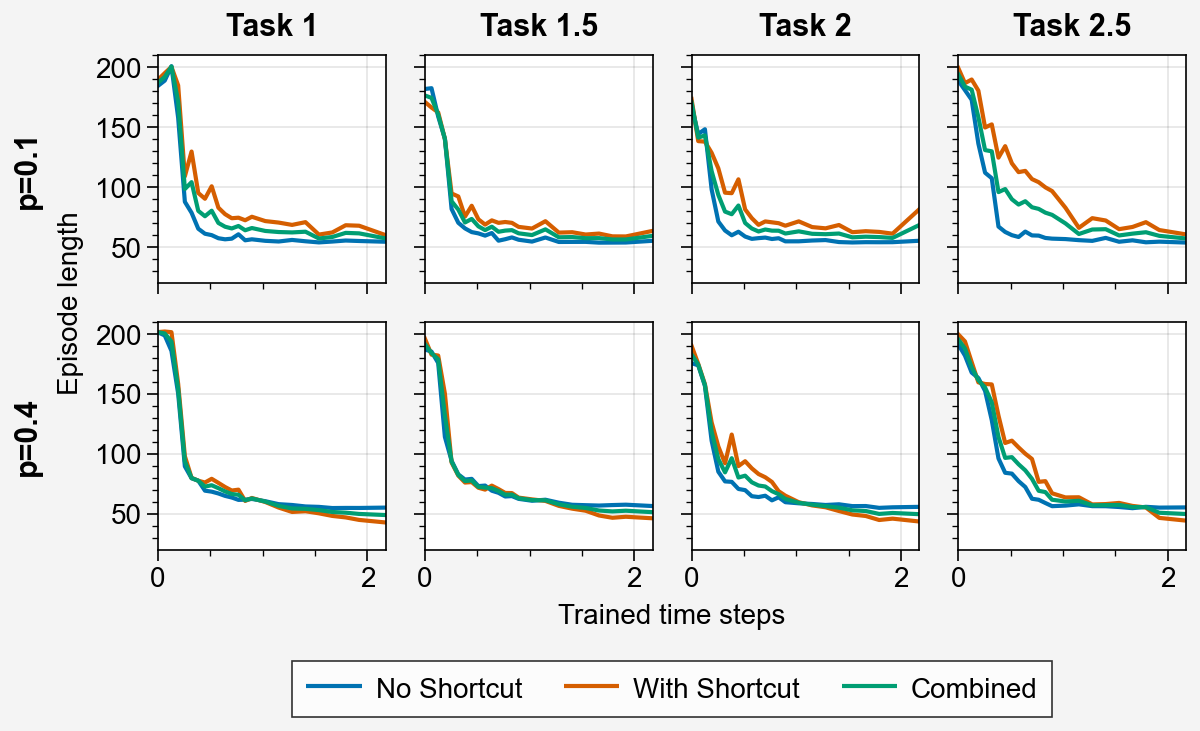

In [292]:
probs = [0.1, 0.4]
tasks = [1, 1.5, 2, 2.5]
trials = range(10)
folder = Path('data/shortcut/plum2sc_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

for i, p in enumerate(probs):
    for j, task in enumerate(tasks):
        key = f'{task}_{p}'
        lines = []

        num_chks = min([len(n) for n in summary[key]['ns_lens']])

        ns_lens = np.mean([n[:num_chks] for n in summary[key]['ns_lens']], axis=0)
        ws_lens = np.mean([n[:num_chks] for n in summary[key]['ws_lens']], axis=0)
        comb_lens = np.mean([ns_lens, ws_lens], axis=0)

        x = chk_sched[:num_chks] * 64 * 100

        x_plot = x
        if i in [0, 1, 2, 4, 5, 6]:
            x_plot = x_plot / 1000000
        lines.append(ax[i, j].plot(x_plot, ns_lens, label='No Shortcut'))
        lines.append(ax[i, j].plot(x_plot, ws_lens, label='With Shortcut'))
        lines.append(ax[i, j].plot(x_plot, comb_lens, label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          leftlabels=[f'p={p}' for p in probs], ylim=[20, 210],
          toplabels=[f'Task {task}' for task in tasks])

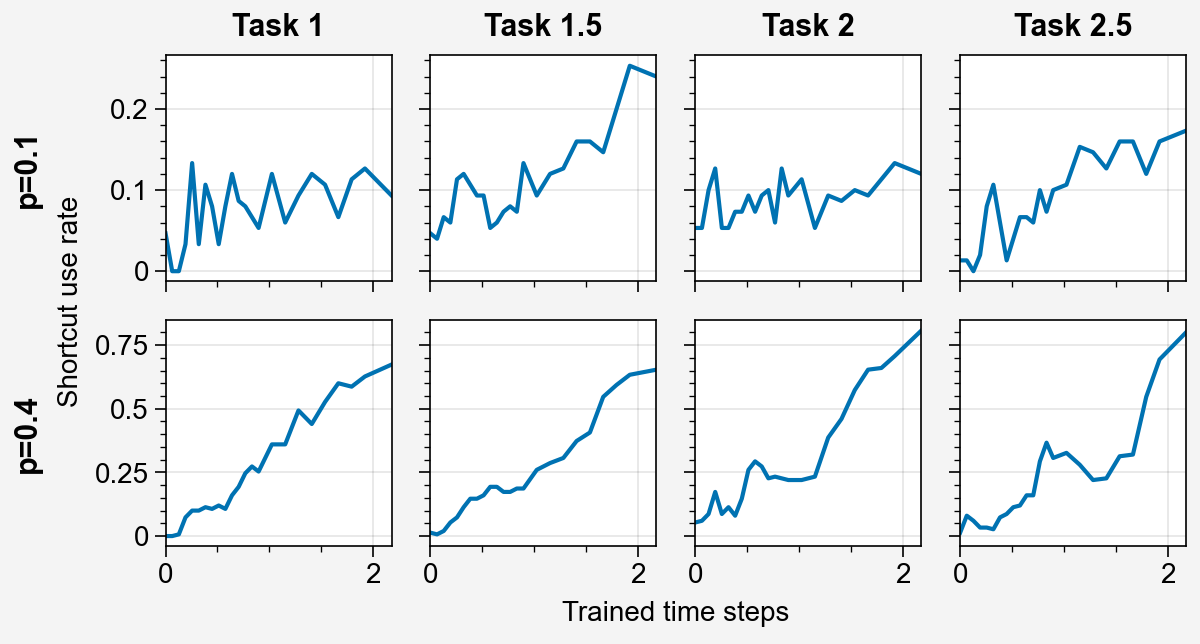

In [293]:
probs = [0.1, 0.4]
tasks = [1, 1.5, 2, 2.5]
trials = range(10)
folder = Path('data/shortcut/plum2sc_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

for i, p in enumerate(probs):
    for j, task in enumerate(tasks):
        key = f'{task}_{p}'
        lines = []

        num_chks = min([len(n) for n in summary[key]['surs']])

        surs = np.mean([n[:num_chks] for n in summary[key]['surs']], axis=0)

        x = chk_sched[:num_chks] * 64 * 100

        x_plot = x
        if i in [0, 1, 2, 4, 5, 6]:
            x_plot = x_plot / 1000000
        lines.append(ax[i, j].plot(x_plot, surs))

ax.format(xlabel='Trained time steps', ylabel='Shortcut use rate',
          leftlabels=[f'p={p}' for p in probs],
          toplabels=[f'Task {task}' for task in tasks])

## Late training comparisons

In [35]:
subdir = 'plumtosc'

tasks = [1.7, 1.8, 2.7, 2.8]
probs = [0.1, 0.4]
trials = range(3)

summary = {}

for task, p in tqdm(itertools.product(tasks, probs), total=len(tasks)*len(probs)):
    ns_lens = []
    ws_lens = []
    surs = []
    
    key = f'{task}_{p}'
    for t in trials:
        
        exp_format = 'plumtosc_shared_task{task}p{p}_t{t}'

        formatter = {'p': p, 'task': task, 't': t}
        exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

        first_chk, last_chk_sched_idx = get_first_last_performing_chks(exp_format=exp_format, formatter=formatter)
        chk = first_chk + chk_sched[last_chk_sched_idx]

        res = shortcut_test(exp_name, t, chk)

        ns_len = np.mean(get_ep_lens(res['ns'][0]['ep_pos']))
        ws_len = np.mean(get_ep_lens(res['ws'][0]['ep_pos']))
        sur = np.sum([check_shortcut_usage(p) for p in res['ws'][0]['ep_pos']]) / 50
        
        ns_lens.append(ns_len)
        ws_lens.append(ws_len)
        surs.append(sur)
        
    summary[key] = {
        'ns_lens': ns_lens,
        'ws_lens': ws_lens,
        'surs': surs
    }
    
folder = Path('data/shortcut/plum2sc_policy')
pickle.dump(summary, open(folder/'endsumm_tasks12', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:56<00:00, 22.05s/it]


In [144]:
subdir = 'plumtosc'

clones = ['sharedn', 'shared', 'actor0', 'actor1']
tasks = [1.7, 2.7]
probs = [0.1]
trials = range(3)

summary = {}

for clone, task, p in tqdm(itertools.product(clones, tasks, probs), total=len(clones)*len(tasks)*len(probs)):
    ns_lens = []
    ws_lens = []
    surs = []
    
    if clone == 'actor1' and task == 1.7:
        continue
    
    key = f'{clone}_{task}_{p}'
    for t in trials:
        
        exp_format = 'plumtosc_{clone}_task{task}p{p}_t{t}'

        formatter = {'p': p, 'task': task, 't': t, 'clone': clone}
        exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

        first_chk, last_chk_sched_idx = get_first_last_performing_chks(exp_format=exp_format, formatter=formatter)
        chk = first_chk + chk_sched[last_chk_sched_idx]

        res = shortcut_test(exp_name, t, chk)

        ns_len = np.mean(get_ep_lens(res['ns'][0]['ep_pos']))
        ws_len = np.mean(get_ep_lens(res['ws'][0]['ep_pos']))
        sur = np.sum([check_shortcut_usage(p) for p in res['ws'][0]['ep_pos']]) / 50
        
        ns_lens.append(ns_len)
        ws_lens.append(ws_len)
        surs.append(sur)
        
    summary[key] = {
        'ns_lens': ns_lens,
        'ws_lens': ws_lens,
        'surs': surs
    }
    
folder = Path('data/shortcut/plum2sc_policy')
pickle.dump(summary, open(folder/'endsumm_clone', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:01<00:00, 30.22s/it]


In [101]:
subdir = 'plumtosc'

task_probs = [0.1, 0.4, 0.8]
probs = [0.1, 0.4]
trials = range(3)

summary = {}

for tp, p in tqdm(itertools.product(task_probs, probs), total=len(task_probs)*len(probs)):
    ns_lens = []
    ws_lens = []
    surs = []
    
    key = f'{tp}_{p}'
    for t in trials:
        
        exp_format = 'plumtosc_shared_task3tp{tp}p{p}_t{t}'

        formatter = {'p': p, 'tp': tp, 't': t}
        exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

        first_chk, last_chk_sched_idx = get_first_last_performing_chks(exp_format=exp_format, formatter=formatter)
        chk = first_chk + chk_sched[last_chk_sched_idx]

        res = shortcut_test(exp_name, t, chk)

        ns_len = np.mean(get_ep_lens(res['ns'][0]['ep_pos']))
        ws_len = np.mean(get_ep_lens(res['ws'][0]['ep_pos']))
        sur = np.sum([check_shortcut_usage(p) for p in res['ws'][0]['ep_pos']]) / 50
        
        ns_lens.append(ns_len)
        ws_lens.append(ws_len)
        surs.append(sur)
        
    summary[key] = {
        'ns_lens': ns_lens,
        'ws_lens': ws_lens,
        'surs': surs
    }

folder = Path('data/shortcut/plum2sc_policy')
pickle.dump(summary, open(folder/'endsumm_task3', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:06<00:00, 31.05s/it]


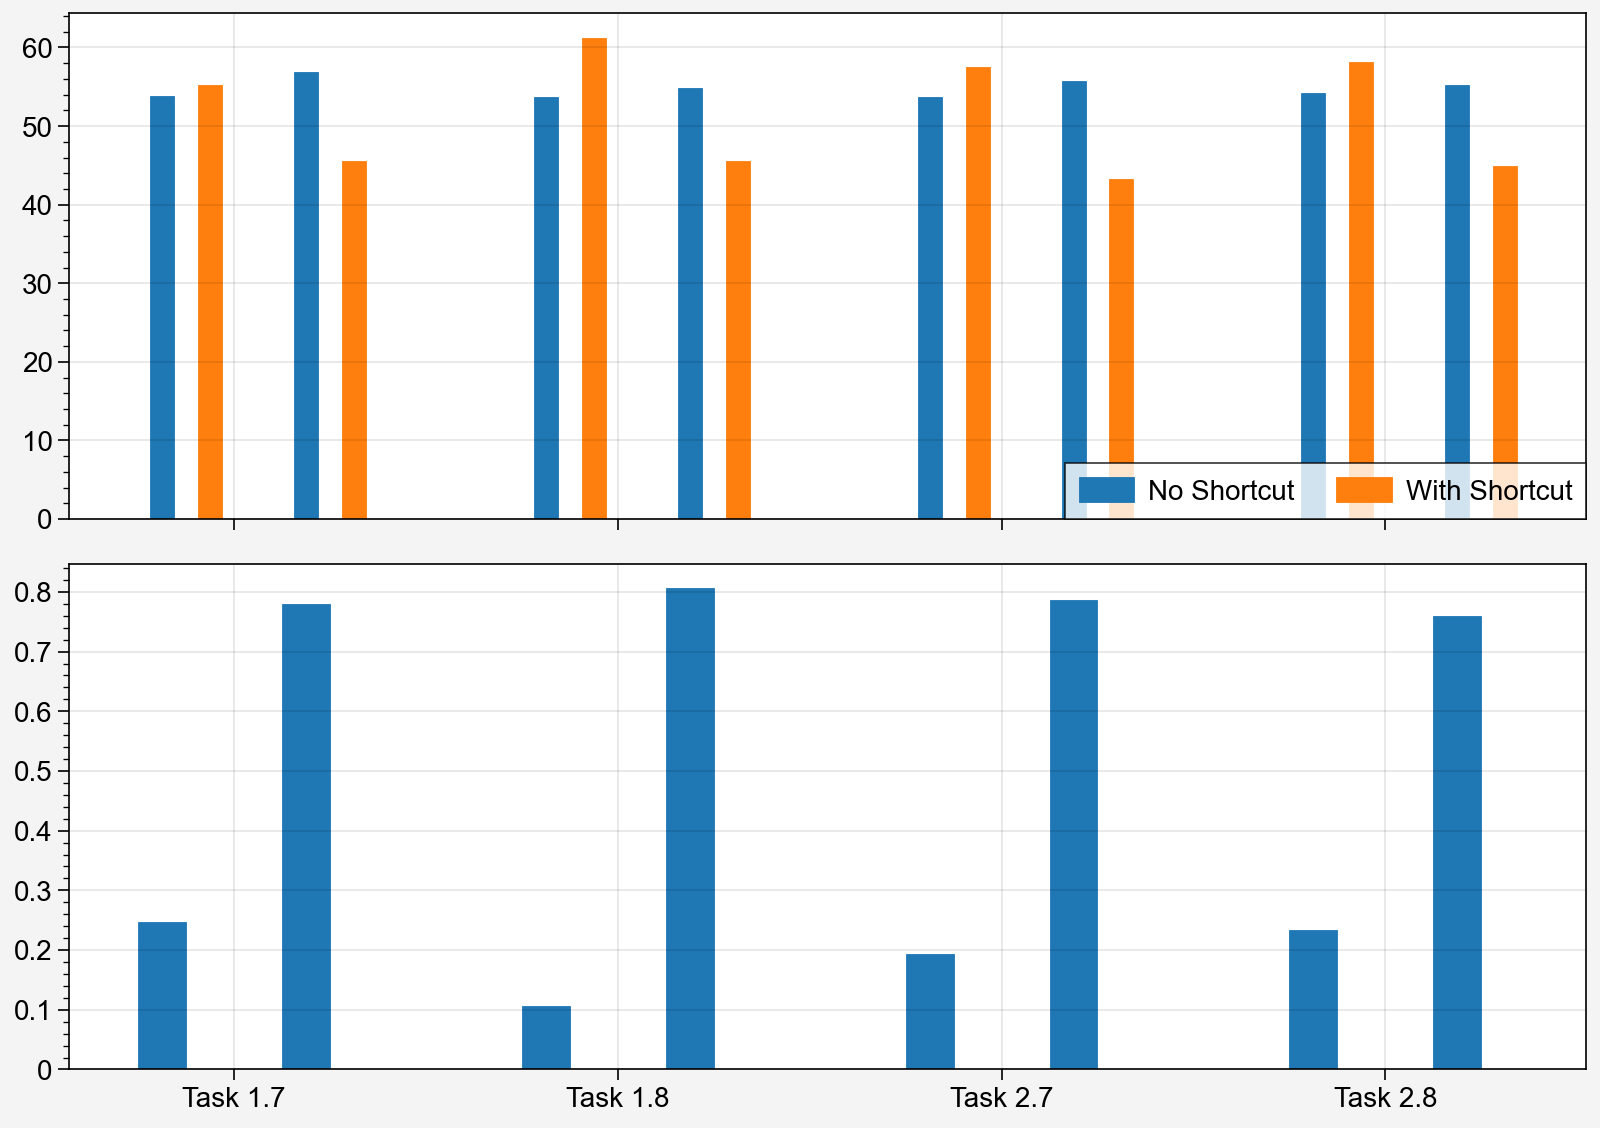

In [98]:
folder = Path('data/shortcut/plum2sc_policy')
summ12 = pickle.load(open(folder/'endsumm_tasks12', 'rb'))

tasks = [1.7, 1.8, 2.7, 2.8]
probs = [0.1, 0.4]

fig, ax = pplt.subplots(nrows=2, refaspect=3, figwidth=8)

x = 0

n_x = []
n_y = []
w_x = []
w_y = []
for i, task in enumerate(tasks):
    for j, p in enumerate(probs):
        bars = []
        
        key = f'{task}_{p}'
        
        n_len = np.mean(summ12[key]['ns_lens'])
        w_len = np.mean(summ12[key]['ws_lens'])
        sur = np.mean(summ12[key]['surs'])
        
        n_x.append(x)
        n_y.append(n_len)
        w_x.append(x+1)
        w_y.append(w_len)
        
        bars.append(ax[0].bar([x], [n_len], width=1, color=rgb_colors[0],
                              label='No Shortcut'))
        bars.append(ax[0].bar([x+1], [w_len], width=1, color=rgb_colors[1],
                              label='With Shortcut'))
        ax[1].bar([x], [sur], width=2, color=rgb_colors[0])
        
        x += 3
    x += 2
    
ax[0].legend(bars, loc='lr')

ax.format(xlocator=np.arange(1.5, 36, 8), xformatter=[f'Task {task}' for task in tasks])


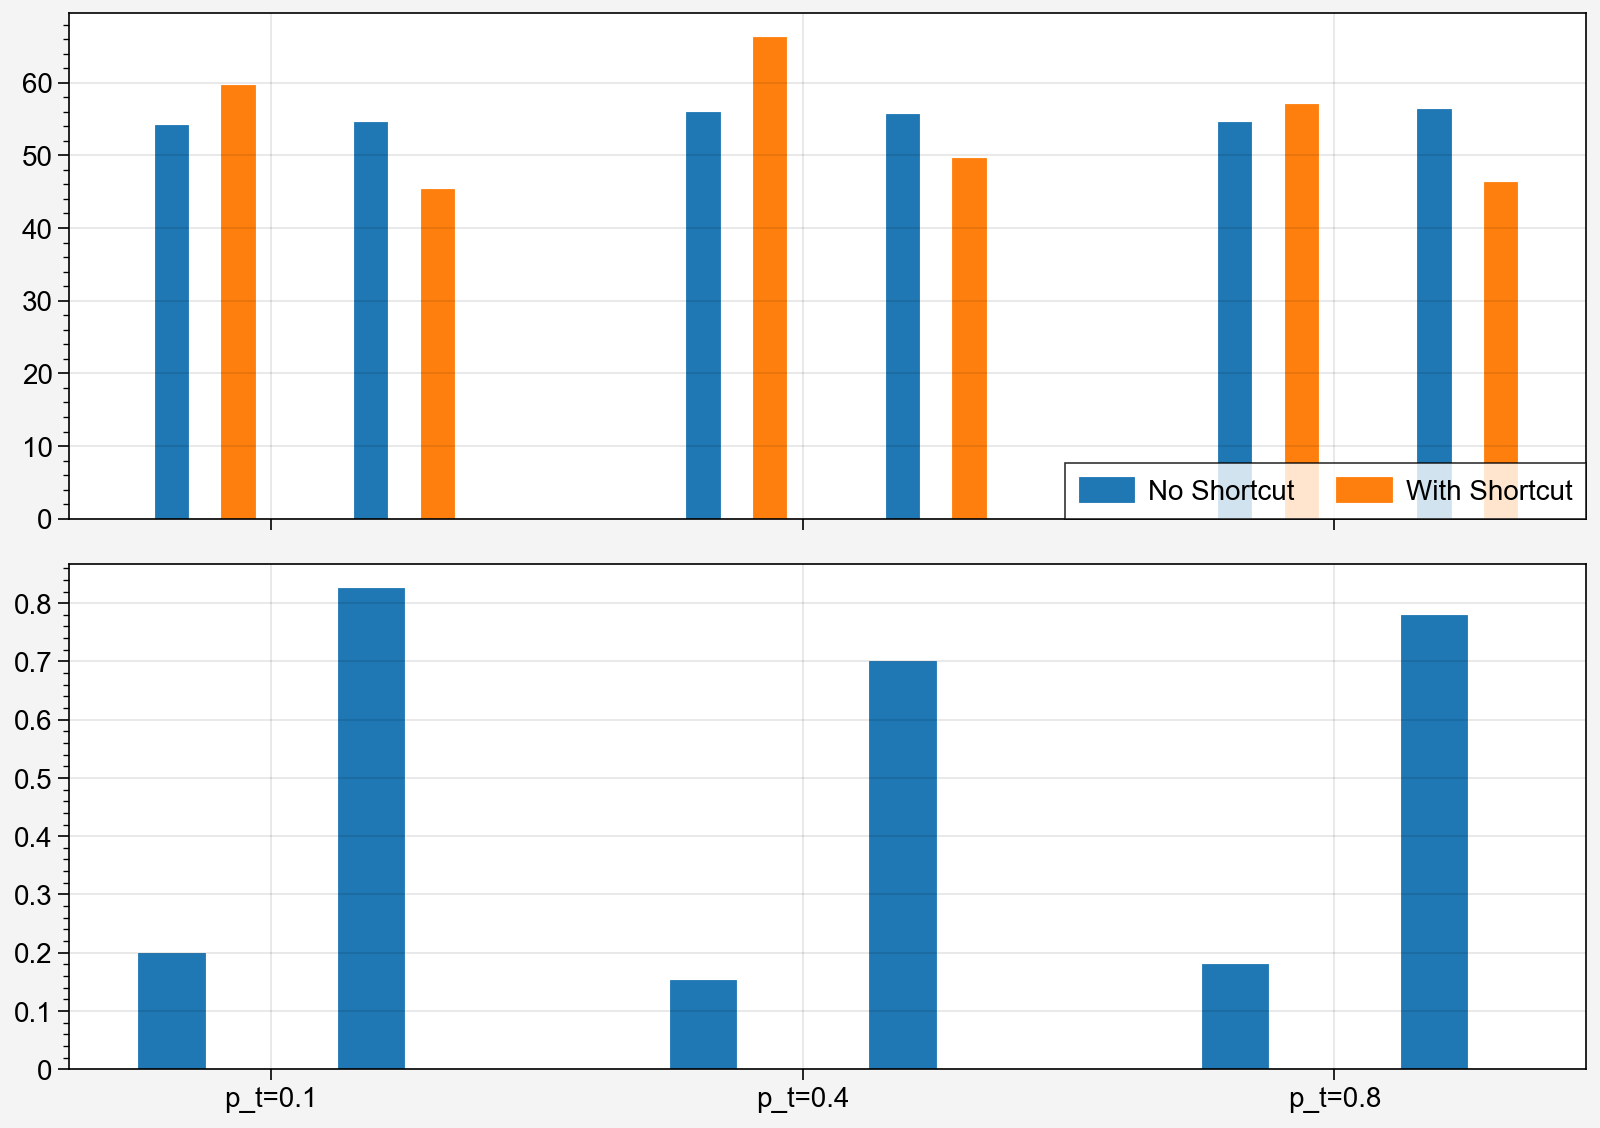

In [102]:
folder = Path('data/shortcut/plum2sc_policy')
summ3 = pickle.load(open(folder/'endsumm_task3', 'rb'))

task_probs = [0.1, 0.4, 0.8]
probs = [0.1, 0.4]

fig, ax = pplt.subplots(nrows=2, refaspect=3, figwidth=8)

x = 0

n_x = []
n_y = []
w_x = []
w_y = []
for i, tp in enumerate(task_probs):
    for j, p in enumerate(probs):
        bars = []
        
        key = f'{tp}_{p}'
        
        n_len = np.mean(summ3[key]['ns_lens'])
        w_len = np.mean(summ3[key]['ws_lens'])
        sur = np.mean(summ3[key]['surs'])
        
        n_x.append(x)
        n_y.append(n_len)
        w_x.append(x+1)
        w_y.append(w_len)
        
        bars.append(ax[0].bar([x], [n_len], width=1, color=rgb_colors[0],
                              label='No Shortcut'))
        bars.append(ax[0].bar([x+1], [w_len], width=1, color=rgb_colors[1],
                              label='With Shortcut'))
        ax[1].bar([x], [sur], width=2, color=rgb_colors[0])
        
        x += 3
    x += 2
    
ax[0].legend(bars, loc='lr')

ax.format(xlocator=np.arange(1.5, 26, 8), xformatter=[f'p_t={tp}' for tp in task_probs])


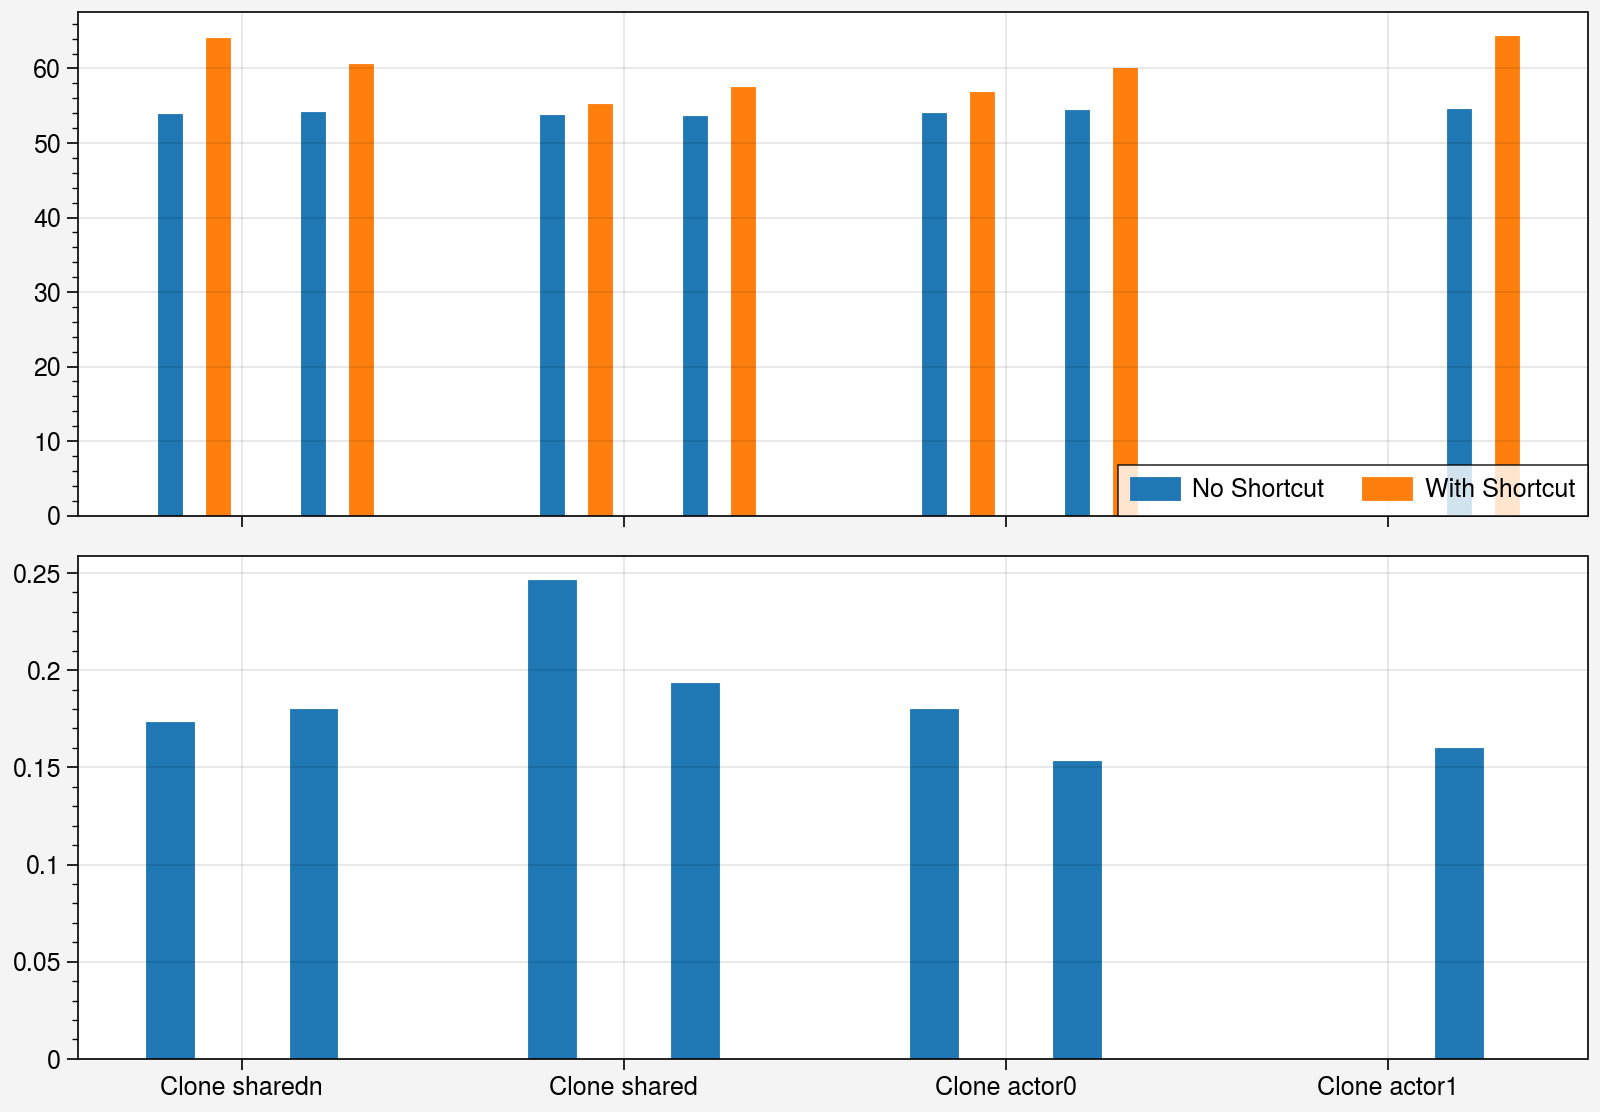

In [145]:
folder = Path('data/shortcut/plum2sc_policy')
summ12 = pickle.load(open(folder/'endsumm_clone', 'rb'))

clones = ['sharedn', 'shared', 'actor0', 'actor1']
tasks = [1.7, 2.7]
probs = [0.1]

fig, ax = pplt.subplots(nrows=2, refaspect=3, figwidth=8)

x = 0

n_x = []
n_y = []
w_x = []
w_y = []
p = 0.1
for i, clone in enumerate(clones):
    for i, task in enumerate(tasks):
        if clone == 'actor1' and task == 1.7:
            x += 3
            continue
        
        bars = []
        
        key = f'{clone}_{task}_{p}'
        
        n_len = np.mean(summ12[key]['ns_lens'])
        w_len = np.mean(summ12[key]['ws_lens'])
        sur = np.mean(summ12[key]['surs'])
        
        n_x.append(x)
        n_y.append(n_len)
        w_x.append(x+1)
        w_y.append(w_len)
        
        bars.append(ax[0].bar([x], [n_len], width=1, color=rgb_colors[0],
                              label='No Shortcut'))
        bars.append(ax[0].bar([x+1], [w_len], width=1, color=rgb_colors[1],
                              label='With Shortcut'))
        ax[1].bar([x], [sur], width=2, color=rgb_colors[0])
        
        x += 3
    x += 2
    
ax[0].legend(bars, loc='lr')

ax.format(xlocator=np.arange(1.5, 36, 8), xformatter=[f'Clone {clone}' for clone in clones])


### Comparison of learning curves with transfer

In [108]:
'''Generate shifted learning curves'''

summ = {}

tasks = [1.7, 1.8, 2.7, 2.8]
probs = [0.1, 0.4]
trials = range(3)
exp_format = 'plumtosc_shared_task{task}p{p}_t{t}'

for task, p in itertools.product(tasks, probs):
    key = f'{task}_{p}'
    xs = []
    ys = []
    for t in trials:
        formatter = {'task': task, 'p': p, 't': t}
        
        df = combine_cont_df(exp_format=exp_format,
                             formatter=formatter, subdir='plumtosc')
        
        x, y = get_run_df_metric(df, ignore_first=1000)
        first = get_first_shortcut_performance(x, y, ret_chk=False)

        if not first:
            continue

        xs.append(x[first:]-x[first])
        ys.append(y[first:])
        
    xmin = int(np.min([min(x) for x in xs]))
    xmax = int(np.min([max(x) for x in xs]))
    x_grid = np.linspace(xmin, xmax, 500)
    inters = [scipy.interpolate.interp1d(xs[i], ys[i]) for i in range(len(xs))]
    y_grid = [inters[i](x_grid) for i in range(len(xs))]
    
    summ[key] = {
        'xs': xs,
        'ys': ys,
        'x_grid': x_grid,
        'y_grid': y_grid
    }
    
pickle.dump(summ, open('data/shortcut/plum2sc_policy/12_learning_curves', 'wb'))

    

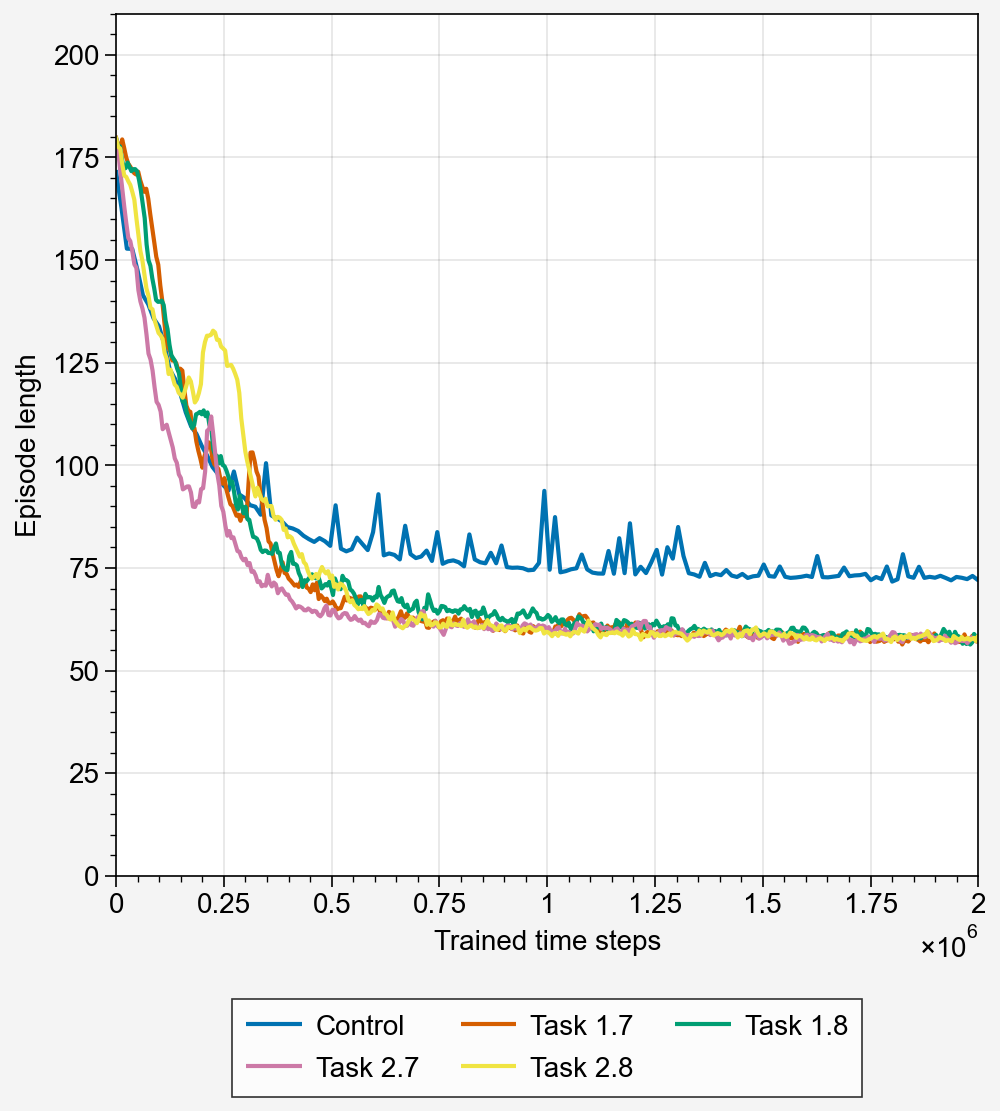

In [119]:
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'learning_curves', 'rb'))

fig, ax = pplt.subplots(figwidth=5)

lines = []
x = summary[p]['x_grid']
y = np.mean(summary[p]['y_grid'], axis=0)
lines.append(ax.plot(x, y, label='Control'))


folder = Path('data/shortcut/plum2sc_policy')
summary = pickle.load(open(folder/'12_learning_curves', 'rb'))

for task in tasks:
    key = f'{task}_0.1'
    x = summary[key]['x_grid']
    y = np.mean(summary[key]['y_grid'], axis=0)
    lines.append(ax.plot(x, y, label=f'Task {task}'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          ylim=[0, 210], xlim=[0, 2e6])


## SC w/plum

### WS/NS policy

In [84]:
folder = Path('data/shortcut/scwplum_policy')

p = 0.1
trials = range(10)

exp_format = 'scwplum_p{p}_t{t}'
cont_format = 'scwplum_p{p}_cont_t{t}'
subdir = 'scwplum'
for t in tqdm(trials):
    formatter = {'t': t, 'p': 0.1}
    chks = get_first_last_performing_chks(exp_format=exp_format, cont_format=cont_format,
                                          subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        all_res = pickle.load(open(folder/key, 'rb'))
    else:
        all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:03:01<00:00, 378.14s/it]


### WS/NS copied

In [81]:
folder = Path('data/shortcut/scwplum_copied')

p = 0.1
trials = range(10)

exp_format = 'scwplum_p{p}_t{t}'
cont_format = 'scwplum_p{p}_cont_t{t}'
subdir = 'scwplum'
for t in tqdm(trials):
    formatter = {'t': t, 'p': 0.1}
    chks = get_first_last_performing_chks(exp_format=exp_format, cont_format=cont_format,
                                          subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{p}_{t}'
    if key in os.listdir(folder):
        all_res = pickle.load(open(folder/key, 'rb'))
    else:
        all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk, with_fa=True)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [43:44<00:00, 262.41s/it]


## Plum2sc WS/NS

### Task 1.7/2.7

In [96]:
folder = Path('data/shortcut/plum2sc_policy')

clones = ['shared']
tasks = [1.7, 2.7]
p = 0.1
trials = range(10)

exp_format = 'plumtosc_shared_task{task}p{p}_t{t}'
subdir = 'plumtosc'
for task, t in tqdm(itertools.product(tasks, trials), 
                           total=len(tasks)*len(trials)):
    formatter = {'t': t, 'p': p, 'task': task}
    chks = get_first_last_performing_chks(exp_format=exp_format, subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{task}_{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [10:51:49<00:00, 1955.45s/it]


### Task 1.7/2.7 copied

In [82]:
folder = Path('data/shortcut/plum2sc_copied')

clones = ['shared']
tasks = [1.7, 2.7]
p = 0.1
trials = range(10)

exp_format = 'plumtosc_shared_task{task}p{p}_t{t}'
subdir = 'plumtosc'
for task, t in tqdm(itertools.product(tasks, trials), 
                           total=len(tasks)*len(trials)):
    formatter = {'t': t, 'p': p, 'task': task}
    chks = get_first_last_performing_chks(exp_format=exp_format, subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{task}_{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk, with_fa=True)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:32:04<00:00, 276.20s/it]


### Task 3 p0.1, 0.4

In [86]:
folder = Path('data/shortcut/plum2sc_policy')

task_probs = [0.1, 0.4]
p = 0.1
trials = range(10)

exp_format = 'plumtosc_shared_task3tp{tp}p{p}_t{t}'
subdir = 'plumtosc'
for tp, t in tqdm(itertools.product(task_probs, trials), 
                           total=len(task_probs)*len(trials)):
    formatter = {'tp': tp, 'p': p, 't': t, 'task': 3}
    chks = get_first_last_performing_chks(exp_format=exp_format, subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'3_{tp}_{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [3:59:09<00:00, 717.49s/it]


### Task 3 p0.1, 0.4, copied

In [87]:
folder = Path('data/shortcut/plum2sc_copied')

task_probs = [0.1, 0.4]
p = 0.1
trials = range(10)

exp_format = 'plumtosc_shared_task3tp{tp}p{p}_t{t}'
subdir = 'plumtosc'
for tp, t in tqdm(itertools.product(task_probs, trials), 
                           total=len(task_probs)*len(trials)):
    formatter = {'tp': tp, 'p': p, 't': t, 'task': 3}
    chks = get_first_last_performing_chks(exp_format=exp_format, subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'3_{tp}_{p}_{t}'
    if key in os.listdir(folder):
        continue
    
    all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk, with_fa=True)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|█████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:42:55<00:00, 308.78s/it]


In [2]:
folder = Path('data/shortcut/plum2sc_policy')

keys = ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
labels = ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze']
trials = range(10)

default = lambda: {
    'ns_lens': [],
    'ws_lens': [],
    'comb_lens': [],
    'surs': []
}

exps = [f.name for f in folder.iterdir()]

summary = defaultdict(default)
for key in tqdm(keys):
    for t in trials:
        tkey = f'{key}_{t}'
        if tkey not in exps:
            continue

        all_res = pickle.load(open(folder/tkey, 'rb'))
        
        ns_lens = []
        ws_lens = []
        comb_lens = []
        surs = []
        
        for chk in all_res['ns']:
            ns_len = get_ep_lens(all_res['ns'][chk]['ep_pos'])
            ws_len = get_ep_lens(all_res['ws'][chk]['ep_pos'])
            shortcut_used = [check_shortcut_usage(p) for p in all_res['ws'][chk]['ep_pos']]
            shortcut_used = np.array(shortcut_used) & (np.array(ws_len) < 202)

            ns_lens.append(np.mean(ns_len))
            ws_lens.append(np.mean(ws_len))
            comb_lens.append(np.mean(ns_len + ws_len))
            surs.append(np.mean(shortcut_used))
        
        summary[key]['ns_lens'].append(ns_lens)
        summary[key]['ws_lens'].append(ws_lens)
        summary[key]['comb_lens'].append(comb_lens)
        summary[key]['surs'].append(surs)
        
pickle.dump(dict(summary), open(folder/'summary', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:07<00:00, 16.96s/it]


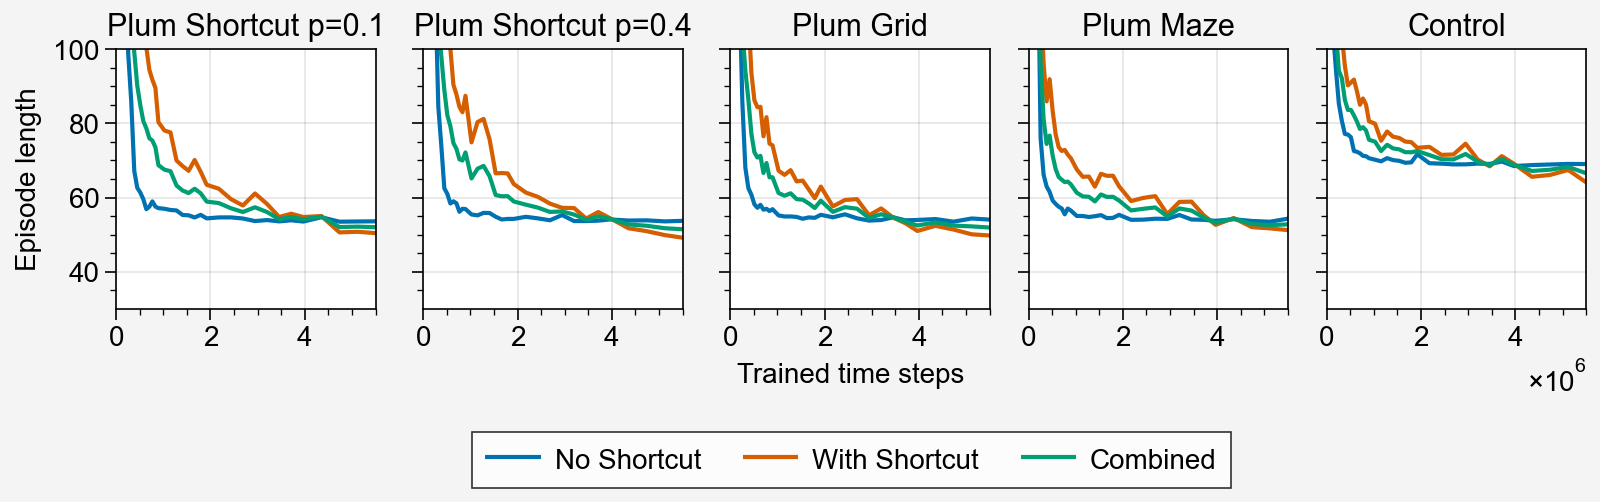

In [3]:
folder = Path('data/shortcut/plum2sc_policy')

keys = ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
labels = ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze']
trials = range(3)

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=5, figwidth=8)

for i, key in enumerate(keys):
    lines = []
    
    num_chks = min([len(p) for p in summary[key]['ns_lens']])
    ns_lens = np.mean([n[:num_chks] for n in summary[key]['ns_lens']], axis=0)
    ws_lens = np.mean([n[:num_chks] for n in summary[key]['ws_lens']], axis=0)
    comb_lens = np.mean([ns_lens, ws_lens], axis=0)
    
    x_plot = chk_sched[:num_chks] * 64 * 100 / 1000000
    
    lines.append(ax[i].plot(x_plot, ns_lens, label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, ws_lens, label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, comb_lens, label='Combined'))

    
# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
x_plot = chk_sched * 64 * 100
p = 0.1
ax[-1].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='No Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='With Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined')

    
fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=labels+['Control'], ylim=[30, 100])
ax[:-1].format(xlim=[0, 5.5])
ax[-1].format(xlim=[0, 5.5e6])

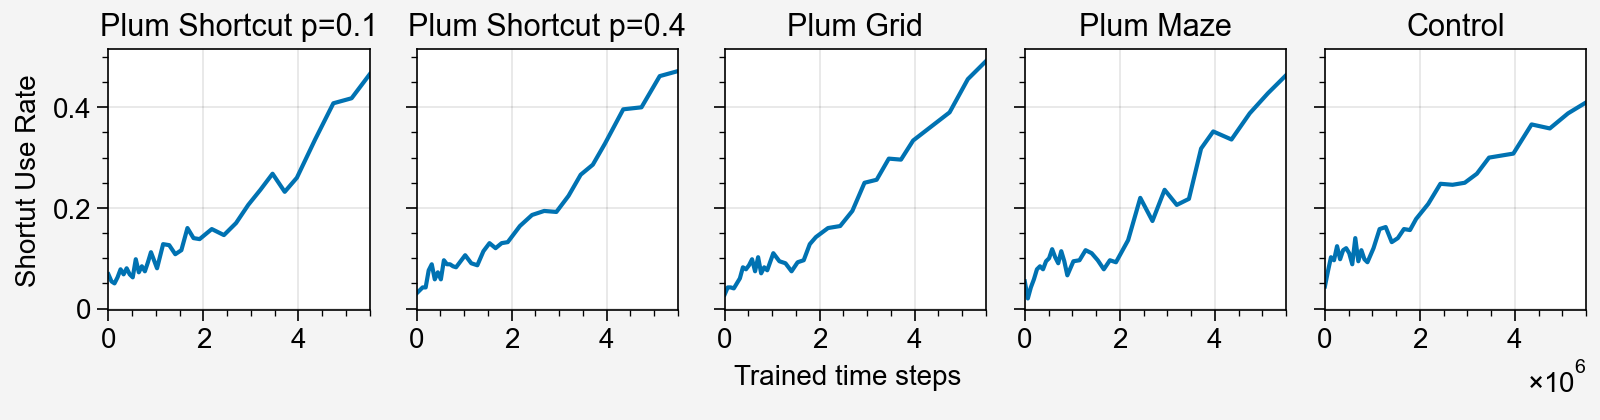

In [4]:
folder = Path('data/shortcut/plum2sc_policy')

keys = ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
labels = ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze']
trials = range(3)

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=5, figwidth=8)

for i, key in enumerate(keys):
    lines = []
    
    num_chks = min([len(p) for p in summary[key]['surs']])
    surs = np.mean([n[:num_chks] for n in summary[key]['surs']], axis=0)
    
    x_plot = chk_sched[:num_chks] * 64 * 100 / 1000000
    
    lines.append(ax[i].plot(x_plot, surs))

    
# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
x_plot = chk_sched * 64 * 100
p = 0.1
ax[-1].plot(x_plot, np.mean(summary[p]['surs'], axis=0))

ax.format(xlabel='Trained time steps', ylabel='Shortut Use Rate',
          title=labels+['Control'])
ax[:-1].format(xlim=[0, 5.5])
ax[-1].format(xlim=[0, 5.5e6])

# SC Aux

## Late training bars

In [147]:
aux = 'catfacewall'
exp_format = 'shortcut_wc1.5p{p}_aux{aux}_t{t}'

formatter = {'p': p, 'aux': aux, 't': t}
exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

first_chk, last_chk_sched_idx = get_first_last_performing_chks(
    exp_format=exp_format, formatter=formatter, subdir='shortcut_aux')


In [7]:
subdir = 'shortcut_aux'

aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
probs = [0.1]
trials = range(5)

summary = {}

for aux, p in tqdm(itertools.product(aux_tasks, probs), total=len(aux_tasks)*len(probs)):
    ns_lens = []
    ws_lens = []
    surs = []
        
    key = f'{aux}_{p}'
    for t in trials:
        
        exp_format = 'shortcut_wc1.5p{p}_aux{aux}_t{t}'
        cont_format = 'shortcut_wc1.5p{p}_aux{aux}_cont_t{t}'
        formatter = {'p': p, 'aux': aux, 't': t}
        exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

        first_chk, last_chk_sched_idx = get_first_last_performing_chks(exp_format=exp_format, 
                                                                       cont_format=cont_format,
                                                                       formatter=formatter,
                                                                      subdir='shortcut_aux')
        chk = first_chk + chk_sched[last_chk_sched_idx]

        res = shortcut_test(exp_name, t, chk)

        ns_len = np.mean(get_ep_lens(res['ns'][0]['ep_pos']))
        ws_len = np.mean(get_ep_lens(res['ws'][0]['ep_pos']))
        sur = np.sum([check_shortcut_usage(p) for p in res['ws'][0]['ep_pos']]) / 50
        
        ns_lens.append(ns_len)
        ws_lens.append(ws_len)
        surs.append(sur)
        
    summary[key] = {
        'ns_lens': ns_lens,
        'ws_lens': ws_lens,
        'surs': surs
    }
    
folder = Path('data/shortcut/sc_aux')
pickle.dump(summary, open(folder/'endsumm', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:55<00:00, 58.77s/it]


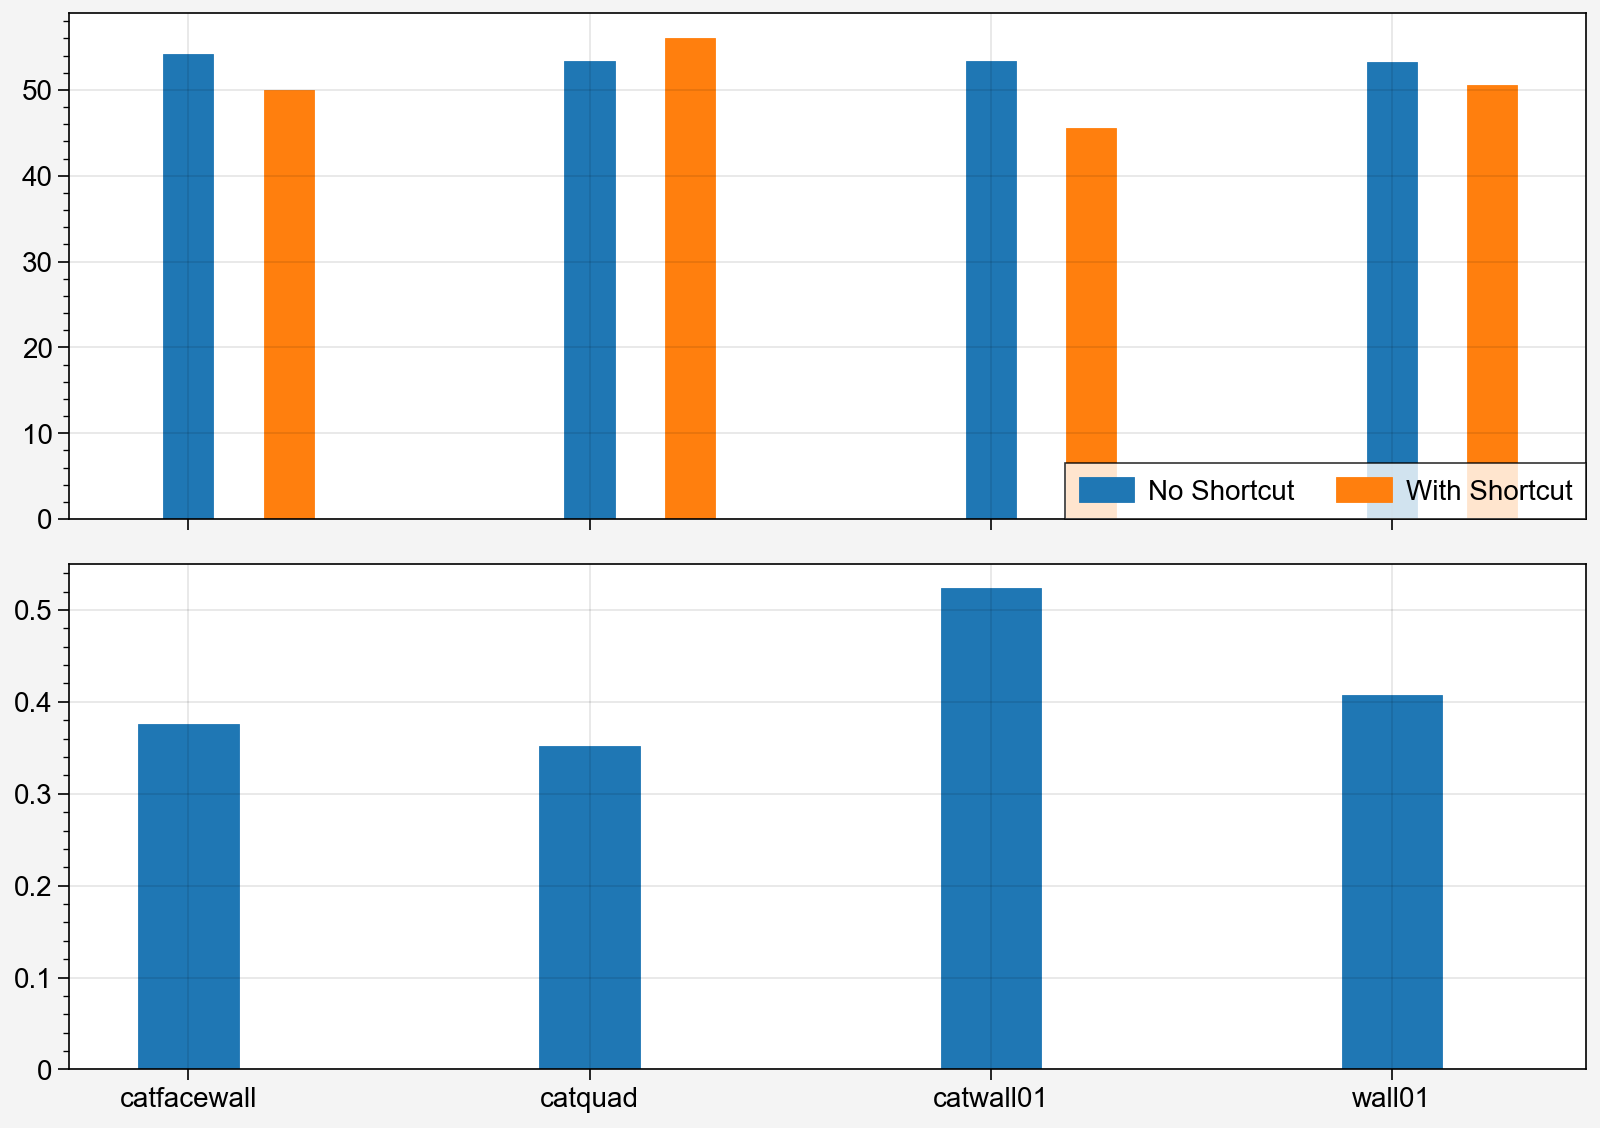

In [11]:
folder = Path('data/shortcut/sc_aux')
summ12 = pickle.load(open(folder/'endsumm', 'rb'))


aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
probs = [0.1]
trials = range(5)

fig, ax = pplt.subplots(nrows=2, refaspect=3, figwidth=8)

x = 0

n_x = []
n_y = []
w_x = []
w_y = []
for i, aux in enumerate(aux_tasks):
    bars = []

    key = f'{aux}_{p}'

    n_len = np.mean(summ12[key]['ns_lens'])
    w_len = np.mean(summ12[key]['ws_lens'])
    sur = np.mean(summ12[key]['surs'])

    n_x.append(x)
    n_y.append(n_len)
    w_x.append(x+1)
    w_y.append(w_len)

    bars.append(ax[0].bar([x], [n_len], width=1, color=rgb_colors[0],
                          label='No Shortcut'))
    bars.append(ax[0].bar([x+1], [w_len], width=1, color=rgb_colors[1],
                          label='With Shortcut'))
    ax[1].bar([x], [sur], width=2, color=rgb_colors[0])
        
    x += 4
    
ax[0].legend(bars, loc='lr')

ax.format(xlocator=np.arange(0, 36, 4), xformatter=[f'{aux}' for aux in aux_tasks])


## WS/NS

### Merge continued experiments

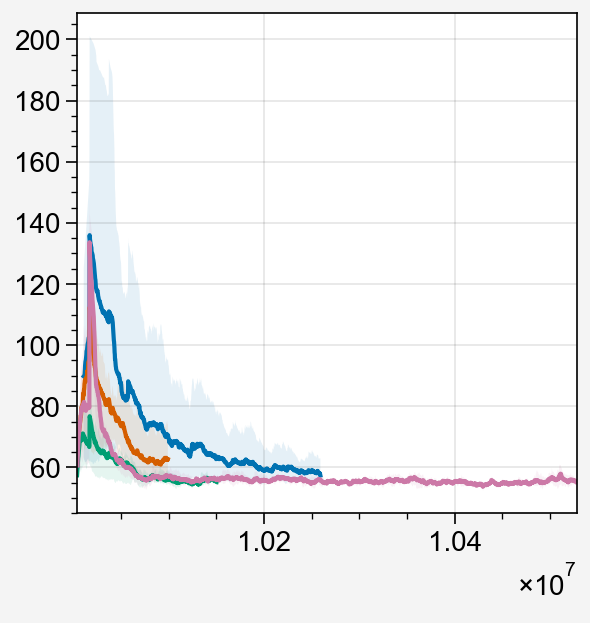

In [ ]:
'''Run to generate csvs for run files'''

aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
fig, ax = pplt.subplots()
for aux in aux_tasks:
    exp_name = f'shortcut_aux/shortcut_wc1.5p0.1_aux{aux}_cont'
    average_runs(exp_name, 'length', ax=ax)

In [19]:
checkpts = Path('../saved_checkpoints/shortcut_aux/')
folders = [f.name for f in checkpts.iterdir()]
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
trials = range(10)

for aux, t in itertools.product(aux_tasks, trials):
    exp_name = f'shortcut_wc1.5p0.1_aux{aux}_t{t}'
    cont_name = f'shortcut_wc1.5p0.1_aux{aux}_cont_t{t}'
    
    
    if cont_name in folders:
        print(exp_name, cont_name)
        cont_folder = checkpts/cont_name
        exp_folder = checkpts/exp_name
        for file in cont_folder.iterdir():
            fname = file.name
            shutil.copy(cont_folder/fname, exp_folder/fname)

shortcut_wc1.5p0.1_auxcatfacewall_t1 shortcut_wc1.5p0.1_auxcatfacewall_cont_t1
shortcut_wc1.5p0.1_auxcatfacewall_t2 shortcut_wc1.5p0.1_auxcatfacewall_cont_t2
shortcut_wc1.5p0.1_auxcatfacewall_t3 shortcut_wc1.5p0.1_auxcatfacewall_cont_t3
shortcut_wc1.5p0.1_auxcatfacewall_t6 shortcut_wc1.5p0.1_auxcatfacewall_cont_t6
shortcut_wc1.5p0.1_auxcatquad_t3 shortcut_wc1.5p0.1_auxcatquad_cont_t3
shortcut_wc1.5p0.1_auxcatquad_t5 shortcut_wc1.5p0.1_auxcatquad_cont_t5
shortcut_wc1.5p0.1_auxcatquad_t7 shortcut_wc1.5p0.1_auxcatquad_cont_t7
shortcut_wc1.5p0.1_auxcatquad_t8 shortcut_wc1.5p0.1_auxcatquad_cont_t8
shortcut_wc1.5p0.1_auxcatwall01_t3 shortcut_wc1.5p0.1_auxcatwall01_cont_t3
shortcut_wc1.5p0.1_auxcatwall01_t4 shortcut_wc1.5p0.1_auxcatwall01_cont_t4
shortcut_wc1.5p0.1_auxcatwall01_t7 shortcut_wc1.5p0.1_auxcatwall01_cont_t7
shortcut_wc1.5p0.1_auxcatwall01_t9 shortcut_wc1.5p0.1_auxcatwall01_cont_t9
shortcut_wc1.5p0.1_auxwall01_t1 shortcut_wc1.5p0.1_auxwall01_cont_t1
shortcut_wc1.5p0.1_auxwall01_t2

### WS/NS policy

In [22]:
folder = Path('data/shortcut/sc_aux_policy')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
trials = range(10)

exp_format = 'shortcut_wc1.5p0.1_aux{aux}_t{t}'
cont_format = 'shortcut_wc1.5p{p}_aux{aux}_cont_t{t}'
subdir = 'shortcut_aux'
for aux, t in tqdm(itertools.product(aux_tasks, trials), total=len(aux_tasks)*len(trials)):
    formatter = {'aux': aux, 't': t, 'p': 0.1}
    chks = get_first_last_performing_chks(exp_format=exp_format, cont_format=cont_format,
                                          subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{aux}_{t}'
    if key in os.listdir(folder):
        all_res = pickle.load(open(folder/key, 'rb'))
    else:
        all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        if chk in all_res['ws'] and chk < 1570:
            continue
        res = shortcut_test(exp_name, t, chk)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [15:07<00:00, 22.69s/it]


In [23]:
folder = Path('data/shortcut/sc_aux_policy')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
trials = range(10)

default = lambda: {
    'ns_lens': [],
    'ws_lens': [],
    'comb_lens': [],
    'surs': []
}

exps = [f.name for f in folder.iterdir()]

summary = defaultdict(default)
for aux in tqdm(aux_tasks):
    for t in trials:
        key = f'{aux}_{t}'
        if key not in exps:
            continue

        all_res = pickle.load(open(folder/key, 'rb'))
        
        ns_lens = []
        ws_lens = []
        comb_lens = []
        surs = []
        
        for chk in all_res['ns']:
            ns_len = get_ep_lens(all_res['ns'][chk]['ep_pos'])
            ws_len = get_ep_lens(all_res['ws'][chk]['ep_pos'])
            shortcut_used = [check_shortcut_usage(p) for p in all_res['ws'][chk]['ep_pos']]
            shortcut_used = np.array(shortcut_used) & (np.array(ws_len) < 202)

            ns_lens.append(np.mean(ns_len))
            ws_lens.append(np.mean(ws_len))
            comb_lens.append(np.mean(ns_len + ws_len))
            surs.append(np.mean(shortcut_used))
        
        summary[aux]['ns_lens'].append(ns_lens)
        summary[aux]['ws_lens'].append(ws_lens)
        summary[aux]['comb_lens'].append(comb_lens)
        summary[aux]['surs'].append(surs)
        
pickle.dump(dict(summary), open(folder/'summary', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:53<00:00, 28.34s/it]


### WS/NS copied

In [83]:
folder = Path('data/shortcut/sc_aux_copied')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
trials = range(10)

exp_format = 'shortcut_wc1.5p0.1_aux{aux}_t{t}'
cont_format = 'shortcut_wc1.5p{p}_aux{aux}_cont_t{t}'
subdir = 'shortcut_aux'
for aux, t in tqdm(itertools.product(aux_tasks, trials), total=len(aux_tasks)*len(trials)):
    formatter = {'aux': aux, 't': t, 'p': 0.1}
    chks = get_first_last_performing_chks(exp_format=exp_format, cont_format=cont_format,
                                          subdir=subdir,
                                         formatter=formatter)
    if chks is False:
        continue
    
    chks = chks[0] + chk_sched[:chks[1]]
    
    key = f'{aux}_{t}'
    if key in os.listdir(folder):
        all_res = pickle.load(open(folder/key, 'rb'))
    else:
        all_res = {'ws': {}, 'ns': {}}
    exp_name = subdir + '/' + re.split('_t\d', exp_format.format(**formatter))[0]

    for chk in chks:
        res = shortcut_test(exp_name, t, chk, with_fa=True)
        
        all_res['ws'][chk] = res['ws'][0]
        all_res['ns'][chk] = res['ns'][0]
    
    pickle.dump(all_res, open(folder/key, 'wb'))


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [7:31:15<00:00, 676.89s/it]


### Plot

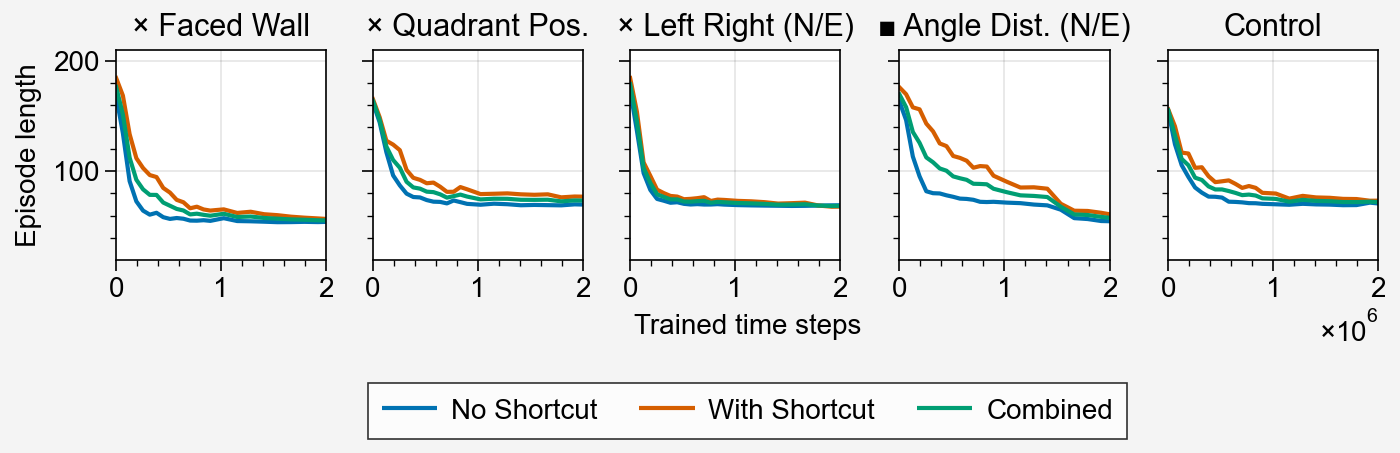

In [7]:
folder = Path('data/shortcut/sc_aux_policy')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
labels = [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)']
summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=5, figwidth=7)

for i, aux in enumerate(aux_tasks):
    lines = []
    
    num_chks = min([len(p) for p in summary[aux]['ns_lens']])
    ns_lens = np.mean([n[:num_chks] for n in summary[aux]['ns_lens']], axis=0)
    ws_lens = np.mean([n[:num_chks] for n in summary[aux]['ws_lens']], axis=0)
    comb_lens = np.mean([ns_lens, ws_lens], axis=0)
    
    x_plot = chk_sched[:num_chks] * 64 * 100 / 1000000
    
    lines.append(ax[i].plot(x_plot, ns_lens, label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, ws_lens, label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, comb_lens, label='Combined'))

    
# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
x_plot = chk_sched * 64 * 100
p = 0.1
ax[-1].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='No Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='With Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined')

    
fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=labels+['Control'], ylim=[20, 210])
ax[:-1].format(xlim=[0, 2])
ax[-1].format(xlim=[0, 2e6])

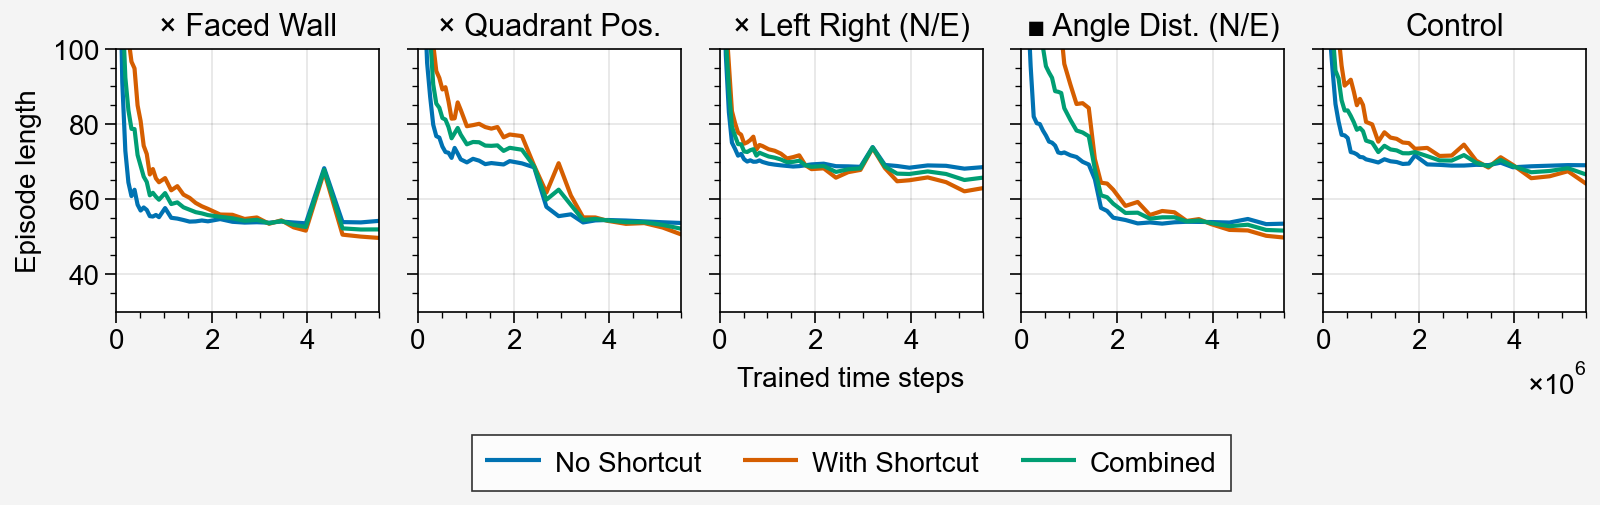

In [35]:
folder = Path('data/shortcut/sc_aux_policy')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
labels = [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)']
summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=5, figwidth=8)

for i, aux in enumerate(aux_tasks):
    lines = []
    
    num_chks = min([len(p) for p in summary[aux]['ns_lens']])
    ns_lens = np.mean([n[:num_chks] for n in summary[aux]['ns_lens']], axis=0)
    ws_lens = np.mean([n[:num_chks] for n in summary[aux]['ws_lens']], axis=0)
    comb_lens = np.mean([ns_lens, ws_lens], axis=0)
    
    x_plot = chk_sched[:num_chks] * 64 * 100 / 1000000
    
    lines.append(ax[i].plot(x_plot, ns_lens, label='No Shortcut'))
    lines.append(ax[i].plot(x_plot, ws_lens, label='With Shortcut'))
    lines.append(ax[i].plot(x_plot, comb_lens, label='Combined'))

    
# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
x_plot = chk_sched * 64 * 100
p = 0.1
ax[-1].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='No Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='With Shortcut')
ax[-1].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined')

    
fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=labels+['Control'], ylim=[30, 100])
ax[:-1].format(xlim=[0, 5.5])
ax[-1].format(xlim=[0, 5.5e6])

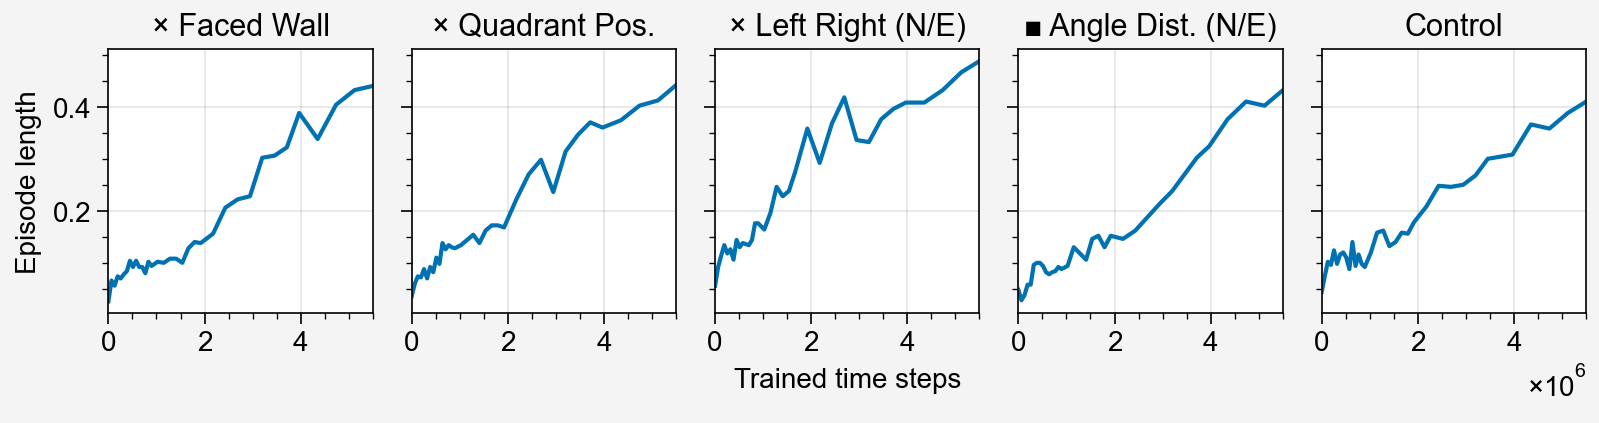

In [36]:
folder = Path('data/shortcut/sc_aux_policy')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
labels = [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)']

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(ncols=5, figwidth=8)

for i, aux in enumerate(aux_tasks):
    lines = []
    
    num_chks = min([len(p) for p in summary[aux]['ns_lens']])
    surs = np.mean([n[:num_chks] for n in summary[aux]['surs']], axis=0)
    
    x_plot = chk_sched[:num_chks] * 64 * 100 / 1000000    
    lines.append(ax[i].plot(x_plot, surs))
    
# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
x_plot = chk_sched * 64 * 100
p = 0.1
ax[-1].plot(x_plot, np.mean(summary[p]['surs'], axis=0), label='No Shortcut')
    
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=labels+['Control'])

ax[:-1].format(xlim=[0, 5.5])
ax[-1].format(xlim=[0,5.5e6])

# Observing some late trained p=0.1 agents

In [135]:
folder = Path('data/shortcut/wc1.5_policy')
all_res = pickle.load(open(folder/f'0.1_1', 'rb'))

In [136]:
chks = list(all_res['ws'].keys())
res = all_res['ws'][chks[-1]]

np.mean([check_shortcut_usage(p) for p in res['ep_pos']])

0.72

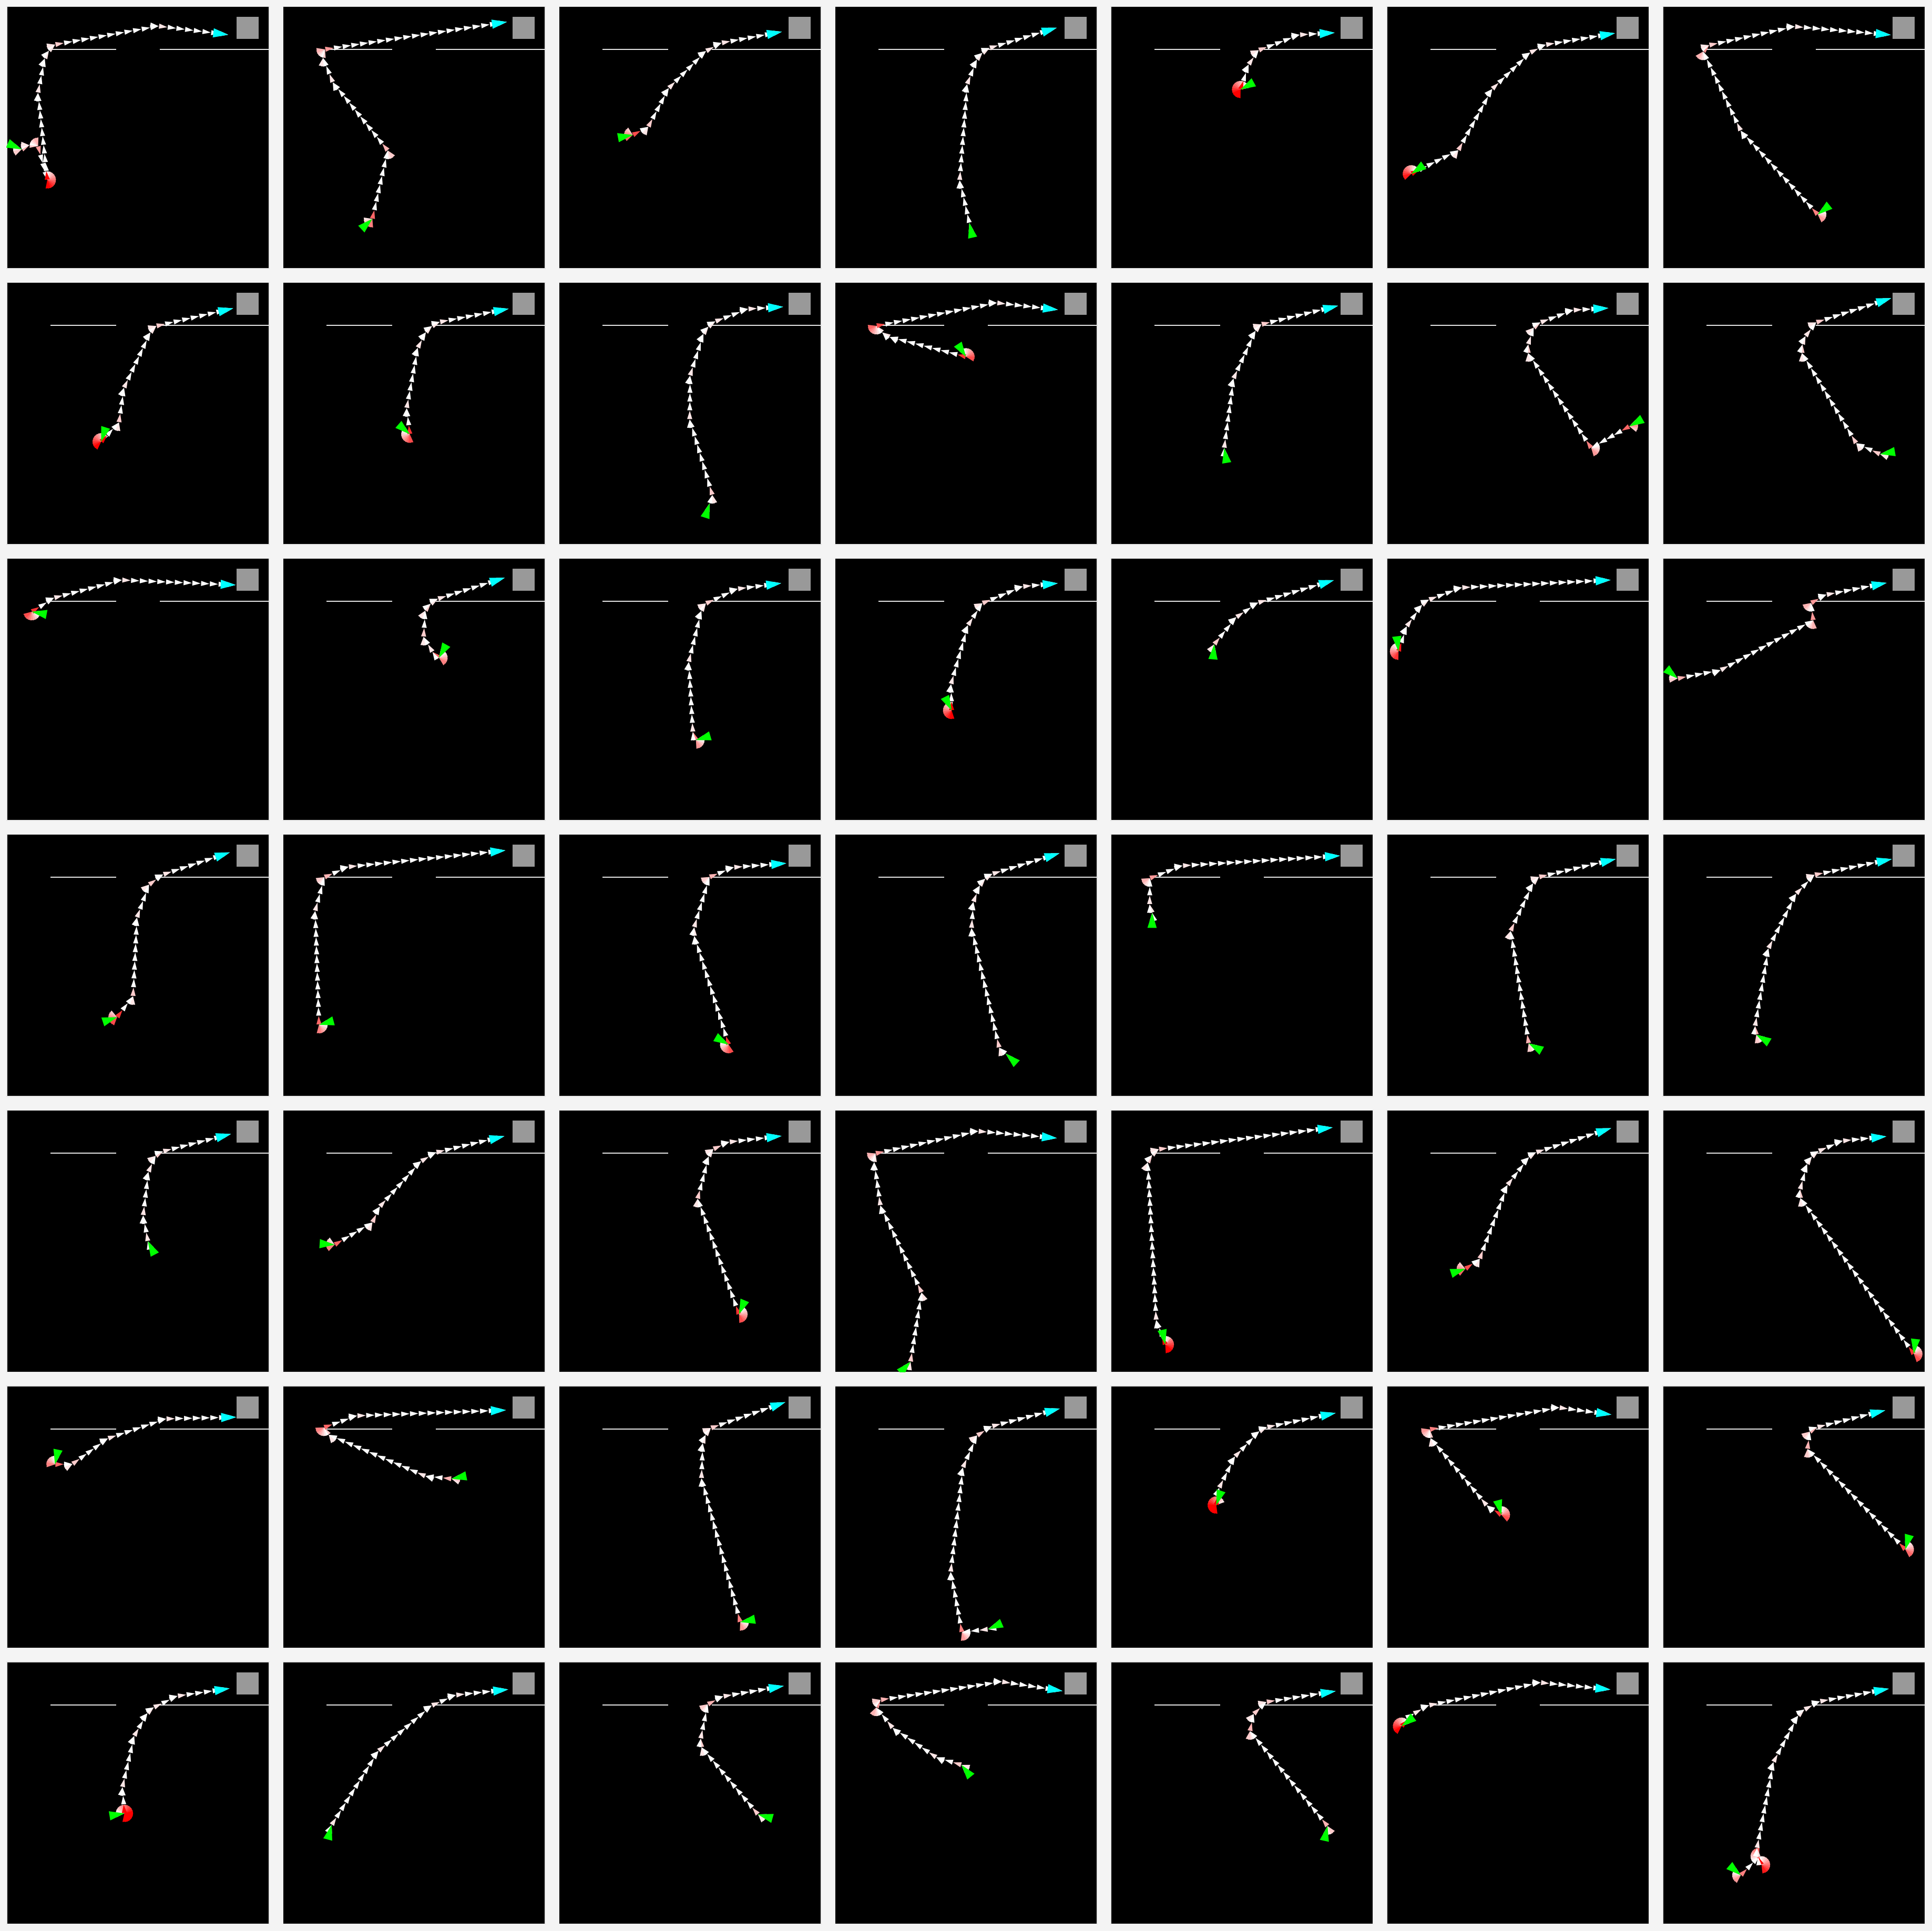

In [137]:
set_trajectory_plot_style()

fig, ax = pplt.subplots(nrows=7, ncols=7)

for i in range(49):
    draw_shortcut_maze(ax=ax[i])
    p = res['ep_pos'][i]
    a = res['ep_angle'][i]
    draw_trajectory(p, a, ax=ax[i])
    
pplt.rc.reset()

# Visualizing lining up p=0.1 performances

In [90]:
set_rc()

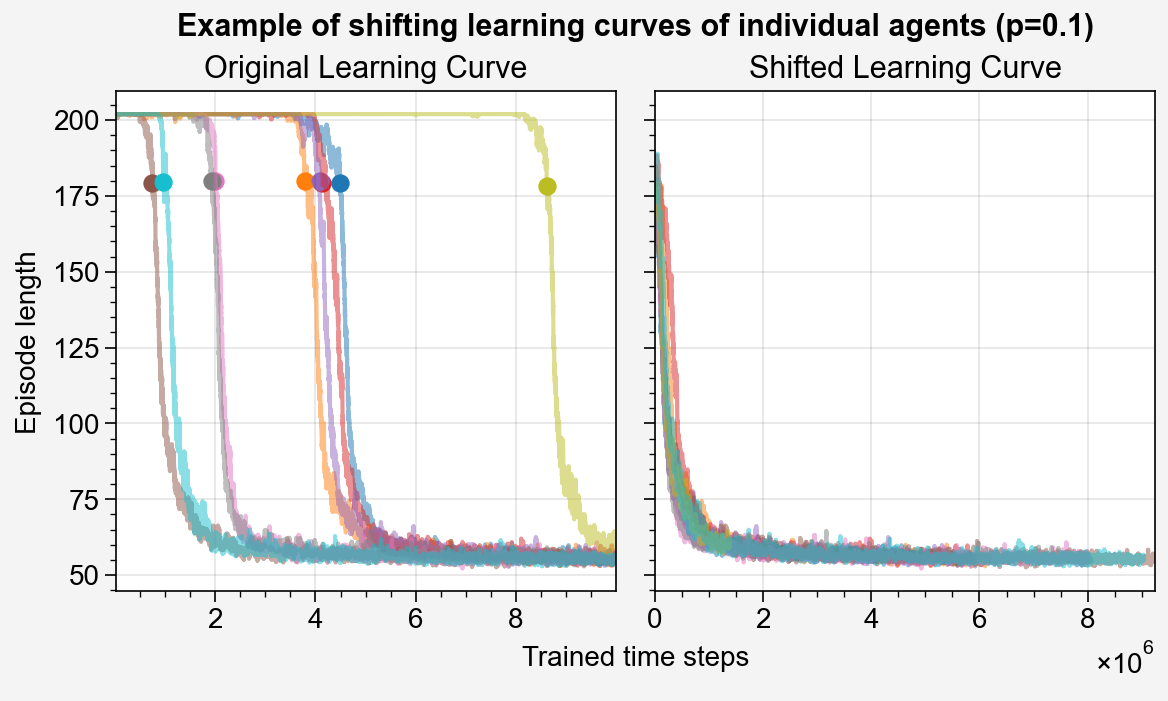

In [91]:
exp_format = 'shortcut_wc1.5p0.1longer_t{t}'
cont_format = 'shortcut_wc1.5p0.1longer_cont_t{t}'

fig, ax = pplt.subplots(ncols=2)
for i in range(10):
    df = combine_cont_df(exp_format, cont_format, formatter={'t': i},)
    x, y = get_run_df_metric(df)
    first = get_first_shortcut_performance(x, y, ret_chk=False)
    
    if not first:
        continue
    
    ax[0].plot(x/1000000, y, color=rgb_colors[i], alpha=0.5)
    ax[1].plot(x[first:]-x[first], y[first:], color=rgb_colors[i], alpha=0.5)
    
    ax[0].scatter([x[first]/1000000], [y[first]], color=rgb_colors[i])
    
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=['Original Learning Curve', 'Shifted Learning Curve'],
          suptitle='Example of shifting learning curves of individual agents (p=0.1)')

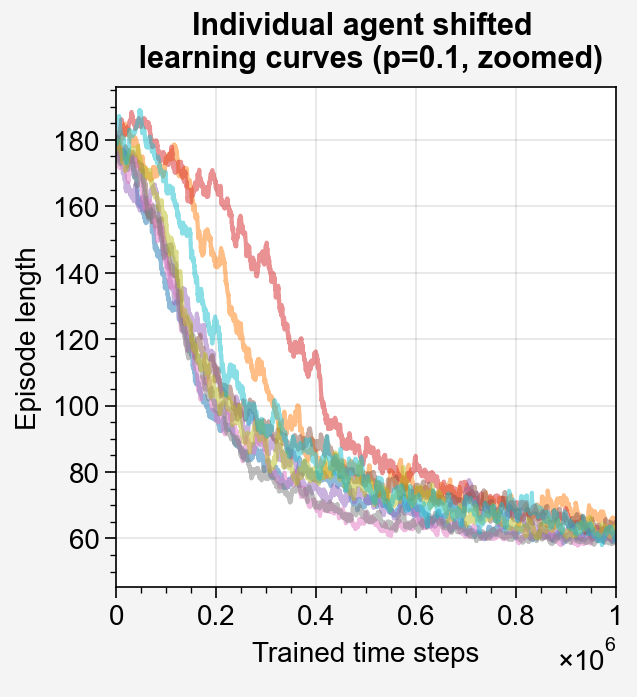

In [39]:
exp_format = 'shortcut_wc1.5p0.1longer_t{t}'
cont_format = 'shortcut_wc1.5p0.1longer_cont_t{t}'

fig, ax = pplt.subplots()
xs = []
ys = []
for i in range(10):
    df = combine_cont_df(exp_format, cont_format, formatter={'t': i},)
    x, y = get_run_df_metric(df)
    first = get_first_shortcut_performance(x, y, ret_chk=False)
    
    if not first:
        continue
    
    ax.plot(x[first:]-x[first], y[first:], color=rgb_colors[i], alpha=0.5)
    xs.append(x[first:]-x[first])
    ys.append(y[first:])
    
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          suptitle='Individual agent shifted \n learning curves (p=0.1, zoomed)',
         xlim=[0, 1e6])

In [41]:
len(ys)

9

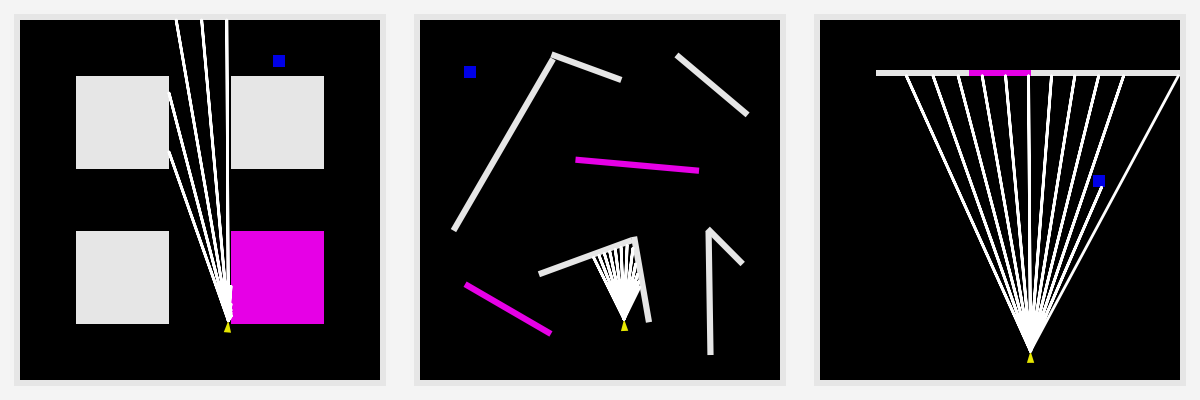

In [2]:
set_trajectory_plot_style()

fig, ax = pplt.subplots(ncols=3, figwidth=6)

tasks = [1.7, 2.7, 3]
p = 0

for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, 
                   shortcut_probability=p, num_plums=1,
                   wall_thickness=5)
    env.reset()
    env.render('human', ax=ax[i])
    
ax.format(xlim=[0, 300], ylim=[0, 300])
set_rc()

# Signs of life delays

In [37]:
folder = Path('data/shortcut/plum2sc_policy')

keys = ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
labels = ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze']

summary = pickle.load(open(folder/'summary', 'rb'))


In [42]:
folder = Path('data/shortcut/plum2sc_policy')

keys = ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
labels = ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze']
trials = range(10)

exps = [f.name for f in folder.iterdir()]

sol = defaultdict(list)

for key in tqdm(keys):
    for t in trials:
        tkey = f'{key}_{t}'
        if tkey not in exps:
            continue

        all_res = pickle.load(open(folder/tkey, 'rb'))
        sol[key].append(list(all_res['ns'].keys())[0])
        
pickle.dump(dict(sol), open(folder/'signsoflife', 'wb'))


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:09<00:00, 17.50s/it]


In [46]:
folder = Path('data/shortcut/sc_aux')

p = 0.1
aux_tasks = ['catfacewall',  'catquad', 'catwall01', 'wall01']
trials = range(10)
exps = [f.name for f in folder.iterdir()]

sol = defaultdict(list)
for aux in tqdm(aux_tasks):
    for t in trials:
        key = f'{aux}_{t}'
        if key not in exps:
            continue

        all_res = pickle.load(open(folder/key, 'rb'))
        sol[aux].append(list(all_res['ns'].keys())[0])

        
pickle.dump(dict(sol), open(folder/'signsoflife', 'wb'))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:04<00:00, 31.09s/it]


{'whiskers': <a list of 8 Line2D objects>,
 'caps': <a list of 8 Line2D objects>,
 'boxes': <a list of 4 Line2D objects>,
 'medians': <a list of 4 Line2D objects>,
 'fliers': <a list of 4 Line2D objects>,
 'means': []}

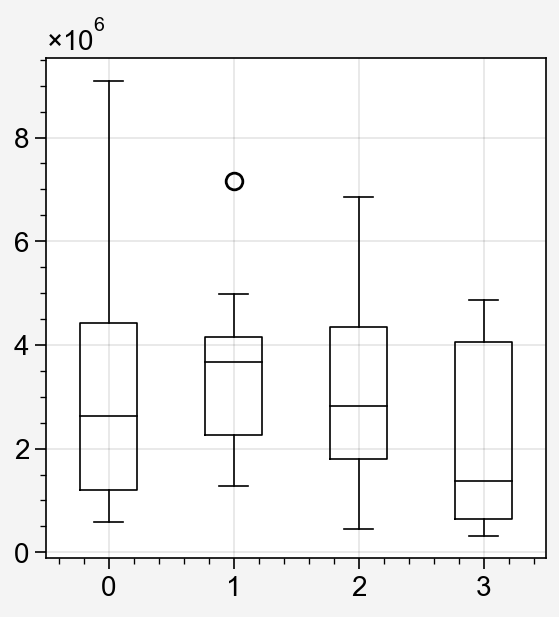

In [54]:
fig, ax = pplt.subplots()



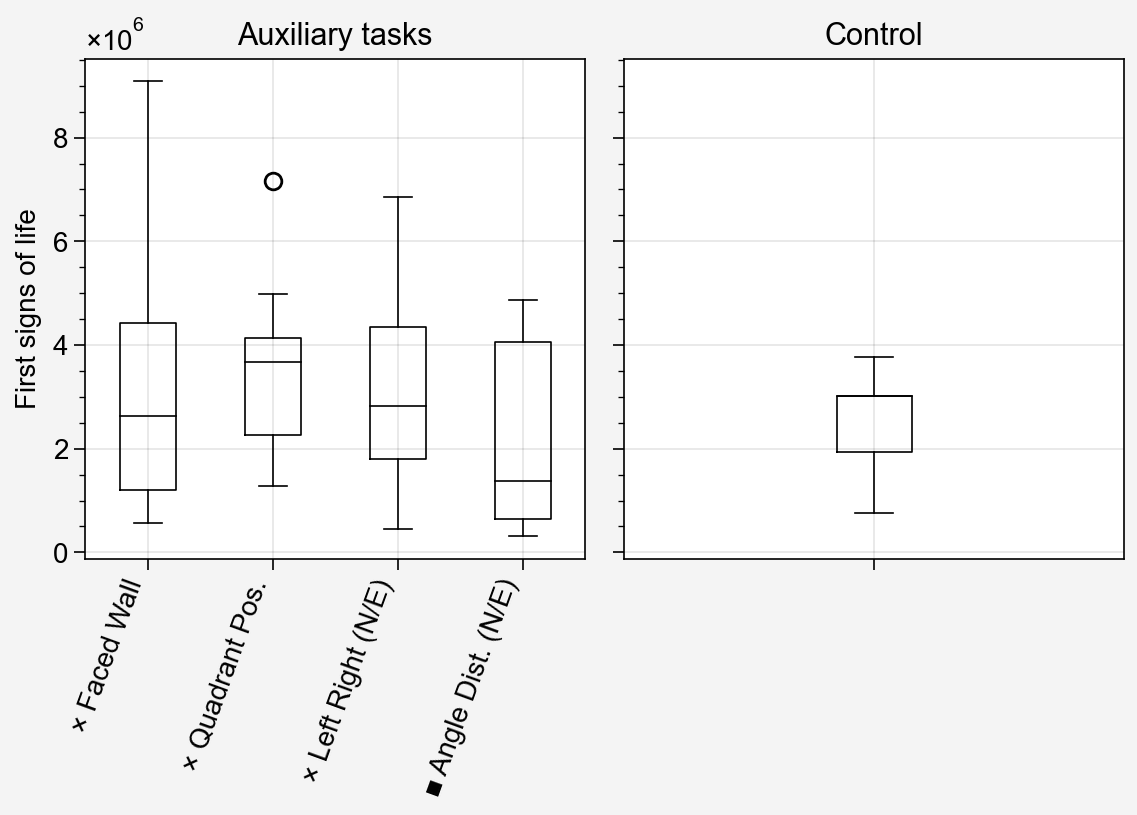

In [69]:
fig, ax = pplt.subplots(ncols=2)

folder = Path('data/shortcut/sc_aux')
sol = pickle.load(open(folder/'signsoflife', 'rb'))
ax[0].boxplot(np.array(list(sol.values())).T * 64 * 100)
labels = [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)']

ax[1].boxplot(np.array([sol2]).T * 64 * 100)
# folder = Path('data/shortcut/plum2sc_policy')
# sol = pickle.load(open(folder/'signsoflife', 'rb'))
# ax[1].boxplot(np.array(list(sol.values())).T * 64 * 100)

ax.format(ylabel='First signs of life', title=['Auxiliary tasks', 'Control'],)
ax[0].format(xlocator=[0, 1, 2, 3], xformatter=labels, xrotation=70)
ax[1].format(xlocator=[0], xformatter=[''])

In [60]:
def get_first_last_performing_chks(p=0.4, t=0, verbose=False):
    '''Specific function for getting first and last checkpoints to test
    starting from first performing
    
    If return False, it means either not enough chks available or 
        never reached the required performance to start
    '''
    chks_up = int(round(5950000/(64*100), -1)) #how many more chks to get to 6e6 steps
    
    # Get first checkpoint where performance is sufficient
    if p in [0.1, 0.4]:
        df = combine_cont_df(exp_format='shortcut_wc1.5p{p}longer_t{t}',
                             formatter={'p': p, 't': t})
    else:
        df = combine_cont_df(formatter={'p': p, 't': t})
    x, y = get_run_df_metric(df, ignore_first=1000)
    first_chk = get_first_shortcut_performance(x, y)
    
    if p in [0.1, 0.4]:
        exp_name = f'shortcut_wc1.5p{p}longer_t{t}'
    else:
        exp_name = f'shortcut_wc1.5p{p}_t{t}'
    
    folder = Path(f'../saved_checkpoints/shortcut_wc2/{exp_name}')
    fnames = [f.name for f in folder.iterdir()]
    
    if verbose:
        print(f'{p}_{t}', first_chk, first_chk+chks_up, f'{first_chk+chks_up}.pt' in fnames)
    
    if first_chk is False or f'{first_chk+chks_up}.pt' not in fnames:
        return False
    else:
        return first_chk, first_chk+chks_up

sol = []
for t in range(10):
    first_chk = get_first_last_performing_chks(0.1, t)
    sol.append(first_chk[0])

# ws/ns crossover vs sur

Curious about whether the improvement of shortcut performance over no shortcut correlates with shortcut use rate

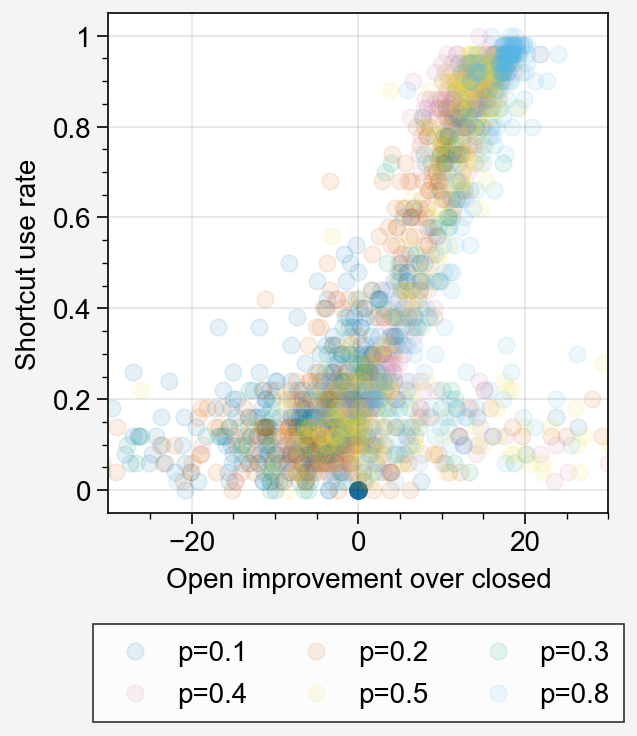

In [25]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots()

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
            
    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    x = list(diff.flatten())
    y = list(np.array(summary[p]['surs']).flatten())
    
    ax.scatter(x, y, label=f'p={p}', alpha=0.1)

fig.legend(loc='b')
ax.format(xlabel='Open improvement over closed', ylabel='Shortcut use rate',
         xlim=[-30, 30])


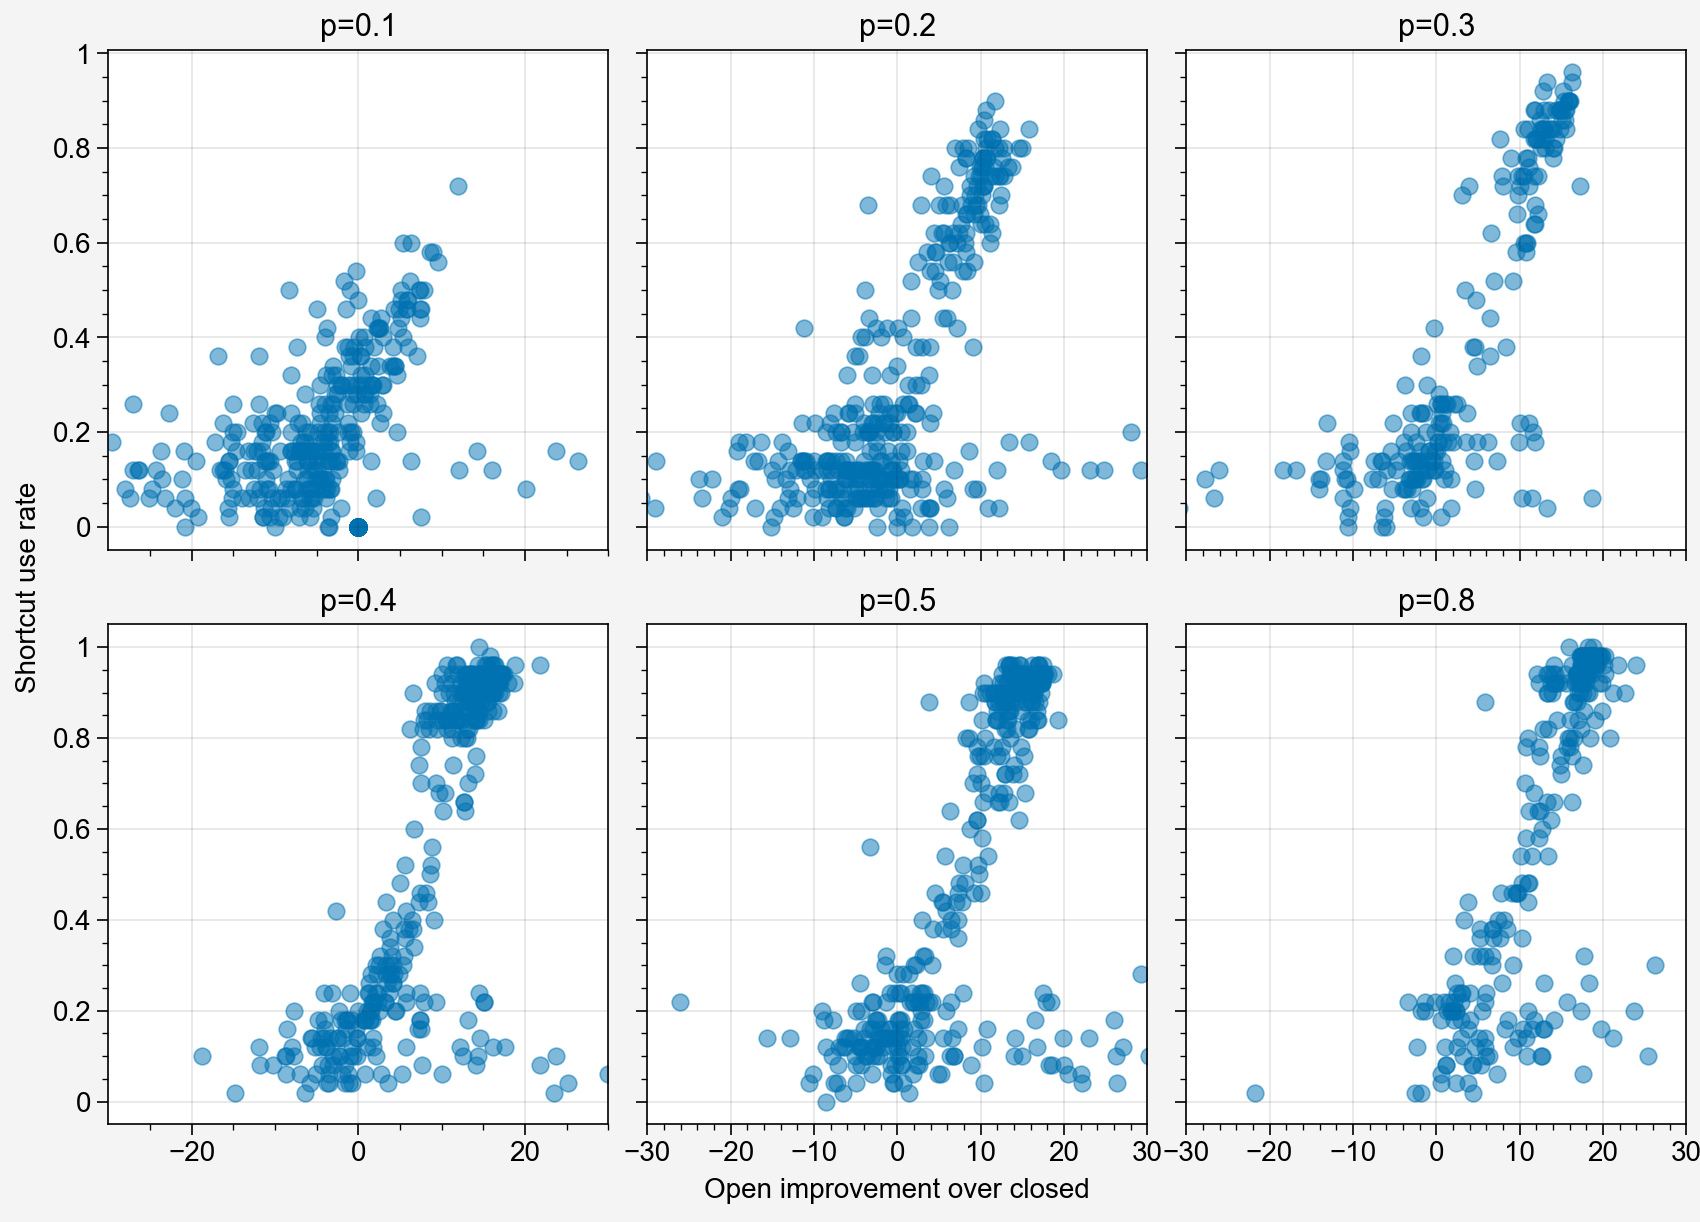

In [27]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=3)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
            
    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    x = list(diff.flatten())
    y = list(np.array(summary[p]['surs']).flatten())
    
    ax[i].scatter(x, y, label=f'p={p}', alpha=0.5)

ax.format(xlabel='Open improvement over closed', ylabel='Shortcut use rate',
         xlim=[-30, 30], title=[f'p={p}' for p in probs])


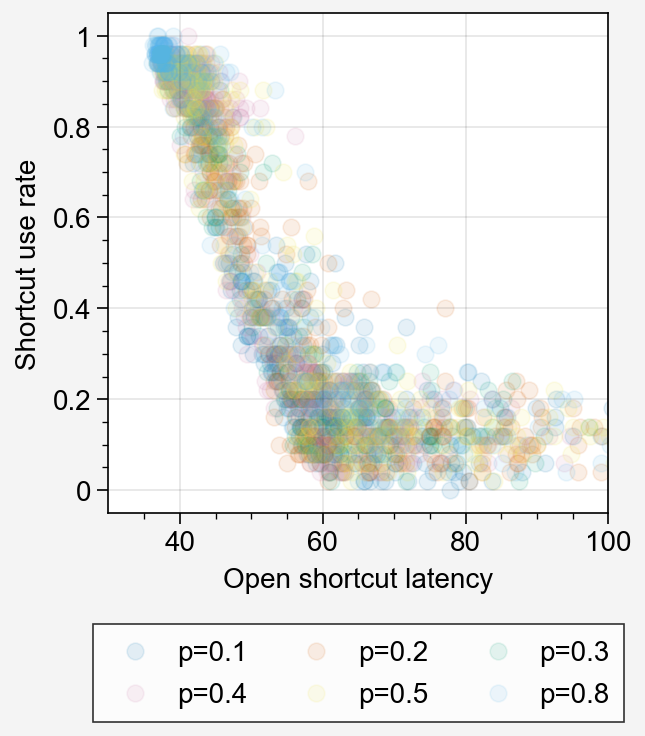

In [85]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots()

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
            
    diff = np.array(summary[p]['ws_lens'])
    x = list(diff.flatten())
    y = list(np.array(summary[p]['surs']).flatten())
    
    ax.scatter(x, y, label=f'p={p}', alpha=0.1)

fig.legend(loc='b')
ax.format(xlabel='Open shortcut latency', ylabel='Shortcut use rate',
         xlim=[30, 100])


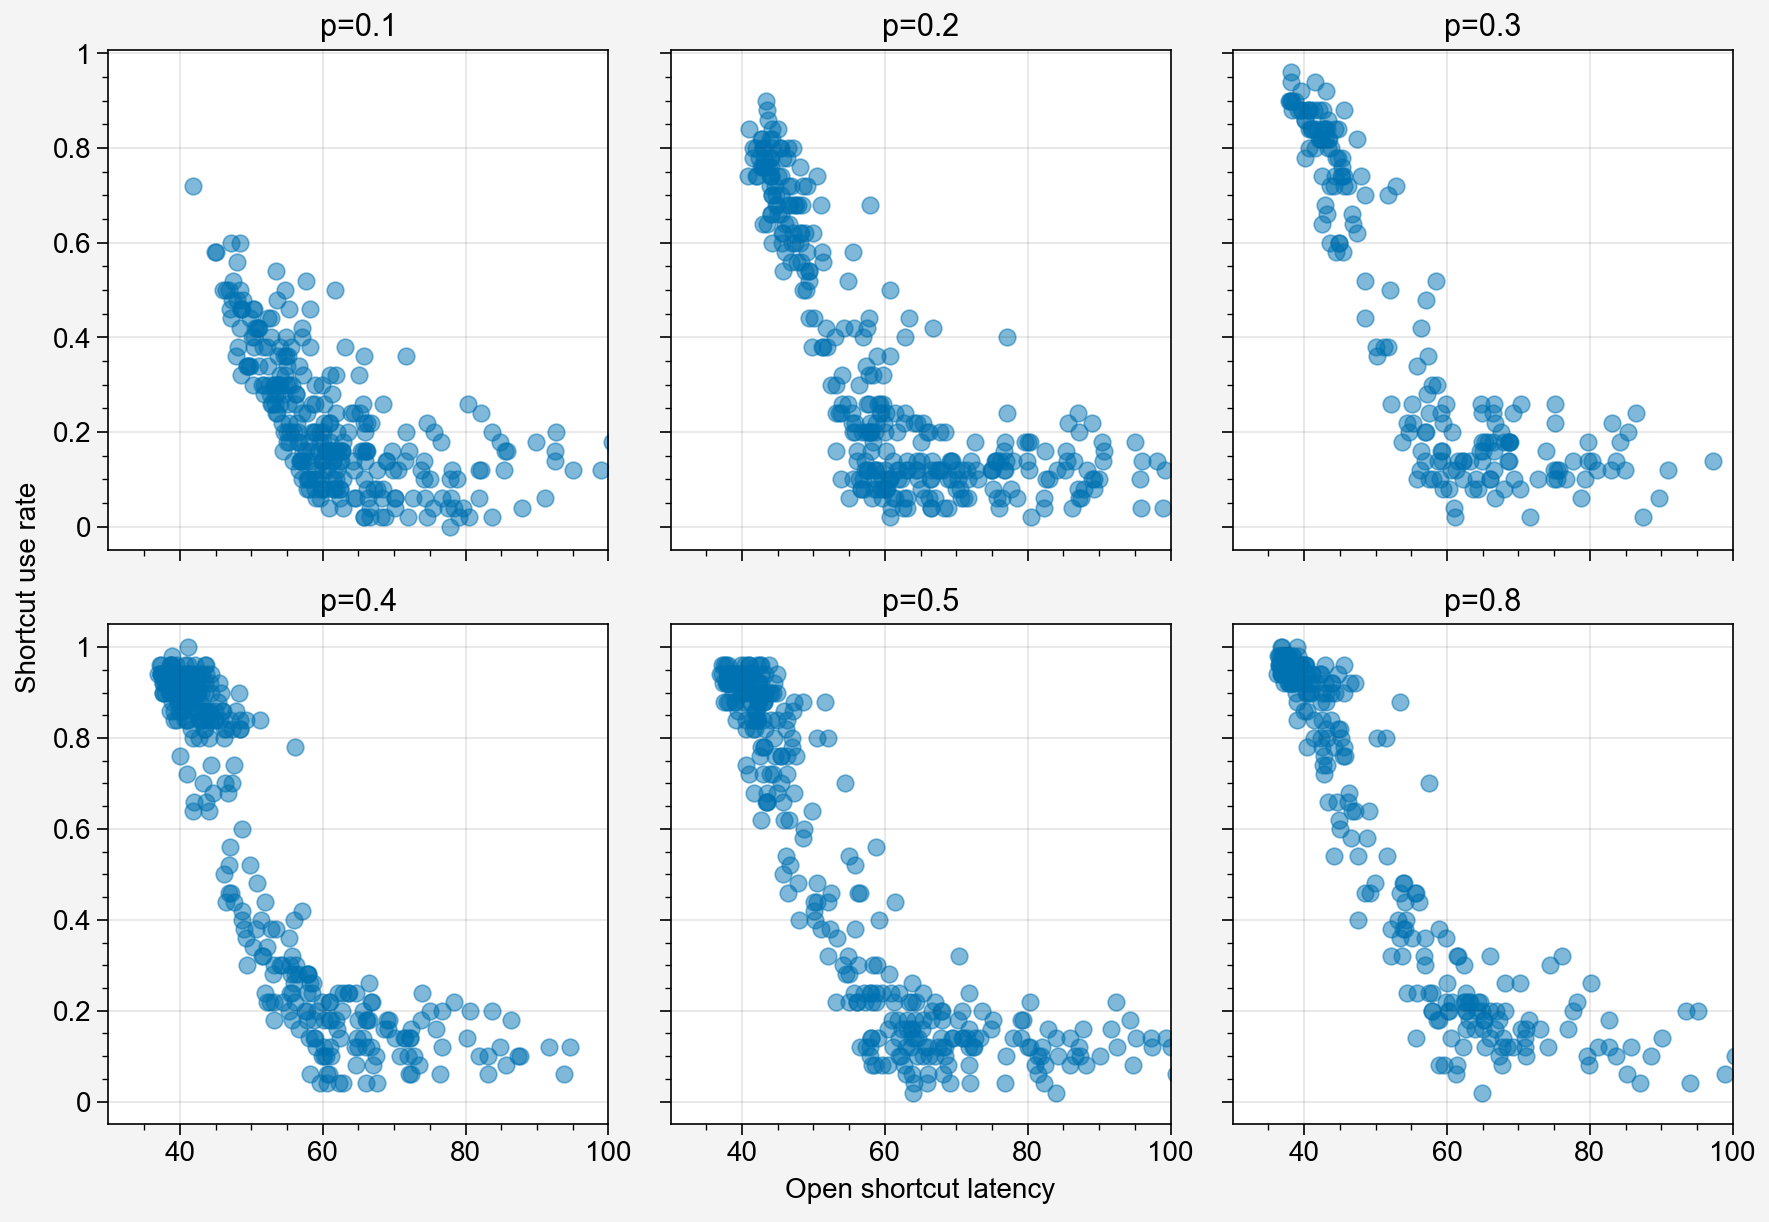

In [87]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=3)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
            
    diff = np.array(summary[p]['ws_lens'])
    x = list(diff.flatten())
    y = list(np.array(summary[p]['surs']).flatten())
    
    ax[i].scatter(x, y, label=f'p={p}', alpha=0.5)

ax.format(xlabel='Open shortcut latency', ylabel='Shortcut use rate',
         xlim=[30, 100], title=[f'p={p}' for p in probs])


In [ ]:
# probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=3)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
            
    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    x = list(diff.flatten())
    y = list(np.array(summary[p]['surs']).flatten())
    
    ax[i].scatter(x, y, label=f'p={p}', alpha=0.5)

ax.format(xlabel='Open improvement over closed', ylabel='Shortcut use rate',
         xlim=[-30, 30], title=[f'p={p}' for p in probs])


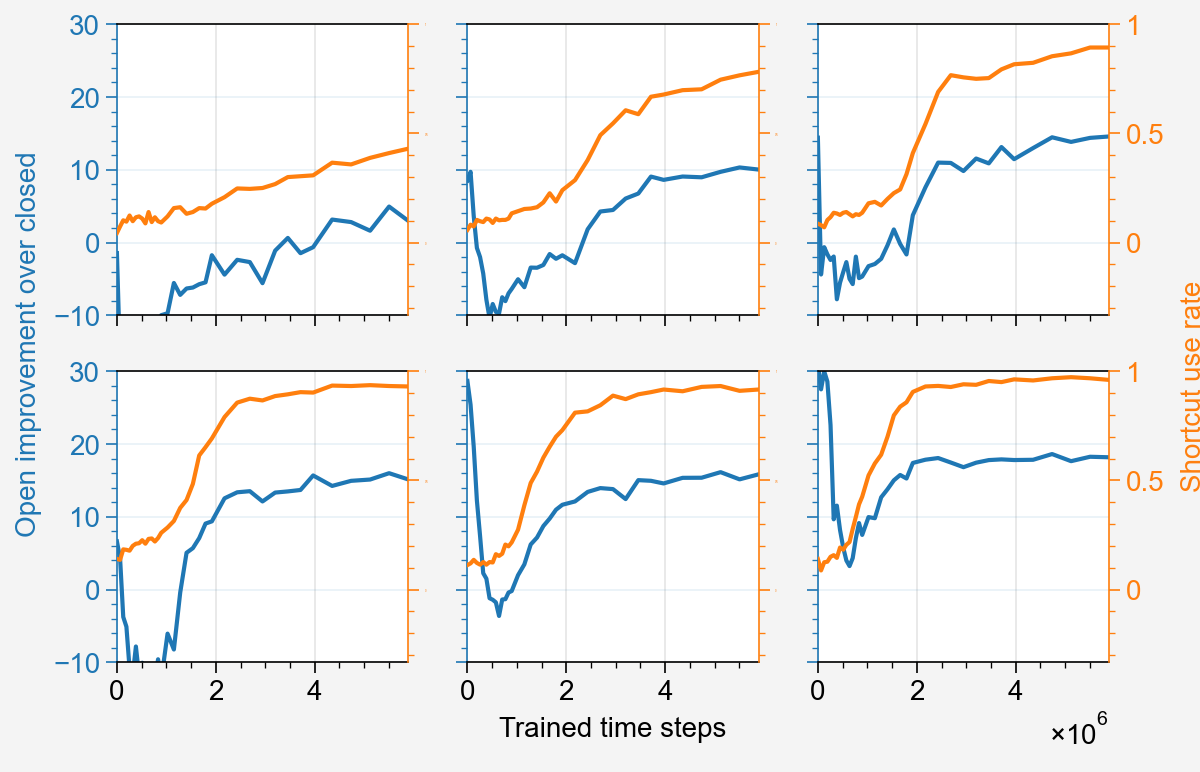

In [87]:
fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: x / 30)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur

    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    y1 = diff.mean(axis=0)
    y2 = np.mean(summary[p]['surs'], axis=0)
    
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000

    ax[i].plot(x, y1, c=rgb_colors[0])
    sax[i].plot(x, y2, c=rgb_colors[1])

ax.format(ylabel='Open improvement over closed', ylabelcolor=rgb_colors[0], ylim=[-10, 30],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps')
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(0.995, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)

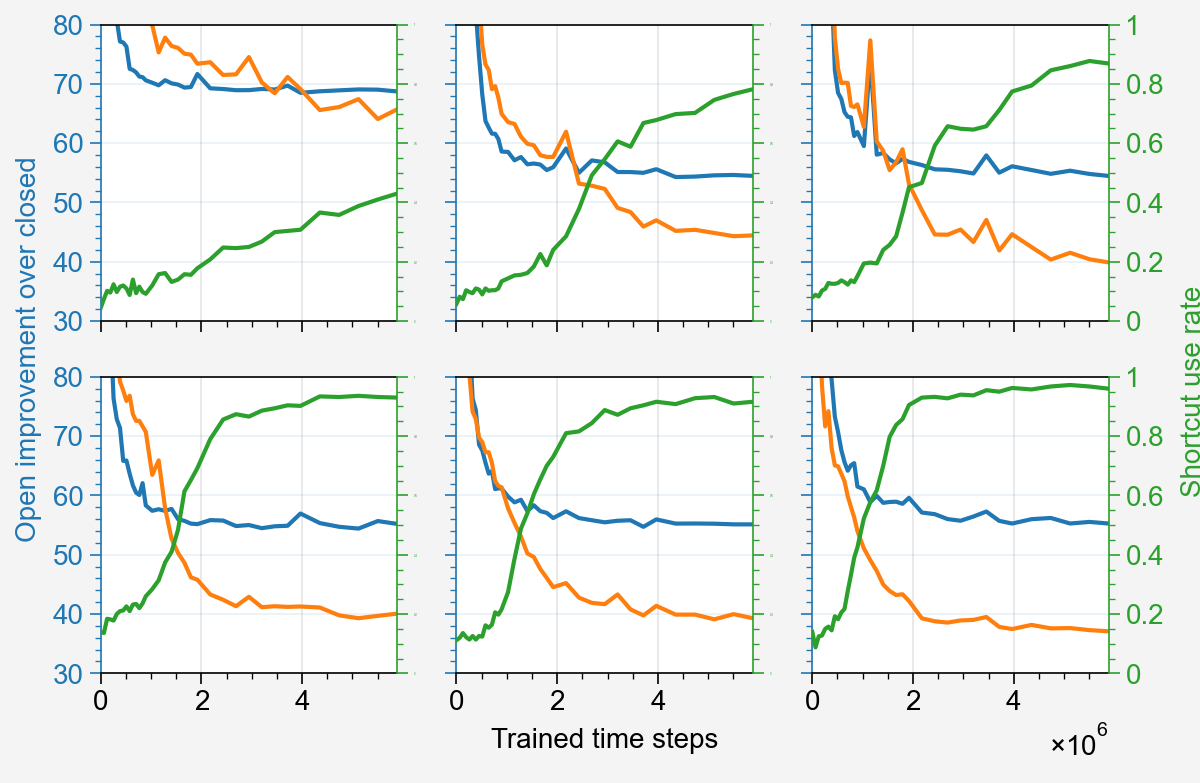

In [8]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: (x-30) / 50)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    y0 = np.mean(summary[p]['ns_lens'], axis=0)
    y1 = np.mean(summary[p]['ws_lens'], axis=0)
    y2 = np.mean(summary[p]['surs'], axis=0)
    
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000

    ax[i].plot(x, y0, c=rgb_colors[0], label='Shortcut Closed')
    ax[i].plot(x, y1, c=rgb_colors[1], label='Shortcut Opened')
    sax[i].plot(x, y2, c=rgb_colors[2])

ax.format(ylabel='Open improvement over closed', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80])
sax.format(ylabelcolor=rgb_colors[2],
          ytickcolor=rgb_colors[2], yticklabelcolor=rgb_colors[2], ygridcolor=rgb_colors[2])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[2])

fig.text(0.995, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[2]
)
sax[:, :2].format(fontsize=0)

# Late training performance and shortcut use rate

In [15]:
from scipy.stats import ttest_ind

array([54.4 , 51.64, 48.3 , 52.54, 48.34, 47.06, 47.1 , 53.62, 45.9 ,
       63.12])

In [47]:
np.unshift

AttributeError: module 'numpy' has no attribute 'unshift'

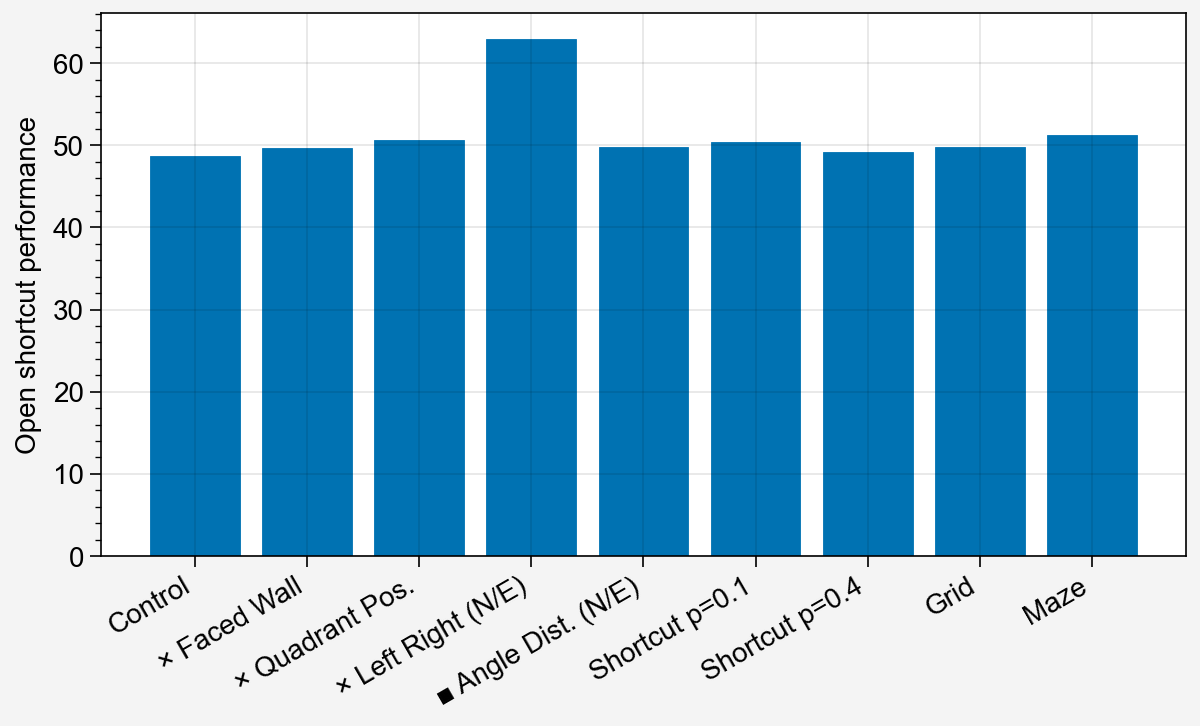

In [48]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

fig, ax = pplt.subplots(figwidth=6, refaspect=2)


xs = []
ys = []
all_labels = []

# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]
xs.append(len(xs))
control_y = np.array(summary[p]['ws_lens'])[:, 34]
ys.append(np.mean(control_y))
all_labels.append('Control')

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        xs.append(i*4 + j + 1)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        y = np.array(summary[subset]['ws_lens'])[:, 34]
        ys.append(np.mean(y))
        
ax.bar(xs, ys)


ax.format(xlocator=range(9), xformatter=all_labels,
          ylabel='Open shortcut performance',
          xrotation=30)

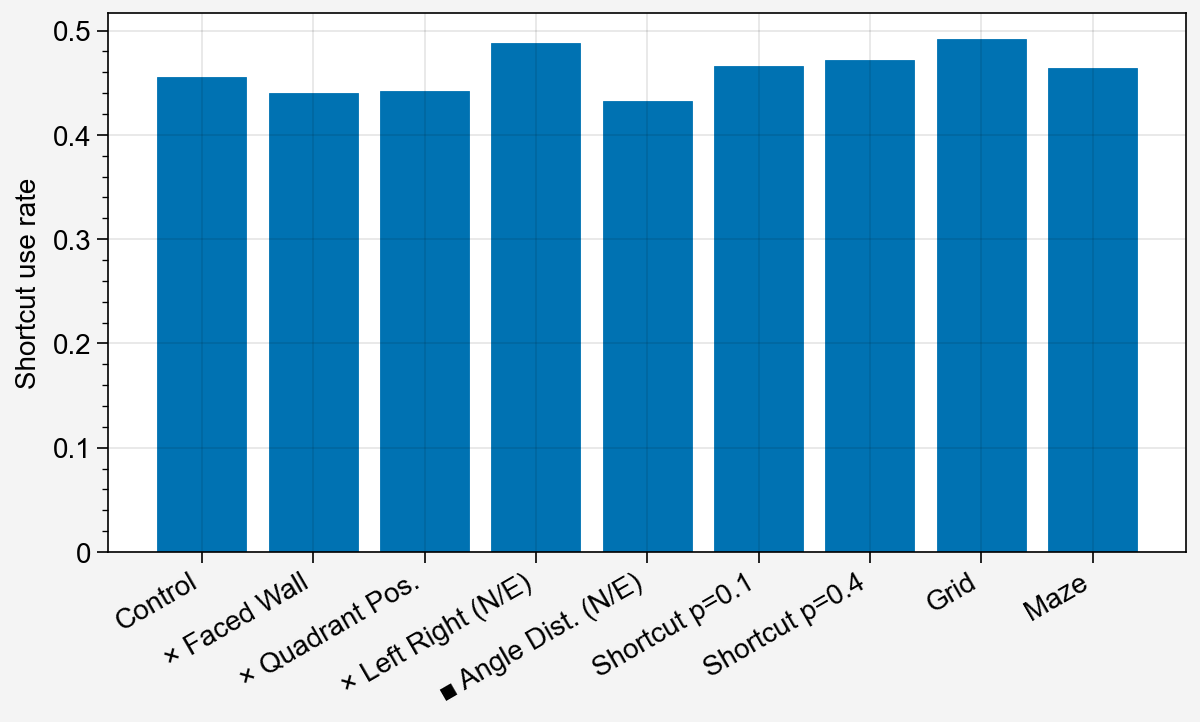

In [60]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

fig, ax = pplt.subplots(figwidth=6, refaspect=2)


xs = []
ys = []
all_labels = []
ps = []

# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]

xs.append(len(xs))
control_y = np.array(summary[p]['surs'])[:, 34]
ys.append(np.mean(control_y))
all_labels.append('Control')


for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        xs.append(i*4 + j + 1)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        y = np.array(summary[subset]['surs'])[:, 34]
        ys.append(np.mean(y))
        
        ps.append(ttest_ind(y, control_y).pvalue)

ax.bar(xs, ys)


ax.format(xlocator=range(9), xformatter=all_labels,
          ylabel='Shortcut use rate',
          xrotation=30)

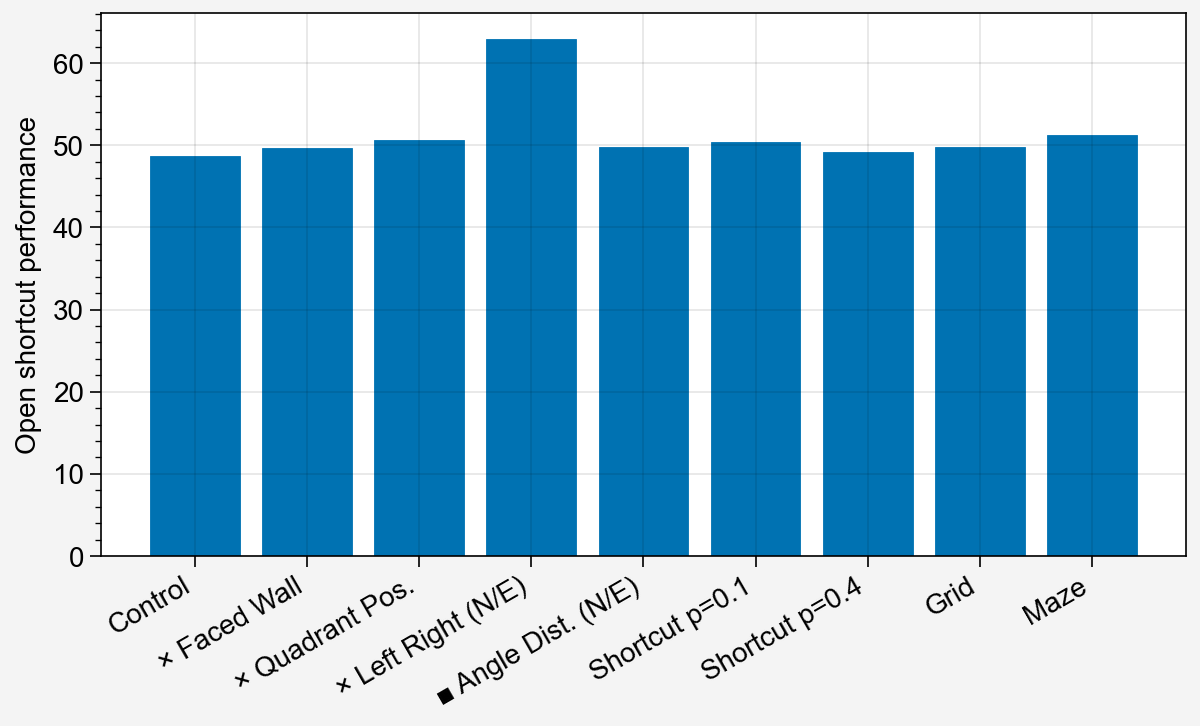

In [48]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

fig, ax = pplt.subplots(figwidth=6, refaspect=2)


xs = []
ys = []
all_labels = []

# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]
xs.append(len(xs))
control_y = np.array(summary[p]['ws_lens'])[:, 34]
ys.append(np.mean(control_y))
all_labels.append('Control')

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        xs.append(i*4 + j + 1)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        y = np.array(summary[subset]['ws_lens'])[:, 34]
        ys.append(np.mean(y))
        
ax.bar(xs, ys)


ax.format(xlocator=range(9), xformatter=all_labels,
          ylabel='Open shortcut performance',
          xrotation=30)

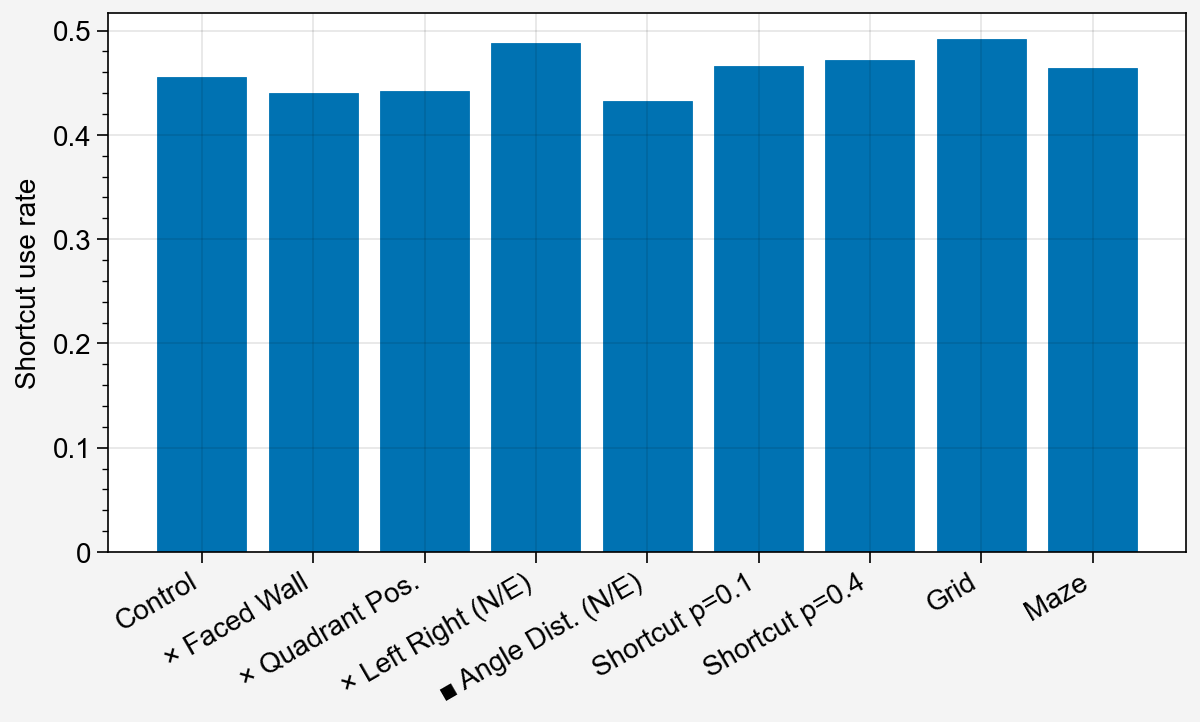

In [60]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

fig, ax = pplt.subplots(figwidth=6, refaspect=2)


xs = []
ys = []
all_labels = []
ps = []

# Plot control
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]

xs.append(len(xs))
control_y = np.array(summary[p]['surs'])[:, 34]
ys.append(np.mean(control_y))
all_labels.append('Control')


for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        xs.append(i*4 + j + 1)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        y = np.array(summary[subset]['surs'])[:, 34]
        ys.append(np.mean(y))
        
        ps.append(ttest_ind(y, control_y).pvalue)

ax.bar(xs, ys)


ax.format(xlocator=range(9), xformatter=all_labels,
          ylabel='Shortcut use rate',
          xrotation=30)

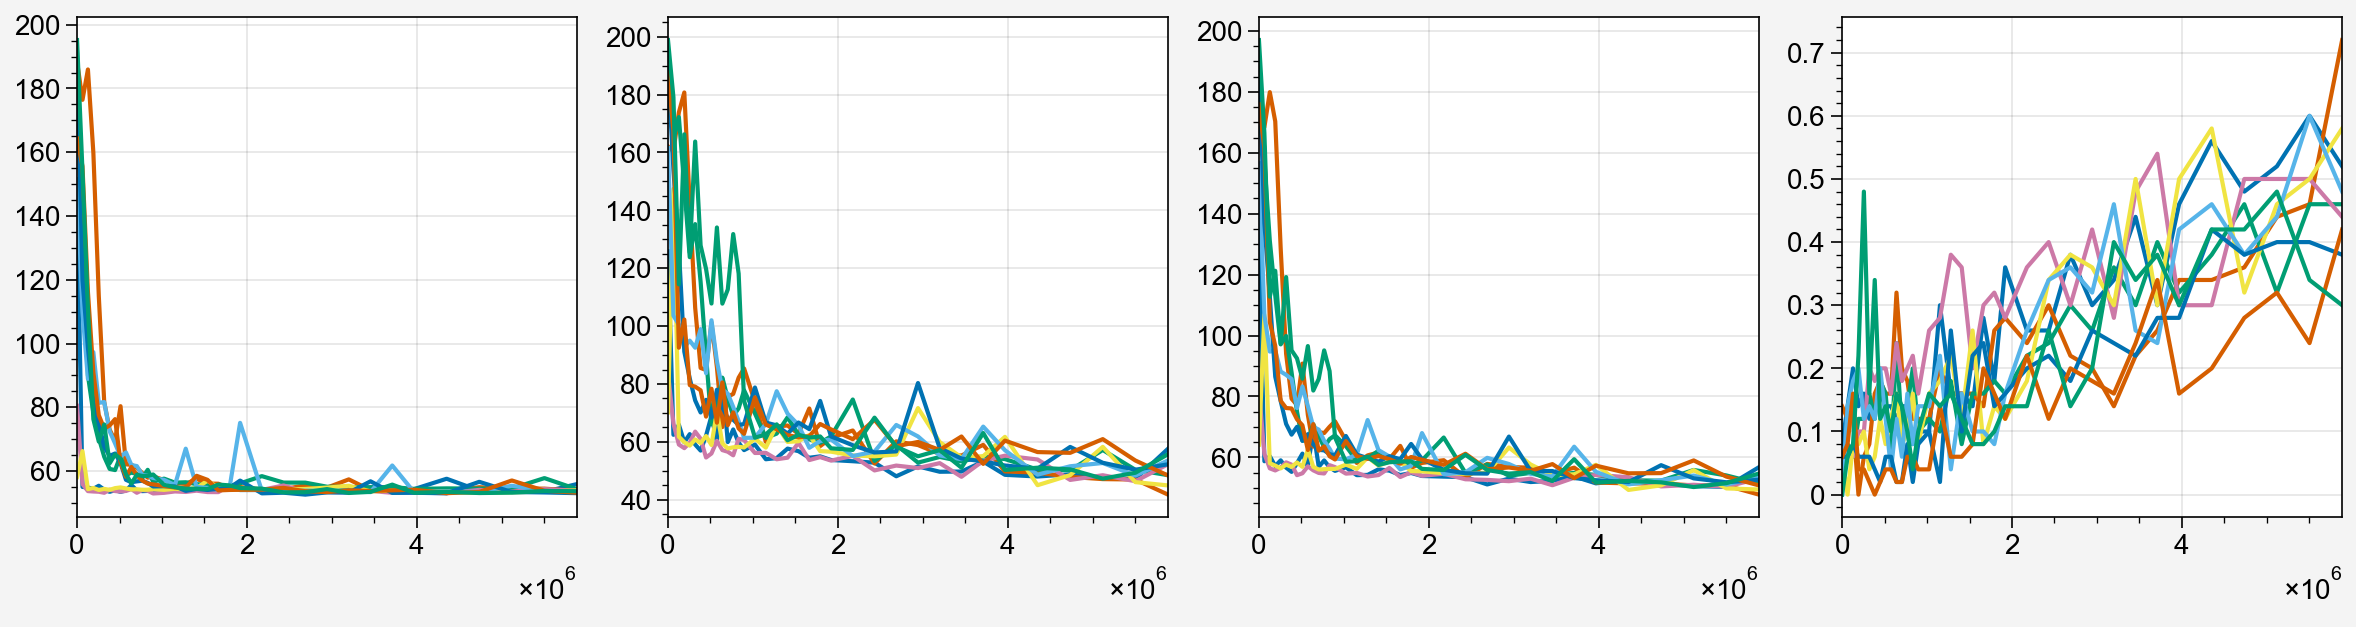

In [82]:
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 0.1
keys = ['ns_lens', 'ws_lens', 'comb_lens', 'surs']

for key in keys:
    del summary[p][key][8]

x = chk_sched*64*100

fig, ax = pplt.subplots(ncols=4, sharey=False)
for i, key in enumerate(keys):
    ax[i].plot(x, np.array(summary[p][key]).T)
    
    

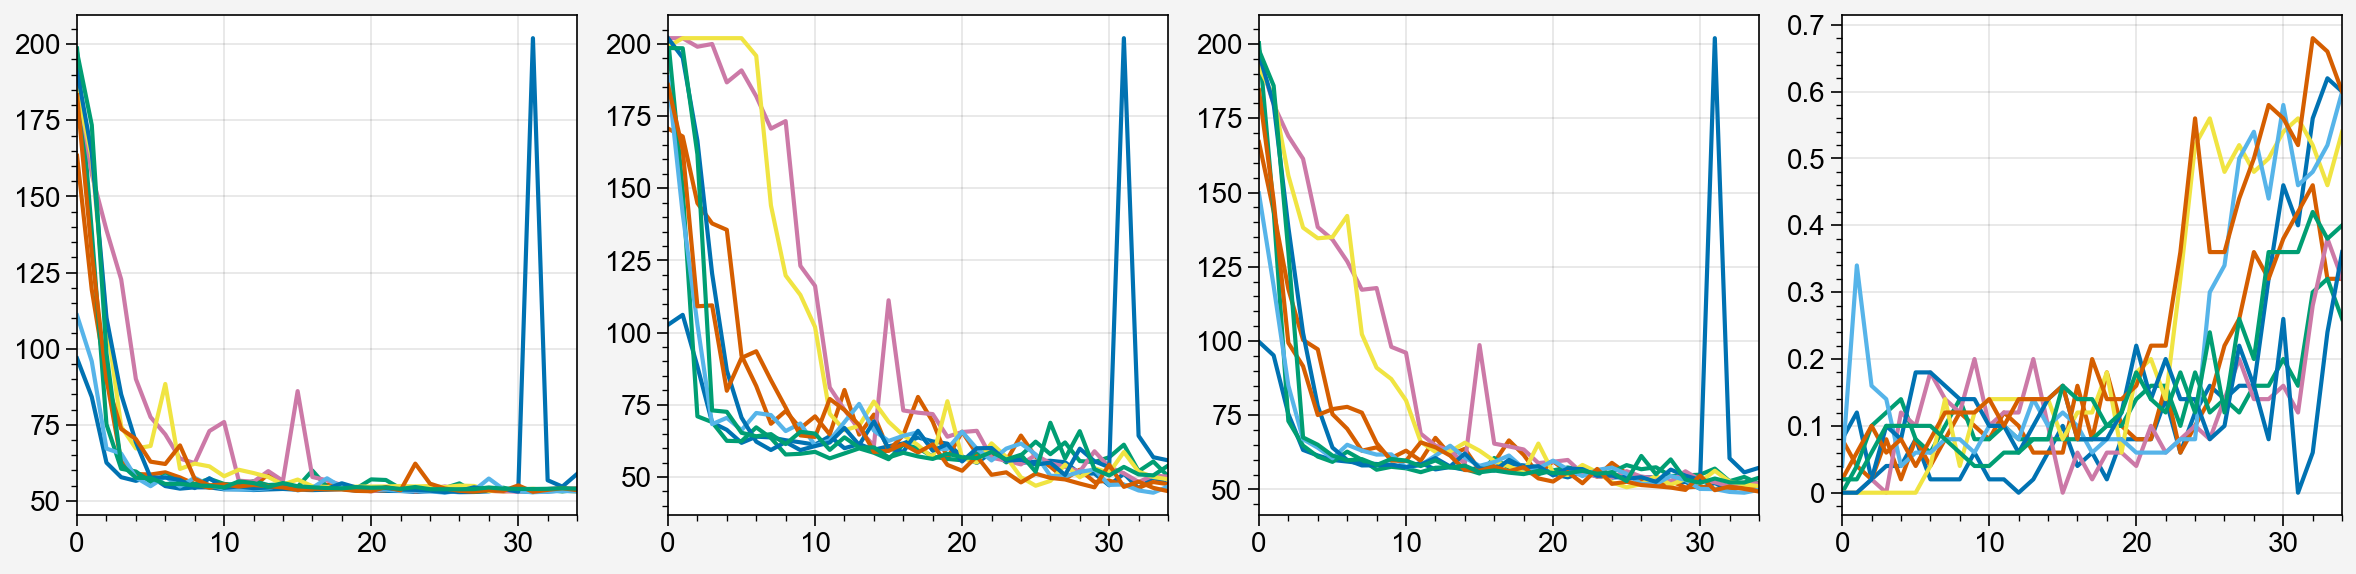

In [64]:
folder = Path('data/shortcut/sc_aux_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
p = 'catfacewall'
keys = ['ns_lens', 'ws_lens', 'comb_lens', 'surs']

for key in keys:
    del summary[p][key][8]

x = chk_sched*64*100

fig, ax = pplt.subplots(ncols=4, sharey=False)
for i, key in enumerate(keys):
    ax[i].plot(np.array(summary[p][key]).T)
    
    

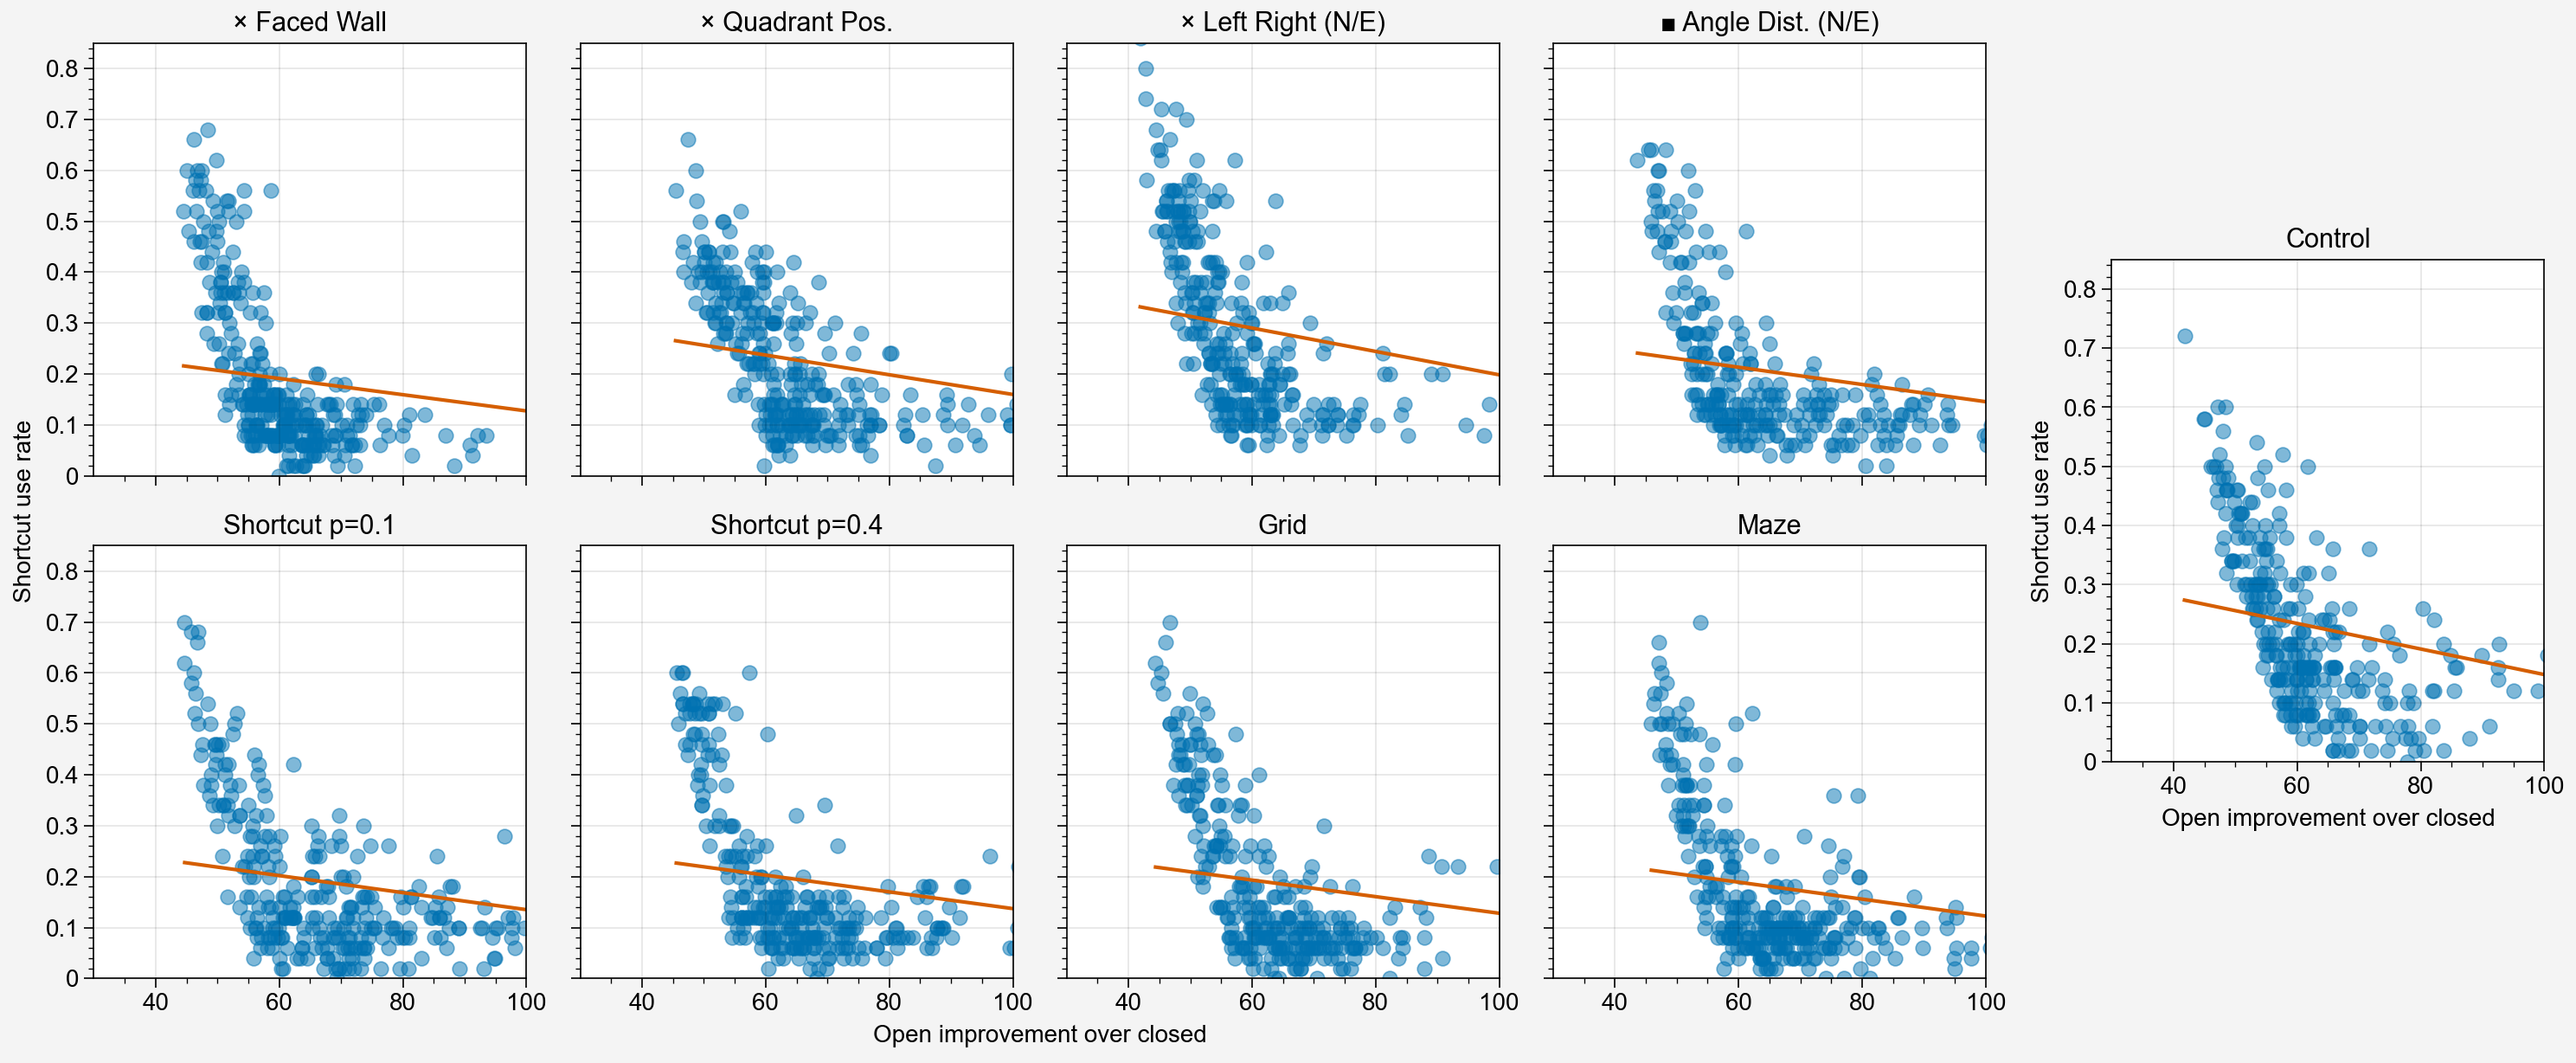

In [81]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

array = [
    [1,1, 2,2, 3,3, 4,4, 0,0,],
    [1,1, 2,2, 3,3, 4,4, 9,9,],
    [5,5, 6,6, 7,7, 8,8, 9,9,],
    [5,5, 6,6, 7,7, 8,8, 0,0,],
]

fig, axs = pplt.subplots(array)

all_labels = []
for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        ax = axs[i*4 + j]
        subset = subsets[train][j]
        all_labels.append(labels[train][j])

        diff = np.array(summary[subset]['ns_lens']) - np.array(summary[subset]['ws_lens'])
        diff = np.array(summary[subset]['ws_lens'])
        x = diff.flatten()
        y = np.array(summary[subset]['surs']).flatten()
        # x = x[x > -30]
        ax.scatter(x, y, alpha=0.5)
        x, y, r2 = linear_bestfit(x, y)
        ax.plot(x, y)
        # ax.text(-20, 0.7, str(round(r2, 3)))
        
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
ax = axs[8]
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]
diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
diff = np.array(summary[p]['ws_lens'])
x = diff.flatten()
y = np.array(summary[p]['surs']).flatten()
# x = x[x > -30]
ax.scatter(x, y, alpha=0.5)
x, y, r2 = linear_bestfit(x, y)
ax.plot(x, y)
# ax.text(-20, 0.7, str(round(r2, 3)))
all_labels.append('Control')

axs.format(xlabel='Open improvement over closed', ylabel='Shortcut use rate',
         xlim=[30, 100], ylim=[0, 0.85], title=all_labels)


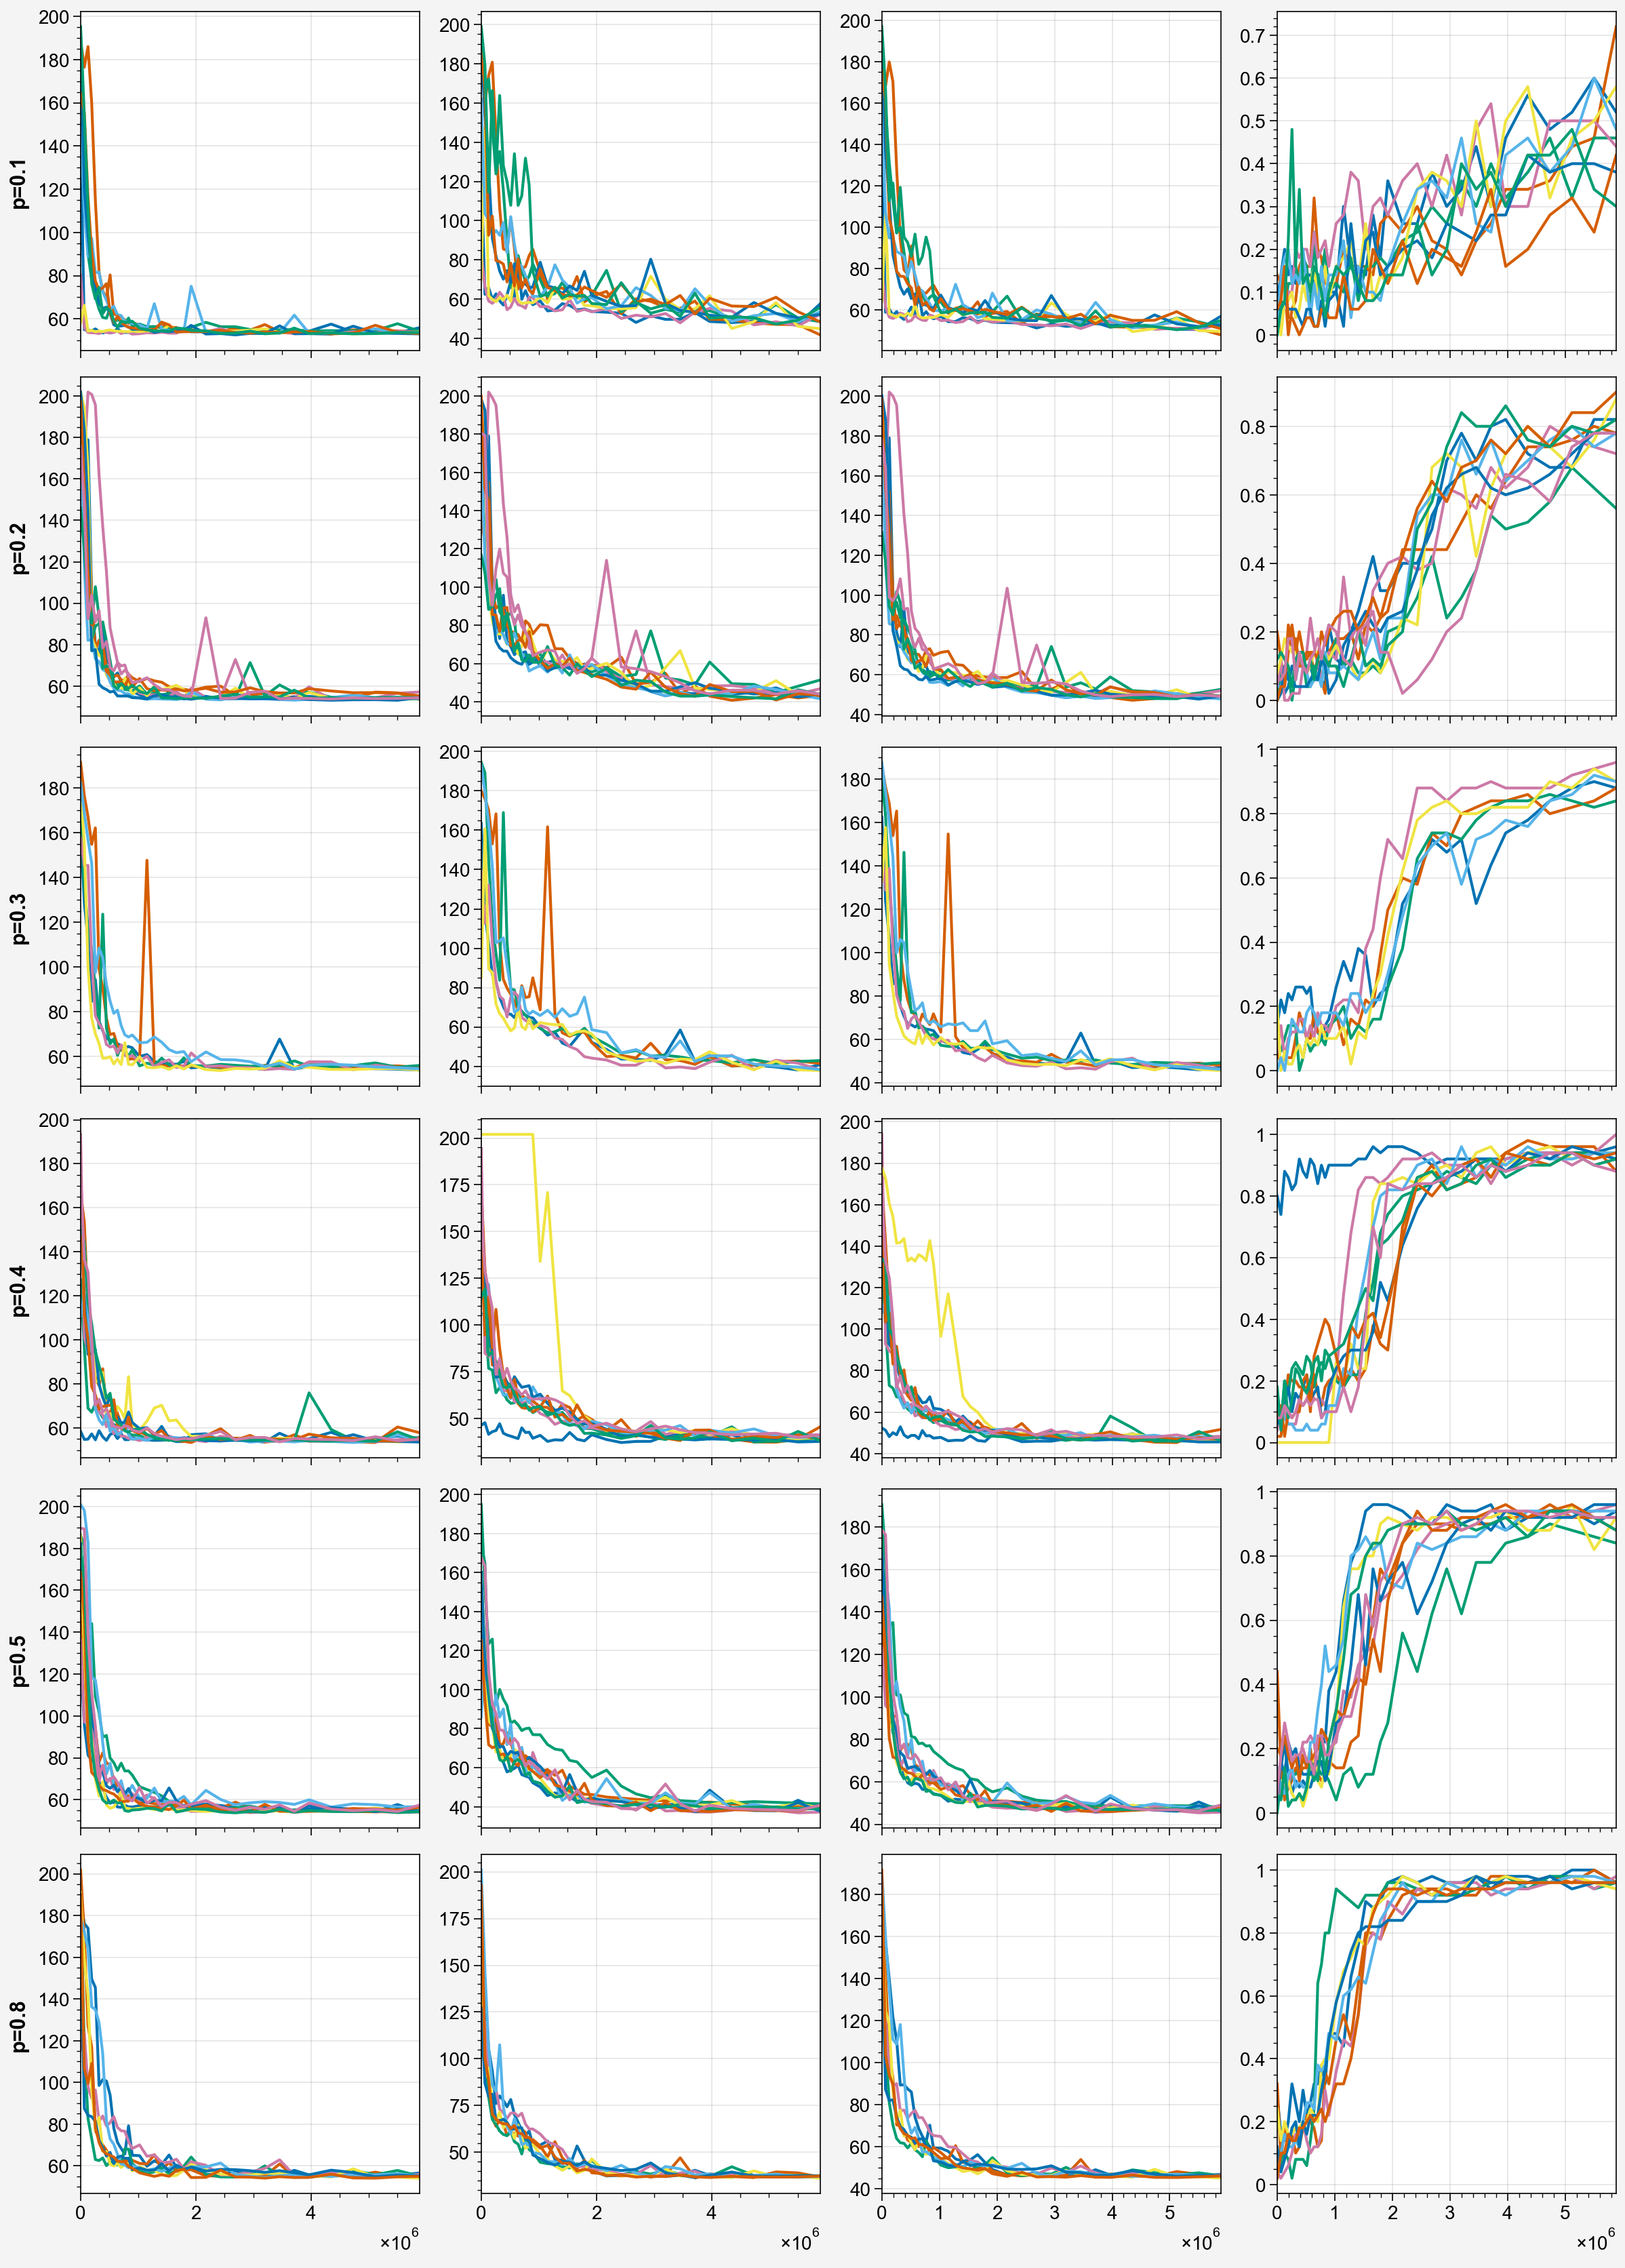

In [88]:
folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
keys = ['ns_lens', 'ws_lens', 'comb_lens', 'surs']

for key in keys:
    del summary[0.1][key][8]
    del summary[0.3][key][2]

x = chk_sched*64*100

fig, ax = pplt.subplots(nrows=6, ncols=4, sharey=False)
for i, p in enumerate(probs):
    for j, key in enumerate(keys):
        ax[i, j].plot(x, np.array(summary[p][key]).T)
        
ax.format(leftlabels=[f'p={p}' for p in probs])
    